# AI Project 4- Colorization

 Leena Dighole

In [2]:
#Import libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from tabulate import tabulate

### Clustering

In [9]:
#K-means Clustering 
class clustering:
    
    
    def centroid_initialise(self,train_data,k):
        '''
        This function initializes k data points as centroids
        '''
        c = random.choices(train_data,k=k)
        return c

    
    def new_centroids(self,train_data,clusters_list,k):
        '''
        This functions calculates new means of the cluster
        1) Initialize a list to store new centroids
        2) Iterate over the each of cluster i,e, till k 
        3) Fetch the cluster data
        4) Calculate the new mean using the cluster data points
        
        '''
        centroids_list = [] 
        
        for i in range(k): 
            cluster_data = train_data[clusters_list==i] 
            centroids_list.append(cluster_data.mean(axis=0)) 
        return np.array(centroids_list)

    def fetch_cluster_assignment(self,train_data,centroids_list,k):
        '''
        This function fetches the cluster assignments
        1) Data points x Cluster matrix - distance matrix
        2) Calculate the Euclidean distance `dist`  vector
        3) Assign the columns to the distance `dist` vector
        4) Calculate the cluster assignments
        '''
        distances = np.zeros(((train_data.shape)[0],k)) 
        
        for index,centroid in enumerate(centroids_list): 
            dist = np.linalg.norm(train_data - centroid,axis=1) 
            distances[:,index] = dist 
        clusters_list = np.argmin(distances,axis=1)
       # print('clusters_list',clusters_list)
        return clusters_list 

    
    def kmeans_algo(self,train_data,k,num_of_iters):
        '''
        This function calculates and returns list of centroids and cluster assignments
        Note: `num_of_iters` is the number of iterations in k-means algorithm.
        1) Initialise the centroids
        2) Fetch the cluster assignment list
        3) Interate over `num_of_iters` to calculate new averages to update the centroids
        
        '''
        centroids_list = self.centroid_initialise(train_data,k) 
        clusters_list = self.fetch_cluster_assignment(train_data,centroids_list,k) 
        
        for i in range(num_of_iters):  
            prev_clusters_list = clusters_list
            centroids_list = self.new_centroids(train_data,clusters_list,k) 
            clusters_list = self.fetch_cluster_assignment(train_data,centroids_list,k) 
            if (clusters_list == prev_clusters_list).all():
                print('Unchanged clusters','k = ',k)
                break
        return centroids_list,clusters_list

    
    def calculate_sse(self,train_data,centroids_list,clusters_list):
        '''
        SSE is defined as the sum of the squared distance between centroid and each member of the cluster.
        '''
        sse = 0
        for data_index,data_point in enumerate(train_data):
            dist = np.linalg.norm(data_point - centroids_list[clusters_list[data_index]])
            sse += (dist**2)
        return sse/len(train_data)

    def elbow(self,train_data,low=1,high=10,num_of_iters=1000):
        '''
        Elbow method to find the optimal k from low = 1 to high =10
        '''
        elbow_data = []
        for k in range(low,high+1):
            centroids_list,clusters_list = self.kmeans_algo(train_data,k,num_of_iters)
            sse = self.calculate_sse(train_data,centroids_list,clusters_list)
            elbow_data.append((k,sse))
        return elbow_data

    def plot_elbow_graph(self,data):
        '''
        This function is used to plot the Sum of Squared Errors against the number of clusters k
        '''
        plt.plot(data['k'],data['cost'])
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Sum of Squared Errors')
        plt.show()

### Basic Agent

In [15]:
class basic_agent(object):
    
    def make_gray_left_half_patch_arr(self,gray_lh_arr,patch_dim):
        '''
        Classification of the gray scale image. This uses k-nearest neighbour algorithm by selecting a 3 x 3 patch 
        in the left half of the image.
        
        '''
        global gray_left_half_patch_arr
        patch_list = []
        print(gray_lh_arr.shape)
        
        for r in range(0,gray_lh_arr.shape[0]-patch_dim+1):
            for c in range(0,gray_lh_arr.shape[1]-patch_dim+1):
                patch = gray_lh_arr[r:r+patch_dim,c:c+patch_dim]
                patch_list.append(patch)
                
        gray_left_half_patch_arr = np.array(patch_list)
        print(len(gray_left_half_patch_arr))

    def fetch_most_similar_patches(self,gray_lh_arr,gray_rh_patch,patch_dim,number_of_patches):
        '''
        This function gets the most similar grayscale patches from the left side image based on the number of patches aka
        nearest neighbours
        '''
        patch_dist_arr = (np.sum(np.sum((gray_left_half_patch_arr - gray_rh_patch)**2,axis=2),axis=1))**0.5
        patch_dist_arr_sorted = np.sort(patch_dist_arr)
        min_dist_list = patch_dist_arr_sorted[:number_of_patches]
        most_similar_patches_dict = {} # (r,c):dist
        
        for dist in min_dist_list:
            patch_dist_arr_index = np.where(patch_dist_arr==dist)[0]
            count = 0
            while True:
                r = (patch_dist_arr_index[count]//(gray_lh_arr.shape[1]-patch_dim+1))
                c = (patch_dist_arr_index[count]%(gray_lh_arr.shape[1]-patch_dim+1))
                if (r,c) not in most_similar_patches_dict:
                    most_similar_patches_dict[(r,c)] = float(dist)
                    break
                count += 1
        return most_similar_patches_dict

    def fetch_rgb_color_patch(self,recolored_lh_arr,gray_rh_patch,most_similar_patches_dict,patch_dim):
        '''
        This function fetches the majority representative color of the matching patch from the recolored left half image
        '''
        
        representative_colors_dict = {}
        
        for (r,c) in most_similar_patches_dict:
            color_tuple = tuple(recolored_lh_arr[r+patch_dim//2,c+patch_dim//2,:])
            if color_tuple not in representative_colors_dict:
                representative_colors_dict[color_tuple] = 1
            else:
                representative_colors_dict[color_tuple] += 1
        max_count = max(representative_colors_dict.values())
        
        if max_count == 1:
            most_similar_patch_dist = min(most_similar_patches_dict.values())
            mspd_r,mspd_c = [(r,c) for (r,c) in most_similar_patches_dict
                             if most_similar_patches_dict[(r,c)]==most_similar_patch_dist][0]
            representative_color = recolored_lh_arr[mspd_r+patch_dim//2,
                                                    mspd_c+patch_dim//2,
                                                    :]
            return representative_color
        else:
            majority_representative_color = [color_tuple for color_tuple in representative_colors_dict
                                             if representative_colors_dict[color_tuple]==max_count][0]
            return majority_representative_color

    def color_right_half_ba(self,recolored_lh_arr,gray_lh_arr,gray_rh_arr,patch_dim,number_of_patches):
        '''
        The function colors the right side of the image majority respresentative color from similar patch 
        of the recolored left half image.
        '''
        global gray_left_half_patch_arr
        recolored_rh_arr = np.zeros(gray_rh_arr.shape+(3,)) 
        
        # create flattened array of all the patches of gray left half
        
        self.make_gray_left_half_patch_arr(gray_lh_arr,patch_dim) 
        for r in range(0,gray_rh_arr.shape[0]-patch_dim+1):
            for c in range(0,gray_rh_arr.shape[1]-patch_dim+1):
                print(r,c)
                
                gray_rh_patch = gray_rh_arr[r:r+patch_dim,c:c+patch_dim]
                most_similar_patches_dict = self.fetch_most_similar_patches(gray_lh_arr,
                                                                      gray_rh_patch,
                                                                      patch_dim,
                                                                      number_of_patches)
                patch_color = self.fetch_rgb_color_patch(recolored_lh_arr,
                                                    gray_rh_patch,
                                                    most_similar_patches_dict,
                                                    patch_dim
                                                    )
                recolored_rh_arr[r+patch_dim//2,c+patch_dim//2,:] = patch_color
        recolored_rh_arr = np.asarray(recolored_rh_arr,dtype='uint8')
        del gray_left_half_patch_arr
        return recolored_rh_arr

### Improved Agent

##### Activation function

In [31]:
class activation(object):
    def sigmoid(z):
        '''
        Sigmoid activation function - logistic function
        '''
        return 1/(1+np.exp(-z))
    
    def relu(z):
        '''
        Rectified Linear unit activation function 
        '''
        bool_arr = (z>0)
        return bool_arr.astype('uint8')

##### Optimization

In [ ]:
class optimization(object):
   '''
    Optimization Methods
    1) Gradient Descent : "gd"
    2) Mini Batch Gradient Descent : "mbgd"
   ''' 


def gradient_descent_algo(X,y,model,alpha,noi):
    '''find the local minimum of a differentiable cost function using full set of examples.
    alpha is the learning rate.
    noi is the number of iterations.
    X is the feature matrix of shape (m,n).
    y is the label vector of shape (m,1).'''
    for _ in range(noi): # iterate
        # compute derivatives of J w.r.t all the parameters in w and b
        dJ_dw,dJ_db = model.get_gradients(X,y) 
        # update all the parameters in w
        model.w -= alpha * dJ_dw
        # update parameter b
        model.b -= alpha * dJ_db 
        
def mini_batch_gradient_descent_algo(X,y,model,alpha,noi,bs):
    '''find the local minimum of a differentiable cost function using a batch of examples.
    alpha is the learning rate.
    noi is the number of iterations.
    X is the feature matrix of shape (m,n).
    y is the label vector of shape (m,1).
    bs is the batch size.'''
    m,n = X.shape
    for _ in range(noi): # iterate
        choices = np.array([np.random.randint(0,m) for _ in range(bs)])
        # compute derivatives of J w.r.t all the parameters in w and b
        dJ_dw,dJ_db = model.get_gradients(X[choices,:],y[choices,:]) 
        # update all the parameters in w
        model.w -= alpha * dJ_dw 
        # update parameter b
        model.b -= alpha * dJ_db 

##### Create Neural Network

In [32]:
class NeuralNetwork(object):

    def __init__(self,w_list=None,b_list=None):
        '''
        Initialise weights , bias and activation function
        '''
        self.w_list = w_list
        self.b_list = b_list
        self.activ = activation()
        
    
    def set_architecture(self,l):
        '''
        Architecture of the Neural network :
        Chosen : Input layer, 3-hidden layers and Output layer
        '''
        self.arch = l
        
    def set_activations(self,l):
        '''
        Set activation function
        '''
        self.activ = l
    
    def initialize_parameters(self):
        '''
        Set the weight and the bias parameters
        '''
        w_list = []
        b_list = []
        for i in range(len(self.arch)-1):
            w_i = np.random.randn(self.arch[i+1],self.arch[i])
            w_list.append(w_i)
            b_i = np.ones((self.arch[i+1],1))
            b_list.append(b_i)
        self.w_list = w_list
        self.b_list = b_list
    
    def forward_prop(self,X):
        '''
        Feed forward neural network 
        
        '''
        A_list = []
        m,n = X.shape
        A = X.T
        A_list.append(A)
        for i in range(len(self.w_list)):
            Z = (np.dot(self.w_list[i],A)) + self.b_list[i]
            if self.activ[i] == 'sigm':
                A = activation.sigmoid(Z)
            elif self.activ[i] == 'relu':
                A = activation.relu(Z)
            A_list.append(A)
        return A_list
    
    def calculate_cost(self,A,Y):
        '''
        Calculate Cost Function
        '''
        return -(np.sum(Y*np.log(A)))/Y.shape[1]
        
    def train(self,X,Y,alpha,noi,method='sgd',bs=1):
        '''
        Considering optimization method default stocastic gradient descent 
        m = number of examples
        n = number of features
        gd = Gradient Descent 
        mbgd = Mini-Batch Gradient Descent
        sgd = Stocastic Gradient Descent 
        '''
        
        m,n = X.shape 
        ##Initialise parameters
        self.initialize_parameters() 
        it = 0
        
        ## Number of iterations
        print(noi)
        #iterate
        for _ in range(noi): 
            choices = np.array([np.random.randint(0,m) for _ in range(bs)])
            w_list_new = []
            b_list_new = []
            ##  Based on chosen optimization function , the learning algorithm runs.
            if method == 'gd':
                A_list = self.forward_prop(X)
                cost = self.calculate_cost(A_list[-1],Y)
            elif method == 'sgd' or method == 'mbgd':
                A_list = self.forward_prop(X[choices,:].reshape(bs,n))
                cost = self.calculate_cost(A_list[-1],(Y[:,choices]).reshape(self.arch[-1],bs))
            print(cost,it)
            if cost < 0.0001:
                break
            
            it += 1
            if method == 'gd':
                delta_last = A_list[-1] - Y
            elif method == 'sgd' or method == 'mbgd':
                delta_last = A_list[-1] - (Y[:,choices]).reshape(self.arch[-1],bs)
            
            dJ_dw_last = (np.dot(delta_last,(A_list[-2]).T))/m
            dJ_db_last = np.sum(delta_last,axis=1,keepdims=True)
            
            w_last_new = self.w_list[-1] - alpha*dJ_dw_last
            b_last_new = self.b_list[-1] - alpha*dJ_db_last
            w_list_new.insert(0,w_last_new)
            b_list_new.insert(0,b_last_new)
            delta_prev = delta_last
            for i in range(len(self.w_list)-2,-1,-1):
                w = self.w_list[i+1]
                
                ### Activation Function - sigm - sigmoid , relu - Relu
                
                A = A_list[i+1]
                if self.activ[i] == 'sigm':
                    delta_i = (np.dot(w.T,delta_prev))*(A*(1-A))
                elif self.activ[i] == 'relu':
                    dg_dz = (A>=1).astype('uint8')
                    delta_i = (np.dot(w.T,delta_prev))*dg_dz
                    
                dJ_dw_i = np.dot(delta_i,(A_list[i]).T)
                dJ_db_i = np.sum(delta_i,axis=1,keepdims=True)
                w_new = self.w_list[i] - alpha*dJ_dw_i
                b_new = self.b_list[i] - alpha*dJ_db_i
                w_list_new.insert(0,w_new)
                b_list_new.insert(0,b_new)
                delta_prev = delta_i
                
            self.w_list = w_list_new
            self.b_list = b_list_new

In [41]:
#Improved agent
class improved_agent(object):
    
    def create_X(self,gray_lh_arr,patch_dim):
        '''
        Using the left half of the grayscale image , this function creates a patch of dimensions 5 x 5
        '''
        patch_list = []
        print(gray_lh_arr.shape)
        for r in range(0,gray_lh_arr.shape[0]-patch_dim+1):
            for c in range(0,gray_lh_arr.shape[1]-patch_dim+1):
                patch = gray_lh_arr[r:r+patch_dim,c:c+patch_dim]
                patch = patch.reshape((patch_dim**2))
                patch_list.append(patch)

        X = (np.array(patch_list))
        print(len(X))
        return X

    def create_Y(self,assigned_clusters_arr,number_of_colors,patch_dim):
        '''
        This function does cluster assignment - assignment color based in assigned clusters.
        '''
        m,n = (assigned_clusters_arr.shape)
        y = np.zeros((number_of_colors,(m-patch_dim+1)*(n-patch_dim+1)))
        for r in range(0,m-patch_dim+1):
            for c in range(0,n-patch_dim+1):
                row_num = assigned_clusters_arr[r+patch_dim//2,c+patch_dim//2]
                col_num = (n-patch_dim+1)*r + c
                y[row_num,col_num] = 1
        return y

    def scale_features(self,X):
        '''
        Min - max scaling in range [0,1]
        '''
        min_arr = np.min(X,axis=0)
        max_arr = np.max(X,axis=0)
        mean_arr = np.mean(X,axis=0)
        X = (X - mean_arr)/(max_arr - min_arr)
        return X,mean_arr,max_arr,min_arr

    def color_right_half_ia(self,recolored_lh_arr,gray_lh_arr,gray_rh_arr,patch_dim,number_of_colors,centroids_arr,assigned_clusters_arr,
                         arch,alpha,noi,method,bs):  
        '''
        This function colors the right half of the grayscale image using the Feed-forward neural network

        '''
        X = self.create_X(gray_lh_arr,patch_dim)
        Y = self.create_Y(assigned_clusters_arr,number_of_colors,patch_dim)
        X,mean_arr,max_arr,min_arr = self.scale_features(X)

        nn = NeuralNetwork()
        nn.set_architecture(arch)
        nn.set_activations(['sigm' for _ in range(len(arch)-2)]+['sigm'])
        nn.train(X,Y,alpha,noi,method)
        recolored_rh_arr = np.zeros(gray_rh_arr.shape+(3,)) 
        for r in range(0,gray_rh_arr.shape[0]-patch_dim+1):
            for c in range(0,gray_rh_arr.shape[1]-patch_dim+1):
                gray_rh_patch = (gray_rh_arr[r:r+patch_dim,c:c+patch_dim])
                patch_flat = gray_rh_patch.reshape(1,patch_dim**2)
                patch_flat = (patch_flat - mean_arr)/(max_arr-min_arr)
                y_hat = (nn.forward_prop(patch_flat))[-1]
                index = np.argmax(y_hat)
                recolored_rh_arr[r+patch_dim//2,c+patch_dim//2,:] = centroids_arr[index]
        return recolored_rh_arr

### Test Metrics

In [33]:
class test_metrics(object):
    
    def mse(y,y_pred):
        '''
        Mean Square Error
        '''
        err1 = ((np.sum((y-y_pred)**2))/(y.shape[0]*y.shape[1]))
        return err1

    def rmse(y,y_pred):
        '''
        Root Mean Square Error
        '''
        err2 = (mse(y,y_pred))**0.5
        return err2

    def mad(y,y_pred):
        '''
        Mean Absolute Deviation
        '''
        err3 = (np.sum(np.abs(y-y_pred)))/(y.shape[0]*y.shape[1])
        return err3

    def classification_metrics(y,y_pred):
        '''
        This function outputs the confusion matrix , precision , support, recall and F1 score
        '''
        l = []
        for r in range(y.shape[0]):
            for c in range(y.shape[1]):
                l.append(tuple(y[r,c,:]))
        l = list(set(l))
        cm_arr = [[0 for c in range(len(l))] for r in range(len(l))]
        cm = pd.DataFrame(cm_arr)
        
        ## Iterate over true values
        for r in range(len(l)): 
        ## Iterate over predicted values    
            for c in range(len(l)): 
                indices = (y==l[r])
                indices2 = (y_pred==l[c])
                indices3 = (indices[:,:,0] & indices[:,:,1] & indices[:,:,2])
                indices4 = (indices2[:,:,0] & indices2[:,:,1] & indices2[:,:,2])
                indices5 = (indices3 & indices4)
                cm[r][c] = np.sum(indices5)
        cm_arr = np.array(cm)

        prec = [0 for _ in range(len(l))]
        rec = [0 for _ in range(len(l))]
        supp = [0 for _ in range(len(l))]
        f1_score = [0 for _ in range(len(l))]
        
        #Precision
        for r in range(len(l)):
            prec[r] = round(cm_arr[r][r]/np.sum(cm_arr[:,r]),4)
            
        #Recall
        for r in range(len(l)):
            rec[r] = round(cm_arr[r][r]/np.sum(cm_arr[r,:]),4)
        
        #F1 score
        for r in range(len(l)):
            supp[r] = np.sum(cm_arr[r,:])
        
        # Support
        for r in range(len(l)):
            f1_score[r] = round(2*prec[r]*rec[r]/(prec[r]+rec[r]),4)

        return l,cm_arr,prec,rec,f1_score,supp

### Load Image and Convert it to grayscale

In [38]:
class colorization(object):
    
    def load_rgb_image(img_path): 
        '''
        This function loads the rgb image from the image path. Return the RGB Image

        '''
        rgb_image = Image.open(img_path).convert('RGB') 
        return rgb_image

    
    def convert_gray_image(rgb_image):
        '''
        Convert rgb image to grayscale
        '''
        gray_image = ImageOps.grayscale(rgb_image) 
        return gray_image

    
    def fetch_left_half_rgb_image(rgb_image_array):
        '''
        This functions get the left side of the selected RGB image
        1) Consider the width of the image and divide it into 2 parts
        2) The array would be half-width(columns) x height(rows) x 3 (RGB)
        '''
        no_of_columns = (rgb_image_array.shape)[1]
        left_rgb_img_array = rgb_image_array[:,:(no_of_columns//2),:] 
        return left_rgb_img_array

   
    def fetch_both_halves_gray_image(gray_image_array):
        '''
         This function gets the whole gray scale image and divides it into two parts
        '''
        no_of_columns = (gray_image_array.shape)[1] 
        left_gray_img_array, right_gray_img_array = gray_image_array[:,:(no_of_columns//2)],gray_image_array[:,(no_of_columns//2):]
        return left_gray_img_array, right_gray_img_array

    
    def recolor_left_half_using_kmeans(rgb_lh_arr,number_of_colors,useElbowMethod=False,low=2,high=10,num_of_iters=1000):
        '''
        Recolor the left half of the image using k-means clustering.
        Here, user can give an input whether they would like to use k=5 or use optimal k using elbow method. 
        By default, it is set to false. 
        Matrix is flattened into a vector of data points (r,g,b).
        '''
        cl = clustering()
        rgb_lh_arr_flat_shape = (rgb_lh_arr.shape[0]*rgb_lh_arr.shape[1],3)
        rgb_lh_arr_flat = rgb_lh_arr.reshape(rgb_lh_arr_flat_shape)
        # if elbow method is False
        if not useElbowMethod:
            # number of clusters(k) = given number of colors 
            number_of_clusters = number_of_colors 
        # else if elbow method is True    
        else:
            #Calculate sse for k = 1 to k = 10
            elbow_data = cl.elbow(rgb_lh_arr_flat,low,high,num_of_iters) 
            df = pd.DataFrame(elbow_data,columns=['k','cost'])
            cl.plot_elbow_graph(df)
            number_of_clusters = int(input('Enter value of k at elbow point in the plot: '))
        
        # Call the kmeans clustering algorithm for num_of_iter = 1000
        centroids_arr,assigned_clusters_arr_flat = cl.kmeans_algo(rgb_lh_arr_flat,number_of_clusters,1000) 
        #Reshape into a matrix
        assigned_clusters_arr = assigned_clusters_arr_flat.reshape((rgb_lh_arr.shape[0],rgb_lh_arr.shape[1]))
        # Recolor left-half of image by assigning it to zeros
        
        recolored_lh_arr = np.zeros((rgb_lh_arr.shape)) 
        for index,centroid in enumerate(centroids_arr):
            '''
               Construct a boolean array and assign the vectorized data points
               and convert all float numbers into 8-bit integers (0-255)
            '''
            bool_indices = (assigned_clusters_arr==index) 
            recolored_lh_arr[bool_indices] = centroid
        recolored_lh_arr = np.asarray(recolored_lh_arr,dtype='uint8') 
        centroids_arr = centroids_arr.astype(dtype='uint8')
        return centroids_arr,assigned_clusters_arr,recolored_lh_arr,number_of_clusters


    def recolor_right_half(recolored_lh_arr,gray_lh_arr,gray_rh_arr,agent_name,**d):
        '''
         recolor right half of gray-scaled image and return recolored right half of gray-scaled image
         
        '''
        ba = basic_agent()
        ia = improved_agent()
        #### EXECUTE BASIC COLORING AGENT 
        if agent_name == 'basic':
            patch_dim = d['patch_dim']
            number_of_patches = d['number_of_patches']
            recolored_rh_arr = ba.color_right_half_ba(recolored_lh_arr,gray_lh_arr,gray_rh_arr,patch_dim,number_of_patches)
        #### EXECUTE IMPROVED COLORING AGENT
        elif agent_name == 'improved': 
            patch_dim = d['patch_dim']
            number_of_colors = d['number_of_colors']
            centroids_arr = d['centroids_arr']
            assigned_clusters_arr = d['assigned_clusters_arr']
            arch = d['arch']
            alpha = d['alpha']
            noi = d['noi']
            method = d['method']
            bs = d['bs']
            recolored_rh_arr = ia.color_right_half_ia(recolored_lh_arr,gray_lh_arr,gray_rh_arr,patch_dim,number_of_colors,
                                                   centroids_arr,assigned_clusters_arr,arch,alpha,noi,method,bs)
        return recolored_rh_arr 

    
    def combine_both_halves(lh_arr,rh_arr):
        '''
         Merge left and right halfs to get the full image .
         Create array of zeros to store the full image
        
        '''
        recolored_img_arr = np.zeros((lh_arr.shape[0],lh_arr.shape[1]+rh_arr.shape[1],3)) # array of zeros to store the full image
        for r in range(recolored_img_arr.shape[0]):
            recolored_img_arr[r,:lh_arr.shape[1],:] = lh_arr[r,:,:]
            recolored_img_arr[r,lh_arr.shape[1]:,:] = rh_arr[r,:,:]
        recolored_img_arr = np.asarray(recolored_img_arr,dtype='uint8') # convert all float numbers into 8-bit integers (0-255)
        return recolored_img_arr # return full colored image

#### Load Image

In [20]:

#In this cell, load the selected image
#Convert colored image into  3-Dimensional ndarray (R,G,B)
#Get the left half of the colored image

rgb_image = colorization.load_rgb_image(r'/Users/leena/Desktop/hw4/Results/elephant.jpg')
rgb_image_array = np.array(rgb_image) 
rgb_left_half_array = colorization.fetch_left_half_rgb_image(rgb_image_array)

#### Choose Optimal K

Enter `True` to use Elbow or `False` to not use Elbow: False
Unchanged clusters k =  2
Unchanged clusters k =  3
Unchanged clusters k =  4
Unchanged clusters k =  5
Unchanged clusters k =  6
Unchanged clusters k =  7
Unchanged clusters k =  8
Unchanged clusters k =  9
Unchanged clusters k =  10
Unchanged clusters k =  11
Unchanged clusters k =  12
Unchanged clusters k =  13
Unchanged clusters k =  14
Unchanged clusters k =  15


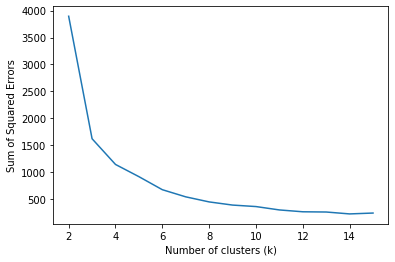

Enter value of k at elbow point in the plot: 5
Unchanged clusters k =  5


In [21]:
# Use default k=5 as given in the assignment 
#Bonus: Using elbow method, optimal k i.e, number of colors can be determined to recolor the left half of the image

useElbowMethod = bool(input('Enter `True` to use Elbow or `False` to not use Elbow: '))
if not useElbowMethod:
    # number of colors to use for recoloring left half
    number_of_colors = 5 
else:
    # User input based on the SSE- K graph using elbow method
    number_of_colors = None 

# Using k-means clustering algorithm, recolor the left half of the image
centroids_arr,assigned_clusters_arr,recolored_lh_arr,number_of_colors = colorization.recolor_left_half_using_kmeans(rgb_left_half_array,number_of_colors,useElbowMethod,low=2,high=15,num_of_iters=1000)


#### Recolored left-half image using kmeans 

In [22]:
#Saving the left half of the recolored image using k-means clustering
Image.fromarray(recolored_lh_arr).save(r'/Users/leena/Desktop/hw4/Results/recolored_lh_arr.png')

#### Convert RGB image to grayscale

In [24]:
# Convert to grayscale image
gray_image = colorization.convert_gray_image(rgb_image) 

# convert image into ndarray
gray_image_array = np.array(gray_image) 

# fetch both halves of the grayscaled image.
gray_lh_arr,gray_rh_arr = colorization.fetch_both_halves_gray_image(gray_image_array)
Image.fromarray(gray_lh_arr).save(r'/Users/leena/Desktop/hw4/Results/grayed/gray_lh_arr.png')
Image.fromarray(gray_rh_arr).save(r'/Users/leena/Desktop/hw4/Results/grayed/gray_rh_arr.png')


#### AI agent specs definition

In [26]:
# basic agent specs definition
basic_agent_spec = {
        #dimension of the patch : 3x3
        'patch_dim':3, 
         # number of patches is the number of similar patches to match using k-nearest neighbors algorithm
        'number_of_patches':8
    }

In [43]:
# improved agent specs definition
improved_agent_spec = {
        # dimension of the patch : 3x3
        'patch_dim':5, 
        # kmeans : number of clusters k
        'number_of_colors':number_of_colors, 
        # kmeans : centroid array
        'centroids_arr':centroids_arr, 
        # kmeans: matrix of assigned clusters of each pixel in left half of the image
        'assigned_clusters_arr':assigned_clusters_arr, 
        # architecture of neural network from input layer to output layer. All numbers exclude the bias unit.
        'arch':[25,30,30,35,30,number_of_colors], 
         # learning rate
        'alpha':0.000004,
        # number of iterations
        'noi':10000, 
        # optimization method. Possible values: Gradient descent(gd), Mini-Batch Gradient descent(mbgd)
        #Stochastic Gradient Descent(sgd)
        'method':'gd', 
        # mini-batch  size for mbgd
        'bs':10000, 
    }

#### Run basic agent to recolor right half of the image

In [30]:
recolored_lh_arr_basic = colorization.recolor_right_half(recolored_lh_arr,gray_lh_arr,gray_lh_arr,'basic',**basic_agent_spec)
recolored_lh_arr_basic = np.asarray(recolored_lh_arr_basic,dtype='uint8')
recolored_rh_arr_basic = colorization.recolor_right_half(recolored_lh_arr,gray_lh_arr,gray_rh_arr,'basic',**basic_agent_spec)
recolored_rh_arr_basic = np.asarray(recolored_rh_arr_basic,dtype='uint8')

(533, 150)
78588
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42


10 70
10 71
10 72
10 73
10 74
10 75
10 76
10 77
10 78
10 79
10 80
10 81
10 82
10 83
10 84
10 85
10 86
10 87
10 88
10 89
10 90
10 91
10 92
10 93
10 94
10 95
10 96
10 97
10 98
10 99
10 100
10 101
10 102
10 103
10 104
10 105
10 106
10 107
10 108
10 109
10 110
10 111
10 112
10 113
10 114
10 115
10 116
10 117
10 118
10 119
10 120
10 121
10 122
10 123
10 124
10 125
10 126
10 127
10 128
10 129
10 130
10 131
10 132
10 133
10 134
10 135
10 136
10 137
10 138
10 139
10 140
10 141
10 142
10 143
10 144
10 145
10 146
10 147
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
11 17
11 18
11 19
11 20
11 21
11 22
11 23
11 24
11 25
11 26
11 27
11 28
11 29
11 30
11 31
11 32
11 33
11 34
11 35
11 36
11 37
11 38
11 39
11 40
11 41
11 42
11 43
11 44
11 45
11 46
11 47
11 48
11 49
11 50
11 51
11 52
11 53
11 54
11 55
11 56
11 57
11 58
11 59
11 60
11 61
11 62
11 63
11 64
11 65
11 66
11 67
11 68
11 69
11 70
11 71
11 72
11 73
11 74
11 75
11 76
11 77
11 78
11 79
11 80
11 81
11

19 48
19 49
19 50
19 51
19 52
19 53
19 54
19 55
19 56
19 57
19 58
19 59
19 60
19 61
19 62
19 63
19 64
19 65
19 66
19 67
19 68
19 69
19 70
19 71
19 72
19 73
19 74
19 75
19 76
19 77
19 78
19 79
19 80
19 81
19 82
19 83
19 84
19 85
19 86
19 87
19 88
19 89
19 90
19 91
19 92
19 93
19 94
19 95
19 96
19 97
19 98
19 99
19 100
19 101
19 102
19 103
19 104
19 105
19 106
19 107
19 108
19 109
19 110
19 111
19 112
19 113
19 114
19 115
19 116
19 117
19 118
19 119
19 120
19 121
19 122
19 123
19 124
19 125
19 126
19 127
19 128
19 129
19 130
19 131
19 132
19 133
19 134
19 135
19 136
19 137
19 138
19 139
19 140
19 141
19 142
19 143
19 144
19 145
19 146
19 147
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
20 50
20 51
20 52
20 53
20 54
20 55
20 56
20 57
20 58
20 59
20

28 28
28 29
28 30
28 31
28 32
28 33
28 34
28 35
28 36
28 37
28 38
28 39
28 40
28 41
28 42
28 43
28 44
28 45
28 46
28 47
28 48
28 49
28 50
28 51
28 52
28 53
28 54
28 55
28 56
28 57
28 58
28 59
28 60
28 61
28 62
28 63
28 64
28 65
28 66
28 67
28 68
28 69
28 70
28 71
28 72
28 73
28 74
28 75
28 76
28 77
28 78
28 79
28 80
28 81
28 82
28 83
28 84
28 85
28 86
28 87
28 88
28 89
28 90
28 91
28 92
28 93
28 94
28 95
28 96
28 97
28 98
28 99
28 100
28 101
28 102
28 103
28 104
28 105
28 106
28 107
28 108
28 109
28 110
28 111
28 112
28 113
28 114
28 115
28 116
28 117
28 118
28 119
28 120
28 121
28 122
28 123
28 124
28 125
28 126
28 127
28 128
28 129
28 130
28 131
28 132
28 133
28 134
28 135
28 136
28 137
28 138
28 139
28 140
28 141
28 142
28 143
28 144
28 145
28 146
28 147
29 0
29 1
29 2
29 3
29 4
29 5
29 6
29 7
29 8
29 9
29 10
29 11
29 12
29 13
29 14
29 15
29 16
29 17
29 18
29 19
29 20
29 21
29 22
29 23
29 24
29 25
29 26
29 27
29 28
29 29
29 30
29 31
29 32
29 33
29 34
29 35
29 36
29 37
29 38
29 39
29

37 13
37 14
37 15
37 16
37 17
37 18
37 19
37 20
37 21
37 22
37 23
37 24
37 25
37 26
37 27
37 28
37 29
37 30
37 31
37 32
37 33
37 34
37 35
37 36
37 37
37 38
37 39
37 40
37 41
37 42
37 43
37 44
37 45
37 46
37 47
37 48
37 49
37 50
37 51
37 52
37 53
37 54
37 55
37 56
37 57
37 58
37 59
37 60
37 61
37 62
37 63
37 64
37 65
37 66
37 67
37 68
37 69
37 70
37 71
37 72
37 73
37 74
37 75
37 76
37 77
37 78
37 79
37 80
37 81
37 82
37 83
37 84
37 85
37 86
37 87
37 88
37 89
37 90
37 91
37 92
37 93
37 94
37 95
37 96
37 97
37 98
37 99
37 100
37 101
37 102
37 103
37 104
37 105
37 106
37 107
37 108
37 109
37 110
37 111
37 112
37 113
37 114
37 115
37 116
37 117
37 118
37 119
37 120
37 121
37 122
37 123
37 124
37 125
37 126
37 127
37 128
37 129
37 130
37 131
37 132
37 133
37 134
37 135
37 136
37 137
37 138
37 139
37 140
37 141
37 142
37 143
37 144
37 145
37 146
37 147
38 0
38 1
38 2
38 3
38 4
38 5
38 6
38 7
38 8
38 9
38 10
38 11
38 12
38 13
38 14
38 15
38 16
38 17
38 18
38 19
38 20
38 21
38 22
38 23
38 24
38

46 5
46 6
46 7
46 8
46 9
46 10
46 11
46 12
46 13
46 14
46 15
46 16
46 17
46 18
46 19
46 20
46 21
46 22
46 23
46 24
46 25
46 26
46 27
46 28
46 29
46 30
46 31
46 32
46 33
46 34
46 35
46 36
46 37
46 38
46 39
46 40
46 41
46 42
46 43
46 44
46 45
46 46
46 47
46 48
46 49
46 50
46 51
46 52
46 53
46 54
46 55
46 56
46 57
46 58
46 59
46 60
46 61
46 62
46 63
46 64
46 65
46 66
46 67
46 68
46 69
46 70
46 71
46 72
46 73
46 74
46 75
46 76
46 77
46 78
46 79
46 80
46 81
46 82
46 83
46 84
46 85
46 86
46 87
46 88
46 89
46 90
46 91
46 92
46 93
46 94
46 95
46 96
46 97
46 98
46 99
46 100
46 101
46 102
46 103
46 104
46 105
46 106
46 107
46 108
46 109
46 110
46 111
46 112
46 113
46 114
46 115
46 116
46 117
46 118
46 119
46 120
46 121
46 122
46 123
46 124
46 125
46 126
46 127
46 128
46 129
46 130
46 131
46 132
46 133
46 134
46 135
46 136
46 137
46 138
46 139
46 140
46 141
46 142
46 143
46 144
46 145
46 146
46 147
47 0
47 1
47 2
47 3
47 4
47 5
47 6
47 7
47 8
47 9
47 10
47 11
47 12
47 13
47 14
47 15
47 16
47 17
4

54 136
54 137
54 138
54 139
54 140
54 141
54 142
54 143
54 144
54 145
54 146
54 147
55 0
55 1
55 2
55 3
55 4
55 5
55 6
55 7
55 8
55 9
55 10
55 11
55 12
55 13
55 14
55 15
55 16
55 17
55 18
55 19
55 20
55 21
55 22
55 23
55 24
55 25
55 26
55 27
55 28
55 29
55 30
55 31
55 32
55 33
55 34
55 35
55 36
55 37
55 38
55 39
55 40
55 41
55 42
55 43
55 44
55 45
55 46
55 47
55 48
55 49
55 50
55 51
55 52
55 53
55 54
55 55
55 56
55 57
55 58
55 59
55 60
55 61
55 62
55 63
55 64
55 65
55 66
55 67
55 68
55 69
55 70
55 71
55 72
55 73
55 74
55 75
55 76
55 77
55 78
55 79
55 80
55 81
55 82
55 83
55 84
55 85
55 86
55 87
55 88
55 89
55 90
55 91
55 92
55 93
55 94
55 95
55 96
55 97
55 98
55 99
55 100
55 101
55 102
55 103
55 104
55 105
55 106
55 107
55 108
55 109
55 110
55 111
55 112
55 113
55 114
55 115
55 116
55 117
55 118
55 119
55 120
55 121
55 122
55 123
55 124
55 125
55 126
55 127
55 128
55 129
55 130
55 131
55 132
55 133
55 134
55 135
55 136
55 137
55 138
55 139
55 140
55 141
55 142
55 143
55 144
55 145
55 1

63 119
63 120
63 121
63 122
63 123
63 124
63 125
63 126
63 127
63 128
63 129
63 130
63 131
63 132
63 133
63 134
63 135
63 136
63 137
63 138
63 139
63 140
63 141
63 142
63 143
63 144
63 145
63 146
63 147
64 0
64 1
64 2
64 3
64 4
64 5
64 6
64 7
64 8
64 9
64 10
64 11
64 12
64 13
64 14
64 15
64 16
64 17
64 18
64 19
64 20
64 21
64 22
64 23
64 24
64 25
64 26
64 27
64 28
64 29
64 30
64 31
64 32
64 33
64 34
64 35
64 36
64 37
64 38
64 39
64 40
64 41
64 42
64 43
64 44
64 45
64 46
64 47
64 48
64 49
64 50
64 51
64 52
64 53
64 54
64 55
64 56
64 57
64 58
64 59
64 60
64 61
64 62
64 63
64 64
64 65
64 66
64 67
64 68
64 69
64 70
64 71
64 72
64 73
64 74
64 75
64 76
64 77
64 78
64 79
64 80
64 81
64 82
64 83
64 84
64 85
64 86
64 87
64 88
64 89
64 90
64 91
64 92
64 93
64 94
64 95
64 96
64 97
64 98
64 99
64 100
64 101
64 102
64 103
64 104
64 105
64 106
64 107
64 108
64 109
64 110
64 111
64 112
64 113
64 114
64 115
64 116
64 117
64 118
64 119
64 120
64 121
64 122
64 123
64 124
64 125
64 126
64 127
64 128
64 1

72 112
72 113
72 114
72 115
72 116
72 117
72 118
72 119
72 120
72 121
72 122
72 123
72 124
72 125
72 126
72 127
72 128
72 129
72 130
72 131
72 132
72 133
72 134
72 135
72 136
72 137
72 138
72 139
72 140
72 141
72 142
72 143
72 144
72 145
72 146
72 147
73 0
73 1
73 2
73 3
73 4
73 5
73 6
73 7
73 8
73 9
73 10
73 11
73 12
73 13
73 14
73 15
73 16
73 17
73 18
73 19
73 20
73 21
73 22
73 23
73 24
73 25
73 26
73 27
73 28
73 29
73 30
73 31
73 32
73 33
73 34
73 35
73 36
73 37
73 38
73 39
73 40
73 41
73 42
73 43
73 44
73 45
73 46
73 47
73 48
73 49
73 50
73 51
73 52
73 53
73 54
73 55
73 56
73 57
73 58
73 59
73 60
73 61
73 62
73 63
73 64
73 65
73 66
73 67
73 68
73 69
73 70
73 71
73 72
73 73
73 74
73 75
73 76
73 77
73 78
73 79
73 80
73 81
73 82
73 83
73 84
73 85
73 86
73 87
73 88
73 89
73 90
73 91
73 92
73 93
73 94
73 95
73 96
73 97
73 98
73 99
73 100
73 101
73 102
73 103
73 104
73 105
73 106
73 107
73 108
73 109
73 110
73 111
73 112
73 113
73 114
73 115
73 116
73 117
73 118
73 119
73 120
73 121
73 1

81 105
81 106
81 107
81 108
81 109
81 110
81 111
81 112
81 113
81 114
81 115
81 116
81 117
81 118
81 119
81 120
81 121
81 122
81 123
81 124
81 125
81 126
81 127
81 128
81 129
81 130
81 131
81 132
81 133
81 134
81 135
81 136
81 137
81 138
81 139
81 140
81 141
81 142
81 143
81 144
81 145
81 146
81 147
82 0
82 1
82 2
82 3
82 4
82 5
82 6
82 7
82 8
82 9
82 10
82 11
82 12
82 13
82 14
82 15
82 16
82 17
82 18
82 19
82 20
82 21
82 22
82 23
82 24
82 25
82 26
82 27
82 28
82 29
82 30
82 31
82 32
82 33
82 34
82 35
82 36
82 37
82 38
82 39
82 40
82 41
82 42
82 43
82 44
82 45
82 46
82 47
82 48
82 49
82 50
82 51
82 52
82 53
82 54
82 55
82 56
82 57
82 58
82 59
82 60
82 61
82 62
82 63
82 64
82 65
82 66
82 67
82 68
82 69
82 70
82 71
82 72
82 73
82 74
82 75
82 76
82 77
82 78
82 79
82 80
82 81
82 82
82 83
82 84
82 85
82 86
82 87
82 88
82 89
82 90
82 91
82 92
82 93
82 94
82 95
82 96
82 97
82 98
82 99
82 100
82 101
82 102
82 103
82 104
82 105
82 106
82 107
82 108
82 109
82 110
82 111
82 112
82 113
82 114
82 1

90 89
90 90
90 91
90 92
90 93
90 94
90 95
90 96
90 97
90 98
90 99
90 100
90 101
90 102
90 103
90 104
90 105
90 106
90 107
90 108
90 109
90 110
90 111
90 112
90 113
90 114
90 115
90 116
90 117
90 118
90 119
90 120
90 121
90 122
90 123
90 124
90 125
90 126
90 127
90 128
90 129
90 130
90 131
90 132
90 133
90 134
90 135
90 136
90 137
90 138
90 139
90 140
90 141
90 142
90 143
90 144
90 145
90 146
90 147
91 0
91 1
91 2
91 3
91 4
91 5
91 6
91 7
91 8
91 9
91 10
91 11
91 12
91 13
91 14
91 15
91 16
91 17
91 18
91 19
91 20
91 21
91 22
91 23
91 24
91 25
91 26
91 27
91 28
91 29
91 30
91 31
91 32
91 33
91 34
91 35
91 36
91 37
91 38
91 39
91 40
91 41
91 42
91 43
91 44
91 45
91 46
91 47
91 48
91 49
91 50
91 51
91 52
91 53
91 54
91 55
91 56
91 57
91 58
91 59
91 60
91 61
91 62
91 63
91 64
91 65
91 66
91 67
91 68
91 69
91 70
91 71
91 72
91 73
91 74
91 75
91 76
91 77
91 78
91 79
91 80
91 81
91 82
91 83
91 84
91 85
91 86
91 87
91 88
91 89
91 90
91 91
91 92
91 93
91 94
91 95
91 96
91 97
91 98
91 99
91 100
9

99 74
99 75
99 76
99 77
99 78
99 79
99 80
99 81
99 82
99 83
99 84
99 85
99 86
99 87
99 88
99 89
99 90
99 91
99 92
99 93
99 94
99 95
99 96
99 97
99 98
99 99
99 100
99 101
99 102
99 103
99 104
99 105
99 106
99 107
99 108
99 109
99 110
99 111
99 112
99 113
99 114
99 115
99 116
99 117
99 118
99 119
99 120
99 121
99 122
99 123
99 124
99 125
99 126
99 127
99 128
99 129
99 130
99 131
99 132
99 133
99 134
99 135
99 136
99 137
99 138
99 139
99 140
99 141
99 142
99 143
99 144
99 145
99 146
99 147
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
100 20
100 21
100 22
100 23
100 24
100 25
100 26
100 27
100 28
100 29
100 30
100 31
100 32
100 33
100 34
100 35
100 36
100 37
100 38
100 39
100 40
100 41
100 42
100 43
100 44
100 45
100 46
100 47
100 48
100 49
100 50
100 51
100 52
100 53
100 54
100 55
100 56
100 57
100 58
100 59
100 60
100 61
100 62
100 63
100 64
100 65
100 66
100 67
100 68
100 69
100 70
100 71
100 72
100 73


107 43
107 44
107 45
107 46
107 47
107 48
107 49
107 50
107 51
107 52
107 53
107 54
107 55
107 56
107 57
107 58
107 59
107 60
107 61
107 62
107 63
107 64
107 65
107 66
107 67
107 68
107 69
107 70
107 71
107 72
107 73
107 74
107 75
107 76
107 77
107 78
107 79
107 80
107 81
107 82
107 83
107 84
107 85
107 86
107 87
107 88
107 89
107 90
107 91
107 92
107 93
107 94
107 95
107 96
107 97
107 98
107 99
107 100
107 101
107 102
107 103
107 104
107 105
107 106
107 107
107 108
107 109
107 110
107 111
107 112
107 113
107 114
107 115
107 116
107 117
107 118
107 119
107 120
107 121
107 122
107 123
107 124
107 125
107 126
107 127
107 128
107 129
107 130
107 131
107 132
107 133
107 134
107 135
107 136
107 137
107 138
107 139
107 140
107 141
107 142
107 143
107 144
107 145
107 146
107 147
108 0
108 1
108 2
108 3
108 4
108 5
108 6
108 7
108 8
108 9
108 10
108 11
108 12
108 13
108 14
108 15
108 16
108 17
108 18
108 19
108 20
108 21
108 22
108 23
108 24
108 25
108 26
108 27
108 28
108 29
108 30
108 31
108

114 144
114 145
114 146
114 147
115 0
115 1
115 2
115 3
115 4
115 5
115 6
115 7
115 8
115 9
115 10
115 11
115 12
115 13
115 14
115 15
115 16
115 17
115 18
115 19
115 20
115 21
115 22
115 23
115 24
115 25
115 26
115 27
115 28
115 29
115 30
115 31
115 32
115 33
115 34
115 35
115 36
115 37
115 38
115 39
115 40
115 41
115 42
115 43
115 44
115 45
115 46
115 47
115 48
115 49
115 50
115 51
115 52
115 53
115 54
115 55
115 56
115 57
115 58
115 59
115 60
115 61
115 62
115 63
115 64
115 65
115 66
115 67
115 68
115 69
115 70
115 71
115 72
115 73
115 74
115 75
115 76
115 77
115 78
115 79
115 80
115 81
115 82
115 83
115 84
115 85
115 86
115 87
115 88
115 89
115 90
115 91
115 92
115 93
115 94
115 95
115 96
115 97
115 98
115 99
115 100
115 101
115 102
115 103
115 104
115 105
115 106
115 107
115 108
115 109
115 110
115 111
115 112
115 113
115 114
115 115
115 116
115 117
115 118
115 119
115 120
115 121
115 122
115 123
115 124
115 125
115 126
115 127
115 128
115 129
115 130
115 131
115 132
115 133
115 13

122 108
122 109
122 110
122 111
122 112
122 113
122 114
122 115
122 116
122 117
122 118
122 119
122 120
122 121
122 122
122 123
122 124
122 125
122 126
122 127
122 128
122 129
122 130
122 131
122 132
122 133
122 134
122 135
122 136
122 137
122 138
122 139
122 140
122 141
122 142
122 143
122 144
122 145
122 146
122 147
123 0
123 1
123 2
123 3
123 4
123 5
123 6
123 7
123 8
123 9
123 10
123 11
123 12
123 13
123 14
123 15
123 16
123 17
123 18
123 19
123 20
123 21
123 22
123 23
123 24
123 25
123 26
123 27
123 28
123 29
123 30
123 31
123 32
123 33
123 34
123 35
123 36
123 37
123 38
123 39
123 40
123 41
123 42
123 43
123 44
123 45
123 46
123 47
123 48
123 49
123 50
123 51
123 52
123 53
123 54
123 55
123 56
123 57
123 58
123 59
123 60
123 61
123 62
123 63
123 64
123 65
123 66
123 67
123 68
123 69
123 70
123 71
123 72
123 73
123 74
123 75
123 76
123 77
123 78
123 79
123 80
123 81
123 82
123 83
123 84
123 85
123 86
123 87
123 88
123 89
123 90
123 91
123 92
123 93
123 94
123 95
123 96
123 97
123 

130 62
130 63
130 64
130 65
130 66
130 67
130 68
130 69
130 70
130 71
130 72
130 73
130 74
130 75
130 76
130 77
130 78
130 79
130 80
130 81
130 82
130 83
130 84
130 85
130 86
130 87
130 88
130 89
130 90
130 91
130 92
130 93
130 94
130 95
130 96
130 97
130 98
130 99
130 100
130 101
130 102
130 103
130 104
130 105
130 106
130 107
130 108
130 109
130 110
130 111
130 112
130 113
130 114
130 115
130 116
130 117
130 118
130 119
130 120
130 121
130 122
130 123
130 124
130 125
130 126
130 127
130 128
130 129
130 130
130 131
130 132
130 133
130 134
130 135
130 136
130 137
130 138
130 139
130 140
130 141
130 142
130 143
130 144
130 145
130 146
130 147
131 0
131 1
131 2
131 3
131 4
131 5
131 6
131 7
131 8
131 9
131 10
131 11
131 12
131 13
131 14
131 15
131 16
131 17
131 18
131 19
131 20
131 21
131 22
131 23
131 24
131 25
131 26
131 27
131 28
131 29
131 30
131 31
131 32
131 33
131 34
131 35
131 36
131 37
131 38
131 39
131 40
131 41
131 42
131 43
131 44
131 45
131 46
131 47
131 48
131 49
131 50
131

138 5
138 6
138 7
138 8
138 9
138 10
138 11
138 12
138 13
138 14
138 15
138 16
138 17
138 18
138 19
138 20
138 21
138 22
138 23
138 24
138 25
138 26
138 27
138 28
138 29
138 30
138 31
138 32
138 33
138 34
138 35
138 36
138 37
138 38
138 39
138 40
138 41
138 42
138 43
138 44
138 45
138 46
138 47
138 48
138 49
138 50
138 51
138 52
138 53
138 54
138 55
138 56
138 57
138 58
138 59
138 60
138 61
138 62
138 63
138 64
138 65
138 66
138 67
138 68
138 69
138 70
138 71
138 72
138 73
138 74
138 75
138 76
138 77
138 78
138 79
138 80
138 81
138 82
138 83
138 84
138 85
138 86
138 87
138 88
138 89
138 90
138 91
138 92
138 93
138 94
138 95
138 96
138 97
138 98
138 99
138 100
138 101
138 102
138 103
138 104
138 105
138 106
138 107
138 108
138 109
138 110
138 111
138 112
138 113
138 114
138 115
138 116
138 117
138 118
138 119
138 120
138 121
138 122
138 123
138 124
138 125
138 126
138 127
138 128
138 129
138 130
138 131
138 132
138 133
138 134
138 135
138 136
138 137
138 138
138 139
138 140
138 141
138 

145 105
145 106
145 107
145 108
145 109
145 110
145 111
145 112
145 113
145 114
145 115
145 116
145 117
145 118
145 119
145 120
145 121
145 122
145 123
145 124
145 125
145 126
145 127
145 128
145 129
145 130
145 131
145 132
145 133
145 134
145 135
145 136
145 137
145 138
145 139
145 140
145 141
145 142
145 143
145 144
145 145
145 146
145 147
146 0
146 1
146 2
146 3
146 4
146 5
146 6
146 7
146 8
146 9
146 10
146 11
146 12
146 13
146 14
146 15
146 16
146 17
146 18
146 19
146 20
146 21
146 22
146 23
146 24
146 25
146 26
146 27
146 28
146 29
146 30
146 31
146 32
146 33
146 34
146 35
146 36
146 37
146 38
146 39
146 40
146 41
146 42
146 43
146 44
146 45
146 46
146 47
146 48
146 49
146 50
146 51
146 52
146 53
146 54
146 55
146 56
146 57
146 58
146 59
146 60
146 61
146 62
146 63
146 64
146 65
146 66
146 67
146 68
146 69
146 70
146 71
146 72
146 73
146 74
146 75
146 76
146 77
146 78
146 79
146 80
146 81
146 82
146 83
146 84
146 85
146 86
146 87
146 88
146 89
146 90
146 91
146 92
146 93
146 94
1

153 58
153 59
153 60
153 61
153 62
153 63
153 64
153 65
153 66
153 67
153 68
153 69
153 70
153 71
153 72
153 73
153 74
153 75
153 76
153 77
153 78
153 79
153 80
153 81
153 82
153 83
153 84
153 85
153 86
153 87
153 88
153 89
153 90
153 91
153 92
153 93
153 94
153 95
153 96
153 97
153 98
153 99
153 100
153 101
153 102
153 103
153 104
153 105
153 106
153 107
153 108
153 109
153 110
153 111
153 112
153 113
153 114
153 115
153 116
153 117
153 118
153 119
153 120
153 121
153 122
153 123
153 124
153 125
153 126
153 127
153 128
153 129
153 130
153 131
153 132
153 133
153 134
153 135
153 136
153 137
153 138
153 139
153 140
153 141
153 142
153 143
153 144
153 145
153 146
153 147
154 0
154 1
154 2
154 3
154 4
154 5
154 6
154 7
154 8
154 9
154 10
154 11
154 12
154 13
154 14
154 15
154 16
154 17
154 18
154 19
154 20
154 21
154 22
154 23
154 24
154 25
154 26
154 27
154 28
154 29
154 30
154 31
154 32
154 33
154 34
154 35
154 36
154 37
154 38
154 39
154 40
154 41
154 42
154 43
154 44
154 45
154 46
154

161 10
161 11
161 12
161 13
161 14
161 15
161 16
161 17
161 18
161 19
161 20
161 21
161 22
161 23
161 24
161 25
161 26
161 27
161 28
161 29
161 30
161 31
161 32
161 33
161 34
161 35
161 36
161 37
161 38
161 39
161 40
161 41
161 42
161 43
161 44
161 45
161 46
161 47
161 48
161 49
161 50
161 51
161 52
161 53
161 54
161 55
161 56
161 57
161 58
161 59
161 60
161 61
161 62
161 63
161 64
161 65
161 66
161 67
161 68
161 69
161 70
161 71
161 72
161 73
161 74
161 75
161 76
161 77
161 78
161 79
161 80
161 81
161 82
161 83
161 84
161 85
161 86
161 87
161 88
161 89
161 90
161 91
161 92
161 93
161 94
161 95
161 96
161 97
161 98
161 99
161 100
161 101
161 102
161 103
161 104
161 105
161 106
161 107
161 108
161 109
161 110
161 111
161 112
161 113
161 114
161 115
161 116
161 117
161 118
161 119
161 120
161 121
161 122
161 123
161 124
161 125
161 126
161 127
161 128
161 129
161 130
161 131
161 132
161 133
161 134
161 135
161 136
161 137
161 138
161 139
161 140
161 141
161 142
161 143
161 144
161 145
16

168 115
168 116
168 117
168 118
168 119
168 120
168 121
168 122
168 123
168 124
168 125
168 126
168 127
168 128
168 129
168 130
168 131
168 132
168 133
168 134
168 135
168 136
168 137
168 138
168 139
168 140
168 141
168 142
168 143
168 144
168 145
168 146
168 147
169 0
169 1
169 2
169 3
169 4
169 5
169 6
169 7
169 8
169 9
169 10
169 11
169 12
169 13
169 14
169 15
169 16
169 17
169 18
169 19
169 20
169 21
169 22
169 23
169 24
169 25
169 26
169 27
169 28
169 29
169 30
169 31
169 32
169 33
169 34
169 35
169 36
169 37
169 38
169 39
169 40
169 41
169 42
169 43
169 44
169 45
169 46
169 47
169 48
169 49
169 50
169 51
169 52
169 53
169 54
169 55
169 56
169 57
169 58
169 59
169 60
169 61
169 62
169 63
169 64
169 65
169 66
169 67
169 68
169 69
169 70
169 71
169 72
169 73
169 74
169 75
169 76
169 77
169 78
169 79
169 80
169 81
169 82
169 83
169 84
169 85
169 86
169 87
169 88
169 89
169 90
169 91
169 92
169 93
169 94
169 95
169 96
169 97
169 98
169 99
169 100
169 101
169 102
169 103
169 104
169 10

176 68
176 69
176 70
176 71
176 72
176 73
176 74
176 75
176 76
176 77
176 78
176 79
176 80
176 81
176 82
176 83
176 84
176 85
176 86
176 87
176 88
176 89
176 90
176 91
176 92
176 93
176 94
176 95
176 96
176 97
176 98
176 99
176 100
176 101
176 102
176 103
176 104
176 105
176 106
176 107
176 108
176 109
176 110
176 111
176 112
176 113
176 114
176 115
176 116
176 117
176 118
176 119
176 120
176 121
176 122
176 123
176 124
176 125
176 126
176 127
176 128
176 129
176 130
176 131
176 132
176 133
176 134
176 135
176 136
176 137
176 138
176 139
176 140
176 141
176 142
176 143
176 144
176 145
176 146
176 147
177 0
177 1
177 2
177 3
177 4
177 5
177 6
177 7
177 8
177 9
177 10
177 11
177 12
177 13
177 14
177 15
177 16
177 17
177 18
177 19
177 20
177 21
177 22
177 23
177 24
177 25
177 26
177 27
177 28
177 29
177 30
177 31
177 32
177 33
177 34
177 35
177 36
177 37
177 38
177 39
177 40
177 41
177 42
177 43
177 44
177 45
177 46
177 47
177 48
177 49
177 50
177 51
177 52
177 53
177 54
177 55
177 56
177

184 13
184 14
184 15
184 16
184 17
184 18
184 19
184 20
184 21
184 22
184 23
184 24
184 25
184 26
184 27
184 28
184 29
184 30
184 31
184 32
184 33
184 34
184 35
184 36
184 37
184 38
184 39
184 40
184 41
184 42
184 43
184 44
184 45
184 46
184 47
184 48
184 49
184 50
184 51
184 52
184 53
184 54
184 55
184 56
184 57
184 58
184 59
184 60
184 61
184 62
184 63
184 64
184 65
184 66
184 67
184 68
184 69
184 70
184 71
184 72
184 73
184 74
184 75
184 76
184 77
184 78
184 79
184 80
184 81
184 82
184 83
184 84
184 85
184 86
184 87
184 88
184 89
184 90
184 91
184 92
184 93
184 94
184 95
184 96
184 97
184 98
184 99
184 100
184 101
184 102
184 103
184 104
184 105
184 106
184 107
184 108
184 109
184 110
184 111
184 112
184 113
184 114
184 115
184 116
184 117
184 118
184 119
184 120
184 121
184 122
184 123
184 124
184 125
184 126
184 127
184 128
184 129
184 130
184 131
184 132
184 133
184 134
184 135
184 136
184 137
184 138
184 139
184 140
184 141
184 142
184 143
184 144
184 145
184 146
184 147
185 0
1

191 113
191 114
191 115
191 116
191 117
191 118
191 119
191 120
191 121
191 122
191 123
191 124
191 125
191 126
191 127
191 128
191 129
191 130
191 131
191 132
191 133
191 134
191 135
191 136
191 137
191 138
191 139
191 140
191 141
191 142
191 143
191 144
191 145
191 146
191 147
192 0
192 1
192 2
192 3
192 4
192 5
192 6
192 7
192 8
192 9
192 10
192 11
192 12
192 13
192 14
192 15
192 16
192 17
192 18
192 19
192 20
192 21
192 22
192 23
192 24
192 25
192 26
192 27
192 28
192 29
192 30
192 31
192 32
192 33
192 34
192 35
192 36
192 37
192 38
192 39
192 40
192 41
192 42
192 43
192 44
192 45
192 46
192 47
192 48
192 49
192 50
192 51
192 52
192 53
192 54
192 55
192 56
192 57
192 58
192 59
192 60
192 61
192 62
192 63
192 64
192 65
192 66
192 67
192 68
192 69
192 70
192 71
192 72
192 73
192 74
192 75
192 76
192 77
192 78
192 79
192 80
192 81
192 82
192 83
192 84
192 85
192 86
192 87
192 88
192 89
192 90
192 91
192 92
192 93
192 94
192 95
192 96
192 97
192 98
192 99
192 100
192 101
192 102
192 10

199 70
199 71
199 72
199 73
199 74
199 75
199 76
199 77
199 78
199 79
199 80
199 81
199 82
199 83
199 84
199 85
199 86
199 87
199 88
199 89
199 90
199 91
199 92
199 93
199 94
199 95
199 96
199 97
199 98
199 99
199 100
199 101
199 102
199 103
199 104
199 105
199 106
199 107
199 108
199 109
199 110
199 111
199 112
199 113
199 114
199 115
199 116
199 117
199 118
199 119
199 120
199 121
199 122
199 123
199 124
199 125
199 126
199 127
199 128
199 129
199 130
199 131
199 132
199 133
199 134
199 135
199 136
199 137
199 138
199 139
199 140
199 141
199 142
199 143
199 144
199 145
199 146
199 147
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
200 10
200 11
200 12
200 13
200 14
200 15
200 16
200 17
200 18
200 19
200 20
200 21
200 22
200 23
200 24
200 25
200 26
200 27
200 28
200 29
200 30
200 31
200 32
200 33
200 34
200 35
200 36
200 37
200 38
200 39
200 40
200 41
200 42
200 43
200 44
200 45
200 46
200 47
200 48
200 49
200 50
200 51
200 52
200 53
200 54
200 55
200 56
200 57
200 58
200

207 26
207 27
207 28
207 29
207 30
207 31
207 32
207 33
207 34
207 35
207 36
207 37
207 38
207 39
207 40
207 41
207 42
207 43
207 44
207 45
207 46
207 47
207 48
207 49
207 50
207 51
207 52
207 53
207 54
207 55
207 56
207 57
207 58
207 59
207 60
207 61
207 62
207 63
207 64
207 65
207 66
207 67
207 68
207 69
207 70
207 71
207 72
207 73
207 74
207 75
207 76
207 77
207 78
207 79
207 80
207 81
207 82
207 83
207 84
207 85
207 86
207 87
207 88
207 89
207 90
207 91
207 92
207 93
207 94
207 95
207 96
207 97
207 98
207 99
207 100
207 101
207 102
207 103
207 104
207 105
207 106
207 107
207 108
207 109
207 110
207 111
207 112
207 113
207 114
207 115
207 116
207 117
207 118
207 119
207 120
207 121
207 122
207 123
207 124
207 125
207 126
207 127
207 128
207 129
207 130
207 131
207 132
207 133
207 134
207 135
207 136
207 137
207 138
207 139
207 140
207 141
207 142
207 143
207 144
207 145
207 146
207 147
208 0
208 1
208 2
208 3
208 4
208 5
208 6
208 7
208 8
208 9
208 10
208 11
208 12
208 13
208 14
208

214 128
214 129
214 130
214 131
214 132
214 133
214 134
214 135
214 136
214 137
214 138
214 139
214 140
214 141
214 142
214 143
214 144
214 145
214 146
214 147
215 0
215 1
215 2
215 3
215 4
215 5
215 6
215 7
215 8
215 9
215 10
215 11
215 12
215 13
215 14
215 15
215 16
215 17
215 18
215 19
215 20
215 21
215 22
215 23
215 24
215 25
215 26
215 27
215 28
215 29
215 30
215 31
215 32
215 33
215 34
215 35
215 36
215 37
215 38
215 39
215 40
215 41
215 42
215 43
215 44
215 45
215 46
215 47
215 48
215 49
215 50
215 51
215 52
215 53
215 54
215 55
215 56
215 57
215 58
215 59
215 60
215 61
215 62
215 63
215 64
215 65
215 66
215 67
215 68
215 69
215 70
215 71
215 72
215 73
215 74
215 75
215 76
215 77
215 78
215 79
215 80
215 81
215 82
215 83
215 84
215 85
215 86
215 87
215 88
215 89
215 90
215 91
215 92
215 93
215 94
215 95
215 96
215 97
215 98
215 99
215 100
215 101
215 102
215 103
215 104
215 105
215 106
215 107
215 108
215 109
215 110
215 111
215 112
215 113
215 114
215 115
215 116
215 117
215 11

222 86
222 87
222 88
222 89
222 90
222 91
222 92
222 93
222 94
222 95
222 96
222 97
222 98
222 99
222 100
222 101
222 102
222 103
222 104
222 105
222 106
222 107
222 108
222 109
222 110
222 111
222 112
222 113
222 114
222 115
222 116
222 117
222 118
222 119
222 120
222 121
222 122
222 123
222 124
222 125
222 126
222 127
222 128
222 129
222 130
222 131
222 132
222 133
222 134
222 135
222 136
222 137
222 138
222 139
222 140
222 141
222 142
222 143
222 144
222 145
222 146
222 147
223 0
223 1
223 2
223 3
223 4
223 5
223 6
223 7
223 8
223 9
223 10
223 11
223 12
223 13
223 14
223 15
223 16
223 17
223 18
223 19
223 20
223 21
223 22
223 23
223 24
223 25
223 26
223 27
223 28
223 29
223 30
223 31
223 32
223 33
223 34
223 35
223 36
223 37
223 38
223 39
223 40
223 41
223 42
223 43
223 44
223 45
223 46
223 47
223 48
223 49
223 50
223 51
223 52
223 53
223 54
223 55
223 56
223 57
223 58
223 59
223 60
223 61
223 62
223 63
223 64
223 65
223 66
223 67
223 68
223 69
223 70
223 71
223 72
223 73
223 74
223

230 32
230 33
230 34
230 35
230 36
230 37
230 38
230 39
230 40
230 41
230 42
230 43
230 44
230 45
230 46
230 47
230 48
230 49
230 50
230 51
230 52
230 53
230 54
230 55
230 56
230 57
230 58
230 59
230 60
230 61
230 62
230 63
230 64
230 65
230 66
230 67
230 68
230 69
230 70
230 71
230 72
230 73
230 74
230 75
230 76
230 77
230 78
230 79
230 80
230 81
230 82
230 83
230 84
230 85
230 86
230 87
230 88
230 89
230 90
230 91
230 92
230 93
230 94
230 95
230 96
230 97
230 98
230 99
230 100
230 101
230 102
230 103
230 104
230 105
230 106
230 107
230 108
230 109
230 110
230 111
230 112
230 113
230 114
230 115
230 116
230 117
230 118
230 119
230 120
230 121
230 122
230 123
230 124
230 125
230 126
230 127
230 128
230 129
230 130
230 131
230 132
230 133
230 134
230 135
230 136
230 137
230 138
230 139
230 140
230 141
230 142
230 143
230 144
230 145
230 146
230 147
231 0
231 1
231 2
231 3
231 4
231 5
231 6
231 7
231 8
231 9
231 10
231 11
231 12
231 13
231 14
231 15
231 16
231 17
231 18
231 19
231 20
231

237 127
237 128
237 129
237 130
237 131
237 132
237 133
237 134
237 135
237 136
237 137
237 138
237 139
237 140
237 141
237 142
237 143
237 144
237 145
237 146
237 147
238 0
238 1
238 2
238 3
238 4
238 5
238 6
238 7
238 8
238 9
238 10
238 11
238 12
238 13
238 14
238 15
238 16
238 17
238 18
238 19
238 20
238 21
238 22
238 23
238 24
238 25
238 26
238 27
238 28
238 29
238 30
238 31
238 32
238 33
238 34
238 35
238 36
238 37
238 38
238 39
238 40
238 41
238 42
238 43
238 44
238 45
238 46
238 47
238 48
238 49
238 50
238 51
238 52
238 53
238 54
238 55
238 56
238 57
238 58
238 59
238 60
238 61
238 62
238 63
238 64
238 65
238 66
238 67
238 68
238 69
238 70
238 71
238 72
238 73
238 74
238 75
238 76
238 77
238 78
238 79
238 80
238 81
238 82
238 83
238 84
238 85
238 86
238 87
238 88
238 89
238 90
238 91
238 92
238 93
238 94
238 95
238 96
238 97
238 98
238 99
238 100
238 101
238 102
238 103
238 104
238 105
238 106
238 107
238 108
238 109
238 110
238 111
238 112
238 113
238 114
238 115
238 116
238 11

245 87
245 88
245 89
245 90
245 91
245 92
245 93
245 94
245 95
245 96
245 97
245 98
245 99
245 100
245 101
245 102
245 103
245 104
245 105
245 106
245 107
245 108
245 109
245 110
245 111
245 112
245 113
245 114
245 115
245 116
245 117
245 118
245 119
245 120
245 121
245 122
245 123
245 124
245 125
245 126
245 127
245 128
245 129
245 130
245 131
245 132
245 133
245 134
245 135
245 136
245 137
245 138
245 139
245 140
245 141
245 142
245 143
245 144
245 145
245 146
245 147
246 0
246 1
246 2
246 3
246 4
246 5
246 6
246 7
246 8
246 9
246 10
246 11
246 12
246 13
246 14
246 15
246 16
246 17
246 18
246 19
246 20
246 21
246 22
246 23
246 24
246 25
246 26
246 27
246 28
246 29
246 30
246 31
246 32
246 33
246 34
246 35
246 36
246 37
246 38
246 39
246 40
246 41
246 42
246 43
246 44
246 45
246 46
246 47
246 48
246 49
246 50
246 51
246 52
246 53
246 54
246 55
246 56
246 57
246 58
246 59
246 60
246 61
246 62
246 63
246 64
246 65
246 66
246 67
246 68
246 69
246 70
246 71
246 72
246 73
246 74
246 75
246

253 42
253 43
253 44
253 45
253 46
253 47
253 48
253 49
253 50
253 51
253 52
253 53
253 54
253 55
253 56
253 57
253 58
253 59
253 60
253 61
253 62
253 63
253 64
253 65
253 66
253 67
253 68
253 69
253 70
253 71
253 72
253 73
253 74
253 75
253 76
253 77
253 78
253 79
253 80
253 81
253 82
253 83
253 84
253 85
253 86
253 87
253 88
253 89
253 90
253 91
253 92
253 93
253 94
253 95
253 96
253 97
253 98
253 99
253 100
253 101
253 102
253 103
253 104
253 105
253 106
253 107
253 108
253 109
253 110
253 111
253 112
253 113
253 114
253 115
253 116
253 117
253 118
253 119
253 120
253 121
253 122
253 123
253 124
253 125
253 126
253 127
253 128
253 129
253 130
253 131
253 132
253 133
253 134
253 135
253 136
253 137
253 138
253 139
253 140
253 141
253 142
253 143
253 144
253 145
253 146
253 147
254 0
254 1
254 2
254 3
254 4
254 5
254 6
254 7
254 8
254 9
254 10
254 11
254 12
254 13
254 14
254 15
254 16
254 17
254 18
254 19
254 20
254 21
254 22
254 23
254 24
254 25
254 26
254 27
254 28
254 29
254 30
254

260 146
260 147
261 0
261 1
261 2
261 3
261 4
261 5
261 6
261 7
261 8
261 9
261 10
261 11
261 12
261 13
261 14
261 15
261 16
261 17
261 18
261 19
261 20
261 21
261 22
261 23
261 24
261 25
261 26
261 27
261 28
261 29
261 30
261 31
261 32
261 33
261 34
261 35
261 36
261 37
261 38
261 39
261 40
261 41
261 42
261 43
261 44
261 45
261 46
261 47
261 48
261 49
261 50
261 51
261 52
261 53
261 54
261 55
261 56
261 57
261 58
261 59
261 60
261 61
261 62
261 63
261 64
261 65
261 66
261 67
261 68
261 69
261 70
261 71
261 72
261 73
261 74
261 75
261 76
261 77
261 78
261 79
261 80
261 81
261 82
261 83
261 84
261 85
261 86
261 87
261 88
261 89
261 90
261 91
261 92
261 93
261 94
261 95
261 96
261 97
261 98
261 99
261 100
261 101
261 102
261 103
261 104
261 105
261 106
261 107
261 108
261 109
261 110
261 111
261 112
261 113
261 114
261 115
261 116
261 117
261 118
261 119
261 120
261 121
261 122
261 123
261 124
261 125
261 126
261 127
261 128
261 129
261 130
261 131
261 132
261 133
261 134
261 135
261 13

268 110
268 111
268 112
268 113
268 114
268 115
268 116
268 117
268 118
268 119
268 120
268 121
268 122
268 123
268 124
268 125
268 126
268 127
268 128
268 129
268 130
268 131
268 132
268 133
268 134
268 135
268 136
268 137
268 138
268 139
268 140
268 141
268 142
268 143
268 144
268 145
268 146
268 147
269 0
269 1
269 2
269 3
269 4
269 5
269 6
269 7
269 8
269 9
269 10
269 11
269 12
269 13
269 14
269 15
269 16
269 17
269 18
269 19
269 20
269 21
269 22
269 23
269 24
269 25
269 26
269 27
269 28
269 29
269 30
269 31
269 32
269 33
269 34
269 35
269 36
269 37
269 38
269 39
269 40
269 41
269 42
269 43
269 44
269 45
269 46
269 47
269 48
269 49
269 50
269 51
269 52
269 53
269 54
269 55
269 56
269 57
269 58
269 59
269 60
269 61
269 62
269 63
269 64
269 65
269 66
269 67
269 68
269 69
269 70
269 71
269 72
269 73
269 74
269 75
269 76
269 77
269 78
269 79
269 80
269 81
269 82
269 83
269 84
269 85
269 86
269 87
269 88
269 89
269 90
269 91
269 92
269 93
269 94
269 95
269 96
269 97
269 98
269 99
269 10

276 60
276 61
276 62
276 63
276 64
276 65
276 66
276 67
276 68
276 69
276 70
276 71
276 72
276 73
276 74
276 75
276 76
276 77
276 78
276 79
276 80
276 81
276 82
276 83
276 84
276 85
276 86
276 87
276 88
276 89
276 90
276 91
276 92
276 93
276 94
276 95
276 96
276 97
276 98
276 99
276 100
276 101
276 102
276 103
276 104
276 105
276 106
276 107
276 108
276 109
276 110
276 111
276 112
276 113
276 114
276 115
276 116
276 117
276 118
276 119
276 120
276 121
276 122
276 123
276 124
276 125
276 126
276 127
276 128
276 129
276 130
276 131
276 132
276 133
276 134
276 135
276 136
276 137
276 138
276 139
276 140
276 141
276 142
276 143
276 144
276 145
276 146
276 147
277 0
277 1
277 2
277 3
277 4
277 5
277 6
277 7
277 8
277 9
277 10
277 11
277 12
277 13
277 14
277 15
277 16
277 17
277 18
277 19
277 20
277 21
277 22
277 23
277 24
277 25
277 26
277 27
277 28
277 29
277 30
277 31
277 32
277 33
277 34
277 35
277 36
277 37
277 38
277 39
277 40
277 41
277 42
277 43
277 44
277 45
277 46
277 47
277 48
277

284 3
284 4
284 5
284 6
284 7
284 8
284 9
284 10
284 11
284 12
284 13
284 14
284 15
284 16
284 17
284 18
284 19
284 20
284 21
284 22
284 23
284 24
284 25
284 26
284 27
284 28
284 29
284 30
284 31
284 32
284 33
284 34
284 35
284 36
284 37
284 38
284 39
284 40
284 41
284 42
284 43
284 44
284 45
284 46
284 47
284 48
284 49
284 50
284 51
284 52
284 53
284 54
284 55
284 56
284 57
284 58
284 59
284 60
284 61
284 62
284 63
284 64
284 65
284 66
284 67
284 68
284 69
284 70
284 71
284 72
284 73
284 74
284 75
284 76
284 77
284 78
284 79
284 80
284 81
284 82
284 83
284 84
284 85
284 86
284 87
284 88
284 89
284 90
284 91
284 92
284 93
284 94
284 95
284 96
284 97
284 98
284 99
284 100
284 101
284 102
284 103
284 104
284 105
284 106
284 107
284 108
284 109
284 110
284 111
284 112
284 113
284 114
284 115
284 116
284 117
284 118
284 119
284 120
284 121
284 122
284 123
284 124
284 125
284 126
284 127
284 128
284 129
284 130
284 131
284 132
284 133
284 134
284 135
284 136
284 137
284 138
284 139
284 140


291 104
291 105
291 106
291 107
291 108
291 109
291 110
291 111
291 112
291 113
291 114
291 115
291 116
291 117
291 118
291 119
291 120
291 121
291 122
291 123
291 124
291 125
291 126
291 127
291 128
291 129
291 130
291 131
291 132
291 133
291 134
291 135
291 136
291 137
291 138
291 139
291 140
291 141
291 142
291 143
291 144
291 145
291 146
291 147
292 0
292 1
292 2
292 3
292 4
292 5
292 6
292 7
292 8
292 9
292 10
292 11
292 12
292 13
292 14
292 15
292 16
292 17
292 18
292 19
292 20
292 21
292 22
292 23
292 24
292 25
292 26
292 27
292 28
292 29
292 30
292 31
292 32
292 33
292 34
292 35
292 36
292 37
292 38
292 39
292 40
292 41
292 42
292 43
292 44
292 45
292 46
292 47
292 48
292 49
292 50
292 51
292 52
292 53
292 54
292 55
292 56
292 57
292 58
292 59
292 60
292 61
292 62
292 63
292 64
292 65
292 66
292 67
292 68
292 69
292 70
292 71
292 72
292 73
292 74
292 75
292 76
292 77
292 78
292 79
292 80
292 81
292 82
292 83
292 84
292 85
292 86
292 87
292 88
292 89
292 90
292 91
292 92
292 93


299 48
299 49
299 50
299 51
299 52
299 53
299 54
299 55
299 56
299 57
299 58
299 59
299 60
299 61
299 62
299 63
299 64
299 65
299 66
299 67
299 68
299 69
299 70
299 71
299 72
299 73
299 74
299 75
299 76
299 77
299 78
299 79
299 80
299 81
299 82
299 83
299 84
299 85
299 86
299 87
299 88
299 89
299 90
299 91
299 92
299 93
299 94
299 95
299 96
299 97
299 98
299 99
299 100
299 101
299 102
299 103
299 104
299 105
299 106
299 107
299 108
299 109
299 110
299 111
299 112
299 113
299 114
299 115
299 116
299 117
299 118
299 119
299 120
299 121
299 122
299 123
299 124
299 125
299 126
299 127
299 128
299 129
299 130
299 131
299 132
299 133
299 134
299 135
299 136
299 137
299 138
299 139
299 140
299 141
299 142
299 143
299 144
299 145
299 146
299 147
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
300 10
300 11
300 12
300 13
300 14
300 15
300 16
300 17
300 18
300 19
300 20
300 21
300 22
300 23
300 24
300 25
300 26
300 27
300 28
300 29
300 30
300 31
300 32
300 33
300 34
300 35
300 36
300

306 144
306 145
306 146
306 147
307 0
307 1
307 2
307 3
307 4
307 5
307 6
307 7
307 8
307 9
307 10
307 11
307 12
307 13
307 14
307 15
307 16
307 17
307 18
307 19
307 20
307 21
307 22
307 23
307 24
307 25
307 26
307 27
307 28
307 29
307 30
307 31
307 32
307 33
307 34
307 35
307 36
307 37
307 38
307 39
307 40
307 41
307 42
307 43
307 44
307 45
307 46
307 47
307 48
307 49
307 50
307 51
307 52
307 53
307 54
307 55
307 56
307 57
307 58
307 59
307 60
307 61
307 62
307 63
307 64
307 65
307 66
307 67
307 68
307 69
307 70
307 71
307 72
307 73
307 74
307 75
307 76
307 77
307 78
307 79
307 80
307 81
307 82
307 83
307 84
307 85
307 86
307 87
307 88
307 89
307 90
307 91
307 92
307 93
307 94
307 95
307 96
307 97
307 98
307 99
307 100
307 101
307 102
307 103
307 104
307 105
307 106
307 107
307 108
307 109
307 110
307 111
307 112
307 113
307 114
307 115
307 116
307 117
307 118
307 119
307 120
307 121
307 122
307 123
307 124
307 125
307 126
307 127
307 128
307 129
307 130
307 131
307 132
307 133
307 13

314 107
314 108
314 109
314 110
314 111
314 112
314 113
314 114
314 115
314 116
314 117
314 118
314 119
314 120
314 121
314 122
314 123
314 124
314 125
314 126
314 127
314 128
314 129
314 130
314 131
314 132
314 133
314 134
314 135
314 136
314 137
314 138
314 139
314 140
314 141
314 142
314 143
314 144
314 145
314 146
314 147
315 0
315 1
315 2
315 3
315 4
315 5
315 6
315 7
315 8
315 9
315 10
315 11
315 12
315 13
315 14
315 15
315 16
315 17
315 18
315 19
315 20
315 21
315 22
315 23
315 24
315 25
315 26
315 27
315 28
315 29
315 30
315 31
315 32
315 33
315 34
315 35
315 36
315 37
315 38
315 39
315 40
315 41
315 42
315 43
315 44
315 45
315 46
315 47
315 48
315 49
315 50
315 51
315 52
315 53
315 54
315 55
315 56
315 57
315 58
315 59
315 60
315 61
315 62
315 63
315 64
315 65
315 66
315 67
315 68
315 69
315 70
315 71
315 72
315 73
315 74
315 75
315 76
315 77
315 78
315 79
315 80
315 81
315 82
315 83
315 84
315 85
315 86
315 87
315 88
315 89
315 90
315 91
315 92
315 93
315 94
315 95
315 96
315

322 60
322 61
322 62
322 63
322 64
322 65
322 66
322 67
322 68
322 69
322 70
322 71
322 72
322 73
322 74
322 75
322 76
322 77
322 78
322 79
322 80
322 81
322 82
322 83
322 84
322 85
322 86
322 87
322 88
322 89
322 90
322 91
322 92
322 93
322 94
322 95
322 96
322 97
322 98
322 99
322 100
322 101
322 102
322 103
322 104
322 105
322 106
322 107
322 108
322 109
322 110
322 111
322 112
322 113
322 114
322 115
322 116
322 117
322 118
322 119
322 120
322 121
322 122
322 123
322 124
322 125
322 126
322 127
322 128
322 129
322 130
322 131
322 132
322 133
322 134
322 135
322 136
322 137
322 138
322 139
322 140
322 141
322 142
322 143
322 144
322 145
322 146
322 147
323 0
323 1
323 2
323 3
323 4
323 5
323 6
323 7
323 8
323 9
323 10
323 11
323 12
323 13
323 14
323 15
323 16
323 17
323 18
323 19
323 20
323 21
323 22
323 23
323 24
323 25
323 26
323 27
323 28
323 29
323 30
323 31
323 32
323 33
323 34
323 35
323 36
323 37
323 38
323 39
323 40
323 41
323 42
323 43
323 44
323 45
323 46
323 47
323 48
323

330 4
330 5
330 6
330 7
330 8
330 9
330 10
330 11
330 12
330 13
330 14
330 15
330 16
330 17
330 18
330 19
330 20
330 21
330 22
330 23
330 24
330 25
330 26
330 27
330 28
330 29
330 30
330 31
330 32
330 33
330 34
330 35
330 36
330 37
330 38
330 39
330 40
330 41
330 42
330 43
330 44
330 45
330 46
330 47
330 48
330 49
330 50
330 51
330 52
330 53
330 54
330 55
330 56
330 57
330 58
330 59
330 60
330 61
330 62
330 63
330 64
330 65
330 66
330 67
330 68
330 69
330 70
330 71
330 72
330 73
330 74
330 75
330 76
330 77
330 78
330 79
330 80
330 81
330 82
330 83
330 84
330 85
330 86
330 87
330 88
330 89
330 90
330 91
330 92
330 93
330 94
330 95
330 96
330 97
330 98
330 99
330 100
330 101
330 102
330 103
330 104
330 105
330 106
330 107
330 108
330 109
330 110
330 111
330 112
330 113
330 114
330 115
330 116
330 117
330 118
330 119
330 120
330 121
330 122
330 123
330 124
330 125
330 126
330 127
330 128
330 129
330 130
330 131
330 132
330 133
330 134
330 135
330 136
330 137
330 138
330 139
330 140
330 14

337 111
337 112
337 113
337 114
337 115
337 116
337 117
337 118
337 119
337 120
337 121
337 122
337 123
337 124
337 125
337 126
337 127
337 128
337 129
337 130
337 131
337 132
337 133
337 134
337 135
337 136
337 137
337 138
337 139
337 140
337 141
337 142
337 143
337 144
337 145
337 146
337 147
338 0
338 1
338 2
338 3
338 4
338 5
338 6
338 7
338 8
338 9
338 10
338 11
338 12
338 13
338 14
338 15
338 16
338 17
338 18
338 19
338 20
338 21
338 22
338 23
338 24
338 25
338 26
338 27
338 28
338 29
338 30
338 31
338 32
338 33
338 34
338 35
338 36
338 37
338 38
338 39
338 40
338 41
338 42
338 43
338 44
338 45
338 46
338 47
338 48
338 49
338 50
338 51
338 52
338 53
338 54
338 55
338 56
338 57
338 58
338 59
338 60
338 61
338 62
338 63
338 64
338 65
338 66
338 67
338 68
338 69
338 70
338 71
338 72
338 73
338 74
338 75
338 76
338 77
338 78
338 79
338 80
338 81
338 82
338 83
338 84
338 85
338 86
338 87
338 88
338 89
338 90
338 91
338 92
338 93
338 94
338 95
338 96
338 97
338 98
338 99
338 100
338 10

345 70
345 71
345 72
345 73
345 74
345 75
345 76
345 77
345 78
345 79
345 80
345 81
345 82
345 83
345 84
345 85
345 86
345 87
345 88
345 89
345 90
345 91
345 92
345 93
345 94
345 95
345 96
345 97
345 98
345 99
345 100
345 101
345 102
345 103
345 104
345 105
345 106
345 107
345 108
345 109
345 110
345 111
345 112
345 113
345 114
345 115
345 116
345 117
345 118
345 119
345 120
345 121
345 122
345 123
345 124
345 125
345 126
345 127
345 128
345 129
345 130
345 131
345 132
345 133
345 134
345 135
345 136
345 137
345 138
345 139
345 140
345 141
345 142
345 143
345 144
345 145
345 146
345 147
346 0
346 1
346 2
346 3
346 4
346 5
346 6
346 7
346 8
346 9
346 10
346 11
346 12
346 13
346 14
346 15
346 16
346 17
346 18
346 19
346 20
346 21
346 22
346 23
346 24
346 25
346 26
346 27
346 28
346 29
346 30
346 31
346 32
346 33
346 34
346 35
346 36
346 37
346 38
346 39
346 40
346 41
346 42
346 43
346 44
346 45
346 46
346 47
346 48
346 49
346 50
346 51
346 52
346 53
346 54
346 55
346 56
346 57
346 58
346

353 20
353 21
353 22
353 23
353 24
353 25
353 26
353 27
353 28
353 29
353 30
353 31
353 32
353 33
353 34
353 35
353 36
353 37
353 38
353 39
353 40
353 41
353 42
353 43
353 44
353 45
353 46
353 47
353 48
353 49
353 50
353 51
353 52
353 53
353 54
353 55
353 56
353 57
353 58
353 59
353 60
353 61
353 62
353 63
353 64
353 65
353 66
353 67
353 68
353 69
353 70
353 71
353 72
353 73
353 74
353 75
353 76
353 77
353 78
353 79
353 80
353 81
353 82
353 83
353 84
353 85
353 86
353 87
353 88
353 89
353 90
353 91
353 92
353 93
353 94
353 95
353 96
353 97
353 98
353 99
353 100
353 101
353 102
353 103
353 104
353 105
353 106
353 107
353 108
353 109
353 110
353 111
353 112
353 113
353 114
353 115
353 116
353 117
353 118
353 119
353 120
353 121
353 122
353 123
353 124
353 125
353 126
353 127
353 128
353 129
353 130
353 131
353 132
353 133
353 134
353 135
353 136
353 137
353 138
353 139
353 140
353 141
353 142
353 143
353 144
353 145
353 146
353 147
354 0
354 1
354 2
354 3
354 4
354 5
354 6
354 7
354 8
35

360 117
360 118
360 119
360 120
360 121
360 122
360 123
360 124
360 125
360 126
360 127
360 128
360 129
360 130
360 131
360 132
360 133
360 134
360 135
360 136
360 137
360 138
360 139
360 140
360 141
360 142
360 143
360 144
360 145
360 146
360 147
361 0
361 1
361 2
361 3
361 4
361 5
361 6
361 7
361 8
361 9
361 10
361 11
361 12
361 13
361 14
361 15
361 16
361 17
361 18
361 19
361 20
361 21
361 22
361 23
361 24
361 25
361 26
361 27
361 28
361 29
361 30
361 31
361 32
361 33
361 34
361 35
361 36
361 37
361 38
361 39
361 40
361 41
361 42
361 43
361 44
361 45
361 46
361 47
361 48
361 49
361 50
361 51
361 52
361 53
361 54
361 55
361 56
361 57
361 58
361 59
361 60
361 61
361 62
361 63
361 64
361 65
361 66
361 67
361 68
361 69
361 70
361 71
361 72
361 73
361 74
361 75
361 76
361 77
361 78
361 79
361 80
361 81
361 82
361 83
361 84
361 85
361 86
361 87
361 88
361 89
361 90
361 91
361 92
361 93
361 94
361 95
361 96
361 97
361 98
361 99
361 100
361 101
361 102
361 103
361 104
361 105
361 106
361 10

368 69
368 70
368 71
368 72
368 73
368 74
368 75
368 76
368 77
368 78
368 79
368 80
368 81
368 82
368 83
368 84
368 85
368 86
368 87
368 88
368 89
368 90
368 91
368 92
368 93
368 94
368 95
368 96
368 97
368 98
368 99
368 100
368 101
368 102
368 103
368 104
368 105
368 106
368 107
368 108
368 109
368 110
368 111
368 112
368 113
368 114
368 115
368 116
368 117
368 118
368 119
368 120
368 121
368 122
368 123
368 124
368 125
368 126
368 127
368 128
368 129
368 130
368 131
368 132
368 133
368 134
368 135
368 136
368 137
368 138
368 139
368 140
368 141
368 142
368 143
368 144
368 145
368 146
368 147
369 0
369 1
369 2
369 3
369 4
369 5
369 6
369 7
369 8
369 9
369 10
369 11
369 12
369 13
369 14
369 15
369 16
369 17
369 18
369 19
369 20
369 21
369 22
369 23
369 24
369 25
369 26
369 27
369 28
369 29
369 30
369 31
369 32
369 33
369 34
369 35
369 36
369 37
369 38
369 39
369 40
369 41
369 42
369 43
369 44
369 45
369 46
369 47
369 48
369 49
369 50
369 51
369 52
369 53
369 54
369 55
369 56
369 57
369

376 21
376 22
376 23
376 24
376 25
376 26
376 27
376 28
376 29
376 30
376 31
376 32
376 33
376 34
376 35
376 36
376 37
376 38
376 39
376 40
376 41
376 42
376 43
376 44
376 45
376 46
376 47
376 48
376 49
376 50
376 51
376 52
376 53
376 54
376 55
376 56
376 57
376 58
376 59
376 60
376 61
376 62
376 63
376 64
376 65
376 66
376 67
376 68
376 69
376 70
376 71
376 72
376 73
376 74
376 75
376 76
376 77
376 78
376 79
376 80
376 81
376 82
376 83
376 84
376 85
376 86
376 87
376 88
376 89
376 90
376 91
376 92
376 93
376 94
376 95
376 96
376 97
376 98
376 99
376 100
376 101
376 102
376 103
376 104
376 105
376 106
376 107
376 108
376 109
376 110
376 111
376 112
376 113
376 114
376 115
376 116
376 117
376 118
376 119
376 120
376 121
376 122
376 123
376 124
376 125
376 126
376 127
376 128
376 129
376 130
376 131
376 132
376 133
376 134
376 135
376 136
376 137
376 138
376 139
376 140
376 141
376 142
376 143
376 144
376 145
376 146
376 147
377 0
377 1
377 2
377 3
377 4
377 5
377 6
377 7
377 8
377 9
377

383 129
383 130
383 131
383 132
383 133
383 134
383 135
383 136
383 137
383 138
383 139
383 140
383 141
383 142
383 143
383 144
383 145
383 146
383 147
384 0
384 1
384 2
384 3
384 4
384 5
384 6
384 7
384 8
384 9
384 10
384 11
384 12
384 13
384 14
384 15
384 16
384 17
384 18
384 19
384 20
384 21
384 22
384 23
384 24
384 25
384 26
384 27
384 28
384 29
384 30
384 31
384 32
384 33
384 34
384 35
384 36
384 37
384 38
384 39
384 40
384 41
384 42
384 43
384 44
384 45
384 46
384 47
384 48
384 49
384 50
384 51
384 52
384 53
384 54
384 55
384 56
384 57
384 58
384 59
384 60
384 61
384 62
384 63
384 64
384 65
384 66
384 67
384 68
384 69
384 70
384 71
384 72
384 73
384 74
384 75
384 76
384 77
384 78
384 79
384 80
384 81
384 82
384 83
384 84
384 85
384 86
384 87
384 88
384 89
384 90
384 91
384 92
384 93
384 94
384 95
384 96
384 97
384 98
384 99
384 100
384 101
384 102
384 103
384 104
384 105
384 106
384 107
384 108
384 109
384 110
384 111
384 112
384 113
384 114
384 115
384 116
384 117
384 118
384 11

391 82
391 83
391 84
391 85
391 86
391 87
391 88
391 89
391 90
391 91
391 92
391 93
391 94
391 95
391 96
391 97
391 98
391 99
391 100
391 101
391 102
391 103
391 104
391 105
391 106
391 107
391 108
391 109
391 110
391 111
391 112
391 113
391 114
391 115
391 116
391 117
391 118
391 119
391 120
391 121
391 122
391 123
391 124
391 125
391 126
391 127
391 128
391 129
391 130
391 131
391 132
391 133
391 134
391 135
391 136
391 137
391 138
391 139
391 140
391 141
391 142
391 143
391 144
391 145
391 146
391 147
392 0
392 1
392 2
392 3
392 4
392 5
392 6
392 7
392 8
392 9
392 10
392 11
392 12
392 13
392 14
392 15
392 16
392 17
392 18
392 19
392 20
392 21
392 22
392 23
392 24
392 25
392 26
392 27
392 28
392 29
392 30
392 31
392 32
392 33
392 34
392 35
392 36
392 37
392 38
392 39
392 40
392 41
392 42
392 43
392 44
392 45
392 46
392 47
392 48
392 49
392 50
392 51
392 52
392 53
392 54
392 55
392 56
392 57
392 58
392 59
392 60
392 61
392 62
392 63
392 64
392 65
392 66
392 67
392 68
392 69
392 70
392

399 33
399 34
399 35
399 36
399 37
399 38
399 39
399 40
399 41
399 42
399 43
399 44
399 45
399 46
399 47
399 48
399 49
399 50
399 51
399 52
399 53
399 54
399 55
399 56
399 57
399 58
399 59
399 60
399 61
399 62
399 63
399 64
399 65
399 66
399 67
399 68
399 69
399 70
399 71
399 72
399 73
399 74
399 75
399 76
399 77
399 78
399 79
399 80
399 81
399 82
399 83
399 84
399 85
399 86
399 87
399 88
399 89
399 90
399 91
399 92
399 93
399 94
399 95
399 96
399 97
399 98
399 99
399 100
399 101
399 102
399 103
399 104
399 105
399 106
399 107
399 108
399 109
399 110
399 111
399 112
399 113
399 114
399 115
399 116
399 117
399 118
399 119
399 120
399 121
399 122
399 123
399 124
399 125
399 126
399 127
399 128
399 129
399 130
399 131
399 132
399 133
399 134
399 135
399 136
399 137
399 138
399 139
399 140
399 141
399 142
399 143
399 144
399 145
399 146
399 147
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
400 10
400 11
400 12
400 13
400 14
400 15
400 16
400 17
400 18
400 19
400 20
400 21
400

406 137
406 138
406 139
406 140
406 141
406 142
406 143
406 144
406 145
406 146
406 147
407 0
407 1
407 2
407 3
407 4
407 5
407 6
407 7
407 8
407 9
407 10
407 11
407 12
407 13
407 14
407 15
407 16
407 17
407 18
407 19
407 20
407 21
407 22
407 23
407 24
407 25
407 26
407 27
407 28
407 29
407 30
407 31
407 32
407 33
407 34
407 35
407 36
407 37
407 38
407 39
407 40
407 41
407 42
407 43
407 44
407 45
407 46
407 47
407 48
407 49
407 50
407 51
407 52
407 53
407 54
407 55
407 56
407 57
407 58
407 59
407 60
407 61
407 62
407 63
407 64
407 65
407 66
407 67
407 68
407 69
407 70
407 71
407 72
407 73
407 74
407 75
407 76
407 77
407 78
407 79
407 80
407 81
407 82
407 83
407 84
407 85
407 86
407 87
407 88
407 89
407 90
407 91
407 92
407 93
407 94
407 95
407 96
407 97
407 98
407 99
407 100
407 101
407 102
407 103
407 104
407 105
407 106
407 107
407 108
407 109
407 110
407 111
407 112
407 113
407 114
407 115
407 116
407 117
407 118
407 119
407 120
407 121
407 122
407 123
407 124
407 125
407 126
407 12

414 99
414 100
414 101
414 102
414 103
414 104
414 105
414 106
414 107
414 108
414 109
414 110
414 111
414 112
414 113
414 114
414 115
414 116
414 117
414 118
414 119
414 120
414 121
414 122
414 123
414 124
414 125
414 126
414 127
414 128
414 129
414 130
414 131
414 132
414 133
414 134
414 135
414 136
414 137
414 138
414 139
414 140
414 141
414 142
414 143
414 144
414 145
414 146
414 147
415 0
415 1
415 2
415 3
415 4
415 5
415 6
415 7
415 8
415 9
415 10
415 11
415 12
415 13
415 14
415 15
415 16
415 17
415 18
415 19
415 20
415 21
415 22
415 23
415 24
415 25
415 26
415 27
415 28
415 29
415 30
415 31
415 32
415 33
415 34
415 35
415 36
415 37
415 38
415 39
415 40
415 41
415 42
415 43
415 44
415 45
415 46
415 47
415 48
415 49
415 50
415 51
415 52
415 53
415 54
415 55
415 56
415 57
415 58
415 59
415 60
415 61
415 62
415 63
415 64
415 65
415 66
415 67
415 68
415 69
415 70
415 71
415 72
415 73
415 74
415 75
415 76
415 77
415 78
415 79
415 80
415 81
415 82
415 83
415 84
415 85
415 86
415 87
415

422 55
422 56
422 57
422 58
422 59
422 60
422 61
422 62
422 63
422 64
422 65
422 66
422 67
422 68
422 69
422 70
422 71
422 72
422 73
422 74
422 75
422 76
422 77
422 78
422 79
422 80
422 81
422 82
422 83
422 84
422 85
422 86
422 87
422 88
422 89
422 90
422 91
422 92
422 93
422 94
422 95
422 96
422 97
422 98
422 99
422 100
422 101
422 102
422 103
422 104
422 105
422 106
422 107
422 108
422 109
422 110
422 111
422 112
422 113
422 114
422 115
422 116
422 117
422 118
422 119
422 120
422 121
422 122
422 123
422 124
422 125
422 126
422 127
422 128
422 129
422 130
422 131
422 132
422 133
422 134
422 135
422 136
422 137
422 138
422 139
422 140
422 141
422 142
422 143
422 144
422 145
422 146
422 147
423 0
423 1
423 2
423 3
423 4
423 5
423 6
423 7
423 8
423 9
423 10
423 11
423 12
423 13
423 14
423 15
423 16
423 17
423 18
423 19
423 20
423 21
423 22
423 23
423 24
423 25
423 26
423 27
423 28
423 29
423 30
423 31
423 32
423 33
423 34
423 35
423 36
423 37
423 38
423 39
423 40
423 41
423 42
423 43
423

430 5
430 6
430 7
430 8
430 9
430 10
430 11
430 12
430 13
430 14
430 15
430 16
430 17
430 18
430 19
430 20
430 21
430 22
430 23
430 24
430 25
430 26
430 27
430 28
430 29
430 30
430 31
430 32
430 33
430 34
430 35
430 36
430 37
430 38
430 39
430 40
430 41
430 42
430 43
430 44
430 45
430 46
430 47
430 48
430 49
430 50
430 51
430 52
430 53
430 54
430 55
430 56
430 57
430 58
430 59
430 60
430 61
430 62
430 63
430 64
430 65
430 66
430 67
430 68
430 69
430 70
430 71
430 72
430 73
430 74
430 75
430 76
430 77
430 78
430 79
430 80
430 81
430 82
430 83
430 84
430 85
430 86
430 87
430 88
430 89
430 90
430 91
430 92
430 93
430 94
430 95
430 96
430 97
430 98
430 99
430 100
430 101
430 102
430 103
430 104
430 105
430 106
430 107
430 108
430 109
430 110
430 111
430 112
430 113
430 114
430 115
430 116
430 117
430 118
430 119
430 120
430 121
430 122
430 123
430 124
430 125
430 126
430 127
430 128
430 129
430 130
430 131
430 132
430 133
430 134
430 135
430 136
430 137
430 138
430 139
430 140
430 141
430 

437 103
437 104
437 105
437 106
437 107
437 108
437 109
437 110
437 111
437 112
437 113
437 114
437 115
437 116
437 117
437 118
437 119
437 120
437 121
437 122
437 123
437 124
437 125
437 126
437 127
437 128
437 129
437 130
437 131
437 132
437 133
437 134
437 135
437 136
437 137
437 138
437 139
437 140
437 141
437 142
437 143
437 144
437 145
437 146
437 147
438 0
438 1
438 2
438 3
438 4
438 5
438 6
438 7
438 8
438 9
438 10
438 11
438 12
438 13
438 14
438 15
438 16
438 17
438 18
438 19
438 20
438 21
438 22
438 23
438 24
438 25
438 26
438 27
438 28
438 29
438 30
438 31
438 32
438 33
438 34
438 35
438 36
438 37
438 38
438 39
438 40
438 41
438 42
438 43
438 44
438 45
438 46
438 47
438 48
438 49
438 50
438 51
438 52
438 53
438 54
438 55
438 56
438 57
438 58
438 59
438 60
438 61
438 62
438 63
438 64
438 65
438 66
438 67
438 68
438 69
438 70
438 71
438 72
438 73
438 74
438 75
438 76
438 77
438 78
438 79
438 80
438 81
438 82
438 83
438 84
438 85
438 86
438 87
438 88
438 89
438 90
438 91
438 92

445 62
445 63
445 64
445 65
445 66
445 67
445 68
445 69
445 70
445 71
445 72
445 73
445 74
445 75
445 76
445 77
445 78
445 79
445 80
445 81
445 82
445 83
445 84
445 85
445 86
445 87
445 88
445 89
445 90
445 91
445 92
445 93
445 94
445 95
445 96
445 97
445 98
445 99
445 100
445 101
445 102
445 103
445 104
445 105
445 106
445 107
445 108
445 109
445 110
445 111
445 112
445 113
445 114
445 115
445 116
445 117
445 118
445 119
445 120
445 121
445 122
445 123
445 124
445 125
445 126
445 127
445 128
445 129
445 130
445 131
445 132
445 133
445 134
445 135
445 136
445 137
445 138
445 139
445 140
445 141
445 142
445 143
445 144
445 145
445 146
445 147
446 0
446 1
446 2
446 3
446 4
446 5
446 6
446 7
446 8
446 9
446 10
446 11
446 12
446 13
446 14
446 15
446 16
446 17
446 18
446 19
446 20
446 21
446 22
446 23
446 24
446 25
446 26
446 27
446 28
446 29
446 30
446 31
446 32
446 33
446 34
446 35
446 36
446 37
446 38
446 39
446 40
446 41
446 42
446 43
446 44
446 45
446 46
446 47
446 48
446 49
446 50
446

453 17
453 18
453 19
453 20
453 21
453 22
453 23
453 24
453 25
453 26
453 27
453 28
453 29
453 30
453 31
453 32
453 33
453 34
453 35
453 36
453 37
453 38
453 39
453 40
453 41
453 42
453 43
453 44
453 45
453 46
453 47
453 48
453 49
453 50
453 51
453 52
453 53
453 54
453 55
453 56
453 57
453 58
453 59
453 60
453 61
453 62
453 63
453 64
453 65
453 66
453 67
453 68
453 69
453 70
453 71
453 72
453 73
453 74
453 75
453 76
453 77
453 78
453 79
453 80
453 81
453 82
453 83
453 84
453 85
453 86
453 87
453 88
453 89
453 90
453 91
453 92
453 93
453 94
453 95
453 96
453 97
453 98
453 99
453 100
453 101
453 102
453 103
453 104
453 105
453 106
453 107
453 108
453 109
453 110
453 111
453 112
453 113
453 114
453 115
453 116
453 117
453 118
453 119
453 120
453 121
453 122
453 123
453 124
453 125
453 126
453 127
453 128
453 129
453 130
453 131
453 132
453 133
453 134
453 135
453 136
453 137
453 138
453 139
453 140
453 141
453 142
453 143
453 144
453 145
453 146
453 147
454 0
454 1
454 2
454 3
454 4
454 5

460 121
460 122
460 123
460 124
460 125
460 126
460 127
460 128
460 129
460 130
460 131
460 132
460 133
460 134
460 135
460 136
460 137
460 138
460 139
460 140
460 141
460 142
460 143
460 144
460 145
460 146
460 147
461 0
461 1
461 2
461 3
461 4
461 5
461 6
461 7
461 8
461 9
461 10
461 11
461 12
461 13
461 14
461 15
461 16
461 17
461 18
461 19
461 20
461 21
461 22
461 23
461 24
461 25
461 26
461 27
461 28
461 29
461 30
461 31
461 32
461 33
461 34
461 35
461 36
461 37
461 38
461 39
461 40
461 41
461 42
461 43
461 44
461 45
461 46
461 47
461 48
461 49
461 50
461 51
461 52
461 53
461 54
461 55
461 56
461 57
461 58
461 59
461 60
461 61
461 62
461 63
461 64
461 65
461 66
461 67
461 68
461 69
461 70
461 71
461 72
461 73
461 74
461 75
461 76
461 77
461 78
461 79
461 80
461 81
461 82
461 83
461 84
461 85
461 86
461 87
461 88
461 89
461 90
461 91
461 92
461 93
461 94
461 95
461 96
461 97
461 98
461 99
461 100
461 101
461 102
461 103
461 104
461 105
461 106
461 107
461 108
461 109
461 110
461 11

468 74
468 75
468 76
468 77
468 78
468 79
468 80
468 81
468 82
468 83
468 84
468 85
468 86
468 87
468 88
468 89
468 90
468 91
468 92
468 93
468 94
468 95
468 96
468 97
468 98
468 99
468 100
468 101
468 102
468 103
468 104
468 105
468 106
468 107
468 108
468 109
468 110
468 111
468 112
468 113
468 114
468 115
468 116
468 117
468 118
468 119
468 120
468 121
468 122
468 123
468 124
468 125
468 126
468 127
468 128
468 129
468 130
468 131
468 132
468 133
468 134
468 135
468 136
468 137
468 138
468 139
468 140
468 141
468 142
468 143
468 144
468 145
468 146
468 147
469 0
469 1
469 2
469 3
469 4
469 5
469 6
469 7
469 8
469 9
469 10
469 11
469 12
469 13
469 14
469 15
469 16
469 17
469 18
469 19
469 20
469 21
469 22
469 23
469 24
469 25
469 26
469 27
469 28
469 29
469 30
469 31
469 32
469 33
469 34
469 35
469 36
469 37
469 38
469 39
469 40
469 41
469 42
469 43
469 44
469 45
469 46
469 47
469 48
469 49
469 50
469 51
469 52
469 53
469 54
469 55
469 56
469 57
469 58
469 59
469 60
469 61
469 62
469

476 30
476 31
476 32
476 33
476 34
476 35
476 36
476 37
476 38
476 39
476 40
476 41
476 42
476 43
476 44
476 45
476 46
476 47
476 48
476 49
476 50
476 51
476 52
476 53
476 54
476 55
476 56
476 57
476 58
476 59
476 60
476 61
476 62
476 63
476 64
476 65
476 66
476 67
476 68
476 69
476 70
476 71
476 72
476 73
476 74
476 75
476 76
476 77
476 78
476 79
476 80
476 81
476 82
476 83
476 84
476 85
476 86
476 87
476 88
476 89
476 90
476 91
476 92
476 93
476 94
476 95
476 96
476 97
476 98
476 99
476 100
476 101
476 102
476 103
476 104
476 105
476 106
476 107
476 108
476 109
476 110
476 111
476 112
476 113
476 114
476 115
476 116
476 117
476 118
476 119
476 120
476 121
476 122
476 123
476 124
476 125
476 126
476 127
476 128
476 129
476 130
476 131
476 132
476 133
476 134
476 135
476 136
476 137
476 138
476 139
476 140
476 141
476 142
476 143
476 144
476 145
476 146
476 147
477 0
477 1
477 2
477 3
477 4
477 5
477 6
477 7
477 8
477 9
477 10
477 11
477 12
477 13
477 14
477 15
477 16
477 17
477 18
477

483 126
483 127
483 128
483 129
483 130
483 131
483 132
483 133
483 134
483 135
483 136
483 137
483 138
483 139
483 140
483 141
483 142
483 143
483 144
483 145
483 146
483 147
484 0
484 1
484 2
484 3
484 4
484 5
484 6
484 7
484 8
484 9
484 10
484 11
484 12
484 13
484 14
484 15
484 16
484 17
484 18
484 19
484 20
484 21
484 22
484 23
484 24
484 25
484 26
484 27
484 28
484 29
484 30
484 31
484 32
484 33
484 34
484 35
484 36
484 37
484 38
484 39
484 40
484 41
484 42
484 43
484 44
484 45
484 46
484 47
484 48
484 49
484 50
484 51
484 52
484 53
484 54
484 55
484 56
484 57
484 58
484 59
484 60
484 61
484 62
484 63
484 64
484 65
484 66
484 67
484 68
484 69
484 70
484 71
484 72
484 73
484 74
484 75
484 76
484 77
484 78
484 79
484 80
484 81
484 82
484 83
484 84
484 85
484 86
484 87
484 88
484 89
484 90
484 91
484 92
484 93
484 94
484 95
484 96
484 97
484 98
484 99
484 100
484 101
484 102
484 103
484 104
484 105
484 106
484 107
484 108
484 109
484 110
484 111
484 112
484 113
484 114
484 115
484 11

491 74
491 75
491 76
491 77
491 78
491 79
491 80
491 81
491 82
491 83
491 84
491 85
491 86
491 87
491 88
491 89
491 90
491 91
491 92
491 93
491 94
491 95
491 96
491 97
491 98
491 99
491 100
491 101
491 102
491 103
491 104
491 105
491 106
491 107
491 108
491 109
491 110
491 111
491 112
491 113
491 114
491 115
491 116
491 117
491 118
491 119
491 120
491 121
491 122
491 123
491 124
491 125
491 126
491 127
491 128
491 129
491 130
491 131
491 132
491 133
491 134
491 135
491 136
491 137
491 138
491 139
491 140
491 141
491 142
491 143
491 144
491 145
491 146
491 147
492 0
492 1
492 2
492 3
492 4
492 5
492 6
492 7
492 8
492 9
492 10
492 11
492 12
492 13
492 14
492 15
492 16
492 17
492 18
492 19
492 20
492 21
492 22
492 23
492 24
492 25
492 26
492 27
492 28
492 29
492 30
492 31
492 32
492 33
492 34
492 35
492 36
492 37
492 38
492 39
492 40
492 41
492 42
492 43
492 44
492 45
492 46
492 47
492 48
492 49
492 50
492 51
492 52
492 53
492 54
492 55
492 56
492 57
492 58
492 59
492 60
492 61
492 62
492

499 24
499 25
499 26
499 27
499 28
499 29
499 30
499 31
499 32
499 33
499 34
499 35
499 36
499 37
499 38
499 39
499 40
499 41
499 42
499 43
499 44
499 45
499 46
499 47
499 48
499 49
499 50
499 51
499 52
499 53
499 54
499 55
499 56
499 57
499 58
499 59
499 60
499 61
499 62
499 63
499 64
499 65
499 66
499 67
499 68
499 69
499 70
499 71
499 72
499 73
499 74
499 75
499 76
499 77
499 78
499 79
499 80
499 81
499 82
499 83
499 84
499 85
499 86
499 87
499 88
499 89
499 90
499 91
499 92
499 93
499 94
499 95
499 96
499 97
499 98
499 99
499 100
499 101
499 102
499 103
499 104
499 105
499 106
499 107
499 108
499 109
499 110
499 111
499 112
499 113
499 114
499 115
499 116
499 117
499 118
499 119
499 120
499 121
499 122
499 123
499 124
499 125
499 126
499 127
499 128
499 129
499 130
499 131
499 132
499 133
499 134
499 135
499 136
499 137
499 138
499 139
499 140
499 141
499 142
499 143
499 144
499 145
499 146
499 147
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
500 10
500 11
500 12
500

506 119
506 120
506 121
506 122
506 123
506 124
506 125
506 126
506 127
506 128
506 129
506 130
506 131
506 132
506 133
506 134
506 135
506 136
506 137
506 138
506 139
506 140
506 141
506 142
506 143
506 144
506 145
506 146
506 147
507 0
507 1
507 2
507 3
507 4
507 5
507 6
507 7
507 8
507 9
507 10
507 11
507 12
507 13
507 14
507 15
507 16
507 17
507 18
507 19
507 20
507 21
507 22
507 23
507 24
507 25
507 26
507 27
507 28
507 29
507 30
507 31
507 32
507 33
507 34
507 35
507 36
507 37
507 38
507 39
507 40
507 41
507 42
507 43
507 44
507 45
507 46
507 47
507 48
507 49
507 50
507 51
507 52
507 53
507 54
507 55
507 56
507 57
507 58
507 59
507 60
507 61
507 62
507 63
507 64
507 65
507 66
507 67
507 68
507 69
507 70
507 71
507 72
507 73
507 74
507 75
507 76
507 77
507 78
507 79
507 80
507 81
507 82
507 83
507 84
507 85
507 86
507 87
507 88
507 89
507 90
507 91
507 92
507 93
507 94
507 95
507 96
507 97
507 98
507 99
507 100
507 101
507 102
507 103
507 104
507 105
507 106
507 107
507 108
507 10

514 69
514 70
514 71
514 72
514 73
514 74
514 75
514 76
514 77
514 78
514 79
514 80
514 81
514 82
514 83
514 84
514 85
514 86
514 87
514 88
514 89
514 90
514 91
514 92
514 93
514 94
514 95
514 96
514 97
514 98
514 99
514 100
514 101
514 102
514 103
514 104
514 105
514 106
514 107
514 108
514 109
514 110
514 111
514 112
514 113
514 114
514 115
514 116
514 117
514 118
514 119
514 120
514 121
514 122
514 123
514 124
514 125
514 126
514 127
514 128
514 129
514 130
514 131
514 132
514 133
514 134
514 135
514 136
514 137
514 138
514 139
514 140
514 141
514 142
514 143
514 144
514 145
514 146
514 147
515 0
515 1
515 2
515 3
515 4
515 5
515 6
515 7
515 8
515 9
515 10
515 11
515 12
515 13
515 14
515 15
515 16
515 17
515 18
515 19
515 20
515 21
515 22
515 23
515 24
515 25
515 26
515 27
515 28
515 29
515 30
515 31
515 32
515 33
515 34
515 35
515 36
515 37
515 38
515 39
515 40
515 41
515 42
515 43
515 44
515 45
515 46
515 47
515 48
515 49
515 50
515 51
515 52
515 53
515 54
515 55
515 56
515 57
515

522 25
522 26
522 27
522 28
522 29
522 30
522 31
522 32
522 33
522 34
522 35
522 36
522 37
522 38
522 39
522 40
522 41
522 42
522 43
522 44
522 45
522 46
522 47
522 48
522 49
522 50
522 51
522 52
522 53
522 54
522 55
522 56
522 57
522 58
522 59
522 60
522 61
522 62
522 63
522 64
522 65
522 66
522 67
522 68
522 69
522 70
522 71
522 72
522 73
522 74
522 75
522 76
522 77
522 78
522 79
522 80
522 81
522 82
522 83
522 84
522 85
522 86
522 87
522 88
522 89
522 90
522 91
522 92
522 93
522 94
522 95
522 96
522 97
522 98
522 99
522 100
522 101
522 102
522 103
522 104
522 105
522 106
522 107
522 108
522 109
522 110
522 111
522 112
522 113
522 114
522 115
522 116
522 117
522 118
522 119
522 120
522 121
522 122
522 123
522 124
522 125
522 126
522 127
522 128
522 129
522 130
522 131
522 132
522 133
522 134
522 135
522 136
522 137
522 138
522 139
522 140
522 141
522 142
522 143
522 144
522 145
522 146
522 147
523 0
523 1
523 2
523 3
523 4
523 5
523 6
523 7
523 8
523 9
523 10
523 11
523 12
523 13
523

529 130
529 131
529 132
529 133
529 134
529 135
529 136
529 137
529 138
529 139
529 140
529 141
529 142
529 143
529 144
529 145
529 146
529 147
530 0
530 1
530 2
530 3
530 4
530 5
530 6
530 7
530 8
530 9
530 10
530 11
530 12
530 13
530 14
530 15
530 16
530 17
530 18
530 19
530 20
530 21
530 22
530 23
530 24
530 25
530 26
530 27
530 28
530 29
530 30
530 31
530 32
530 33
530 34
530 35
530 36
530 37
530 38
530 39
530 40
530 41
530 42
530 43
530 44
530 45
530 46
530 47
530 48
530 49
530 50
530 51
530 52
530 53
530 54
530 55
530 56
530 57
530 58
530 59
530 60
530 61
530 62
530 63
530 64
530 65
530 66
530 67
530 68
530 69
530 70
530 71
530 72
530 73
530 74
530 75
530 76
530 77
530 78
530 79
530 80
530 81
530 82
530 83
530 84
530 85
530 86
530 87
530 88
530 89
530 90
530 91
530 92
530 93
530 94
530 95
530 96
530 97
530 98
530 99
530 100
530 101
530 102
530 103
530 104
530 105
530 106
530 107
530 108
530 109
530 110
530 111
530 112
530 113
530 114
530 115
530 116
530 117
530 118
530 119
530 12

9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
9 20
9 21
9 22
9 23
9 24
9 25
9 26
9 27
9 28
9 29
9 30
9 31
9 32
9 33
9 34
9 35
9 36
9 37
9 38
9 39
9 40
9 41
9 42
9 43
9 44
9 45
9 46
9 47
9 48
9 49
9 50
9 51
9 52
9 53
9 54
9 55
9 56
9 57
9 58
9 59
9 60
9 61
9 62
9 63
9 64
9 65
9 66
9 67
9 68
9 69
9 70
9 71
9 72
9 73
9 74
9 75
9 76
9 77
9 78
9 79
9 80
9 81
9 82
9 83
9 84
9 85
9 86
9 87
9 88
9 89
9 90
9 91
9 92
9 93
9 94
9 95
9 96
9 97
9 98
9 99
9 100
9 101
9 102
9 103
9 104
9 105
9 106
9 107
9 108
9 109
9 110
9 111
9 112
9 113
9 114
9 115
9 116
9 117
9 118
9 119
9 120
9 121
9 122
9 123
9 124
9 125
9 126
9 127
9 128
9 129
9 130
9 131
9 132
9 133
9 134
9 135
9 136
9 137
9 138
9 139
9 140
9 141
9 142
9 143
9 144
9 145
9 146
9 147
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
10 40
10 41
10 42
10 43
10 4

18 24
18 25
18 26
18 27
18 28
18 29
18 30
18 31
18 32
18 33
18 34
18 35
18 36
18 37
18 38
18 39
18 40
18 41
18 42
18 43
18 44
18 45
18 46
18 47
18 48
18 49
18 50
18 51
18 52
18 53
18 54
18 55
18 56
18 57
18 58
18 59
18 60
18 61
18 62
18 63
18 64
18 65
18 66
18 67
18 68
18 69
18 70
18 71
18 72
18 73
18 74
18 75
18 76
18 77
18 78
18 79
18 80
18 81
18 82
18 83
18 84
18 85
18 86
18 87
18 88
18 89
18 90
18 91
18 92
18 93
18 94
18 95
18 96
18 97
18 98
18 99
18 100
18 101
18 102
18 103
18 104
18 105
18 106
18 107
18 108
18 109
18 110
18 111
18 112
18 113
18 114
18 115
18 116
18 117
18 118
18 119
18 120
18 121
18 122
18 123
18 124
18 125
18 126
18 127
18 128
18 129
18 130
18 131
18 132
18 133
18 134
18 135
18 136
18 137
18 138
18 139
18 140
18 141
18 142
18 143
18 144
18 145
18 146
18 147
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 11
19 12
19 13
19 14
19 15
19 16
19 17
19 18
19 19
19 20
19 21
19 22
19 23
19 24
19 25
19 26
19 27
19 28
19 29
19 30
19 31
19 32
19 33
19 34
19 35
19

27 15
27 16
27 17
27 18
27 19
27 20
27 21
27 22
27 23
27 24
27 25
27 26
27 27
27 28
27 29
27 30
27 31
27 32
27 33
27 34
27 35
27 36
27 37
27 38
27 39
27 40
27 41
27 42
27 43
27 44
27 45
27 46
27 47
27 48
27 49
27 50
27 51
27 52
27 53
27 54
27 55
27 56
27 57
27 58
27 59
27 60
27 61
27 62
27 63
27 64
27 65
27 66
27 67
27 68
27 69
27 70
27 71
27 72
27 73
27 74
27 75
27 76
27 77
27 78
27 79
27 80
27 81
27 82
27 83
27 84
27 85
27 86
27 87
27 88
27 89
27 90
27 91
27 92
27 93
27 94
27 95
27 96
27 97
27 98
27 99
27 100
27 101
27 102
27 103
27 104
27 105
27 106
27 107
27 108
27 109
27 110
27 111
27 112
27 113
27 114
27 115
27 116
27 117
27 118
27 119
27 120
27 121
27 122
27 123
27 124
27 125
27 126
27 127
27 128
27 129
27 130
27 131
27 132
27 133
27 134
27 135
27 136
27 137
27 138
27 139
27 140
27 141
27 142
27 143
27 144
27 145
27 146
27 147
28 0
28 1
28 2
28 3
28 4
28 5
28 6
28 7
28 8
28 9
28 10
28 11
28 12
28 13
28 14
28 15
28 16
28 17
28 18
28 19
28 20
28 21
28 22
28 23
28 24
28 25
28 26
28

36 5
36 6
36 7
36 8
36 9
36 10
36 11
36 12
36 13
36 14
36 15
36 16
36 17
36 18
36 19
36 20
36 21
36 22
36 23
36 24
36 25
36 26
36 27
36 28
36 29
36 30
36 31
36 32
36 33
36 34
36 35
36 36
36 37
36 38
36 39
36 40
36 41
36 42
36 43
36 44
36 45
36 46
36 47
36 48
36 49
36 50
36 51
36 52
36 53
36 54
36 55
36 56
36 57
36 58
36 59
36 60
36 61
36 62
36 63
36 64
36 65
36 66
36 67
36 68
36 69
36 70
36 71
36 72
36 73
36 74
36 75
36 76
36 77
36 78
36 79
36 80
36 81
36 82
36 83
36 84
36 85
36 86
36 87
36 88
36 89
36 90
36 91
36 92
36 93
36 94
36 95
36 96
36 97
36 98
36 99
36 100
36 101
36 102
36 103
36 104
36 105
36 106
36 107
36 108
36 109
36 110
36 111
36 112
36 113
36 114
36 115
36 116
36 117
36 118
36 119
36 120
36 121
36 122
36 123
36 124
36 125
36 126
36 127
36 128
36 129
36 130
36 131
36 132
36 133
36 134
36 135
36 136
36 137
36 138
36 139
36 140
36 141
36 142
36 143
36 144
36 145
36 146
36 147
37 0
37 1
37 2
37 3
37 4
37 5
37 6
37 7
37 8
37 9
37 10
37 11
37 12
37 13
37 14
37 15
37 16
37 17
3

44 145
44 146
44 147
45 0
45 1
45 2
45 3
45 4
45 5
45 6
45 7
45 8
45 9
45 10
45 11
45 12
45 13
45 14
45 15
45 16
45 17
45 18
45 19
45 20
45 21
45 22
45 23
45 24
45 25
45 26
45 27
45 28
45 29
45 30
45 31
45 32
45 33
45 34
45 35
45 36
45 37
45 38
45 39
45 40
45 41
45 42
45 43
45 44
45 45
45 46
45 47
45 48
45 49
45 50
45 51
45 52
45 53
45 54
45 55
45 56
45 57
45 58
45 59
45 60
45 61
45 62
45 63
45 64
45 65
45 66
45 67
45 68
45 69
45 70
45 71
45 72
45 73
45 74
45 75
45 76
45 77
45 78
45 79
45 80
45 81
45 82
45 83
45 84
45 85
45 86
45 87
45 88
45 89
45 90
45 91
45 92
45 93
45 94
45 95
45 96
45 97
45 98
45 99
45 100
45 101
45 102
45 103
45 104
45 105
45 106
45 107
45 108
45 109
45 110
45 111
45 112
45 113
45 114
45 115
45 116
45 117
45 118
45 119
45 120
45 121
45 122
45 123
45 124
45 125
45 126
45 127
45 128
45 129
45 130
45 131
45 132
45 133
45 134
45 135
45 136
45 137
45 138
45 139
45 140
45 141
45 142
45 143
45 144
45 145
45 146
45 147
46 0
46 1
46 2
46 3
46 4
46 5
46 6
46 7
46 8
46 9
46 

53 140
53 141
53 142
53 143
53 144
53 145
53 146
53 147
54 0
54 1
54 2
54 3
54 4
54 5
54 6
54 7
54 8
54 9
54 10
54 11
54 12
54 13
54 14
54 15
54 16
54 17
54 18
54 19
54 20
54 21
54 22
54 23
54 24
54 25
54 26
54 27
54 28
54 29
54 30
54 31
54 32
54 33
54 34
54 35
54 36
54 37
54 38
54 39
54 40
54 41
54 42
54 43
54 44
54 45
54 46
54 47
54 48
54 49
54 50
54 51
54 52
54 53
54 54
54 55
54 56
54 57
54 58
54 59
54 60
54 61
54 62
54 63
54 64
54 65
54 66
54 67
54 68
54 69
54 70
54 71
54 72
54 73
54 74
54 75
54 76
54 77
54 78
54 79
54 80
54 81
54 82
54 83
54 84
54 85
54 86
54 87
54 88
54 89
54 90
54 91
54 92
54 93
54 94
54 95
54 96
54 97
54 98
54 99
54 100
54 101
54 102
54 103
54 104
54 105
54 106
54 107
54 108
54 109
54 110
54 111
54 112
54 113
54 114
54 115
54 116
54 117
54 118
54 119
54 120
54 121
54 122
54 123
54 124
54 125
54 126
54 127
54 128
54 129
54 130
54 131
54 132
54 133
54 134
54 135
54 136
54 137
54 138
54 139
54 140
54 141
54 142
54 143
54 144
54 145
54 146
54 147
55 0
55 1
55 2
55 

62 128
62 129
62 130
62 131
62 132
62 133
62 134
62 135
62 136
62 137
62 138
62 139
62 140
62 141
62 142
62 143
62 144
62 145
62 146
62 147
63 0
63 1
63 2
63 3
63 4
63 5
63 6
63 7
63 8
63 9
63 10
63 11
63 12
63 13
63 14
63 15
63 16
63 17
63 18
63 19
63 20
63 21
63 22
63 23
63 24
63 25
63 26
63 27
63 28
63 29
63 30
63 31
63 32
63 33
63 34
63 35
63 36
63 37
63 38
63 39
63 40
63 41
63 42
63 43
63 44
63 45
63 46
63 47
63 48
63 49
63 50
63 51
63 52
63 53
63 54
63 55
63 56
63 57
63 58
63 59
63 60
63 61
63 62
63 63
63 64
63 65
63 66
63 67
63 68
63 69
63 70
63 71
63 72
63 73
63 74
63 75
63 76
63 77
63 78
63 79
63 80
63 81
63 82
63 83
63 84
63 85
63 86
63 87
63 88
63 89
63 90
63 91
63 92
63 93
63 94
63 95
63 96
63 97
63 98
63 99
63 100
63 101
63 102
63 103
63 104
63 105
63 106
63 107
63 108
63 109
63 110
63 111
63 112
63 113
63 114
63 115
63 116
63 117
63 118
63 119
63 120
63 121
63 122
63 123
63 124
63 125
63 126
63 127
63 128
63 129
63 130
63 131
63 132
63 133
63 134
63 135
63 136
63 137
63 1

71 108
71 109
71 110
71 111
71 112
71 113
71 114
71 115
71 116
71 117
71 118
71 119
71 120
71 121
71 122
71 123
71 124
71 125
71 126
71 127
71 128
71 129
71 130
71 131
71 132
71 133
71 134
71 135
71 136
71 137
71 138
71 139
71 140
71 141
71 142
71 143
71 144
71 145
71 146
71 147
72 0
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72 8
72 9
72 10
72 11
72 12
72 13
72 14
72 15
72 16
72 17
72 18
72 19
72 20
72 21
72 22
72 23
72 24
72 25
72 26
72 27
72 28
72 29
72 30
72 31
72 32
72 33
72 34
72 35
72 36
72 37
72 38
72 39
72 40
72 41
72 42
72 43
72 44
72 45
72 46
72 47
72 48
72 49
72 50
72 51
72 52
72 53
72 54
72 55
72 56
72 57
72 58
72 59
72 60
72 61
72 62
72 63
72 64
72 65
72 66
72 67
72 68
72 69
72 70
72 71
72 72
72 73
72 74
72 75
72 76
72 77
72 78
72 79
72 80
72 81
72 82
72 83
72 84
72 85
72 86
72 87
72 88
72 89
72 90
72 91
72 92
72 93
72 94
72 95
72 96
72 97
72 98
72 99
72 100
72 101
72 102
72 103
72 104
72 105
72 106
72 107
72 108
72 109
72 110
72 111
72 112
72 113
72 114
72 115
72 116
72 117
72 1

80 93
80 94
80 95
80 96
80 97
80 98
80 99
80 100
80 101
80 102
80 103
80 104
80 105
80 106
80 107
80 108
80 109
80 110
80 111
80 112
80 113
80 114
80 115
80 116
80 117
80 118
80 119
80 120
80 121
80 122
80 123
80 124
80 125
80 126
80 127
80 128
80 129
80 130
80 131
80 132
80 133
80 134
80 135
80 136
80 137
80 138
80 139
80 140
80 141
80 142
80 143
80 144
80 145
80 146
80 147
81 0
81 1
81 2
81 3
81 4
81 5
81 6
81 7
81 8
81 9
81 10
81 11
81 12
81 13
81 14
81 15
81 16
81 17
81 18
81 19
81 20
81 21
81 22
81 23
81 24
81 25
81 26
81 27
81 28
81 29
81 30
81 31
81 32
81 33
81 34
81 35
81 36
81 37
81 38
81 39
81 40
81 41
81 42
81 43
81 44
81 45
81 46
81 47
81 48
81 49
81 50
81 51
81 52
81 53
81 54
81 55
81 56
81 57
81 58
81 59
81 60
81 61
81 62
81 63
81 64
81 65
81 66
81 67
81 68
81 69
81 70
81 71
81 72
81 73
81 74
81 75
81 76
81 77
81 78
81 79
81 80
81 81
81 82
81 83
81 84
81 85
81 86
81 87
81 88
81 89
81 90
81 91
81 92
81 93
81 94
81 95
81 96
81 97
81 98
81 99
81 100
81 101
81 102
81 103
81 1

89 79
89 80
89 81
89 82
89 83
89 84
89 85
89 86
89 87
89 88
89 89
89 90
89 91
89 92
89 93
89 94
89 95
89 96
89 97
89 98
89 99
89 100
89 101
89 102
89 103
89 104
89 105
89 106
89 107
89 108
89 109
89 110
89 111
89 112
89 113
89 114
89 115
89 116
89 117
89 118
89 119
89 120
89 121
89 122
89 123
89 124
89 125
89 126
89 127
89 128
89 129
89 130
89 131
89 132
89 133
89 134
89 135
89 136
89 137
89 138
89 139
89 140
89 141
89 142
89 143
89 144
89 145
89 146
89 147
90 0
90 1
90 2
90 3
90 4
90 5
90 6
90 7
90 8
90 9
90 10
90 11
90 12
90 13
90 14
90 15
90 16
90 17
90 18
90 19
90 20
90 21
90 22
90 23
90 24
90 25
90 26
90 27
90 28
90 29
90 30
90 31
90 32
90 33
90 34
90 35
90 36
90 37
90 38
90 39
90 40
90 41
90 42
90 43
90 44
90 45
90 46
90 47
90 48
90 49
90 50
90 51
90 52
90 53
90 54
90 55
90 56
90 57
90 58
90 59
90 60
90 61
90 62
90 63
90 64
90 65
90 66
90 67
90 68
90 69
90 70
90 71
90 72
90 73
90 74
90 75
90 76
90 77
90 78
90 79
90 80
90 81
90 82
90 83
90 84
90 85
90 86
90 87
90 88
90 89
90 90
90

98 67
98 68
98 69
98 70
98 71
98 72
98 73
98 74
98 75
98 76
98 77
98 78
98 79
98 80
98 81
98 82
98 83
98 84
98 85
98 86
98 87
98 88
98 89
98 90
98 91
98 92
98 93
98 94
98 95
98 96
98 97
98 98
98 99
98 100
98 101
98 102
98 103
98 104
98 105
98 106
98 107
98 108
98 109
98 110
98 111
98 112
98 113
98 114
98 115
98 116
98 117
98 118
98 119
98 120
98 121
98 122
98 123
98 124
98 125
98 126
98 127
98 128
98 129
98 130
98 131
98 132
98 133
98 134
98 135
98 136
98 137
98 138
98 139
98 140
98 141
98 142
98 143
98 144
98 145
98 146
98 147
99 0
99 1
99 2
99 3
99 4
99 5
99 6
99 7
99 8
99 9
99 10
99 11
99 12
99 13
99 14
99 15
99 16
99 17
99 18
99 19
99 20
99 21
99 22
99 23
99 24
99 25
99 26
99 27
99 28
99 29
99 30
99 31
99 32
99 33
99 34
99 35
99 36
99 37
99 38
99 39
99 40
99 41
99 42
99 43
99 44
99 45
99 46
99 47
99 48
99 49
99 50
99 51
99 52
99 53
99 54
99 55
99 56
99 57
99 58
99 59
99 60
99 61
99 62
99 63
99 64
99 65
99 66
99 67
99 68
99 69
99 70
99 71
99 72
99 73
99 74
99 75
99 76
99 77
99 78
99

106 54
106 55
106 56
106 57
106 58
106 59
106 60
106 61
106 62
106 63
106 64
106 65
106 66
106 67
106 68
106 69
106 70
106 71
106 72
106 73
106 74
106 75
106 76
106 77
106 78
106 79
106 80
106 81
106 82
106 83
106 84
106 85
106 86
106 87
106 88
106 89
106 90
106 91
106 92
106 93
106 94
106 95
106 96
106 97
106 98
106 99
106 100
106 101
106 102
106 103
106 104
106 105
106 106
106 107
106 108
106 109
106 110
106 111
106 112
106 113
106 114
106 115
106 116
106 117
106 118
106 119
106 120
106 121
106 122
106 123
106 124
106 125
106 126
106 127
106 128
106 129
106 130
106 131
106 132
106 133
106 134
106 135
106 136
106 137
106 138
106 139
106 140
106 141
106 142
106 143
106 144
106 145
106 146
106 147
107 0
107 1
107 2
107 3
107 4
107 5
107 6
107 7
107 8
107 9
107 10
107 11
107 12
107 13
107 14
107 15
107 16
107 17
107 18
107 19
107 20
107 21
107 22
107 23
107 24
107 25
107 26
107 27
107 28
107 29
107 30
107 31
107 32
107 33
107 34
107 35
107 36
107 37
107 38
107 39
107 40
107 41
107 42
107

114 6
114 7
114 8
114 9
114 10
114 11
114 12
114 13
114 14
114 15
114 16
114 17
114 18
114 19
114 20
114 21
114 22
114 23
114 24
114 25
114 26
114 27
114 28
114 29
114 30
114 31
114 32
114 33
114 34
114 35
114 36
114 37
114 38
114 39
114 40
114 41
114 42
114 43
114 44
114 45
114 46
114 47
114 48
114 49
114 50
114 51
114 52
114 53
114 54
114 55
114 56
114 57
114 58
114 59
114 60
114 61
114 62
114 63
114 64
114 65
114 66
114 67
114 68
114 69
114 70
114 71
114 72
114 73
114 74
114 75
114 76
114 77
114 78
114 79
114 80
114 81
114 82
114 83
114 84
114 85
114 86
114 87
114 88
114 89
114 90
114 91
114 92
114 93
114 94
114 95
114 96
114 97
114 98
114 99
114 100
114 101
114 102
114 103
114 104
114 105
114 106
114 107
114 108
114 109
114 110
114 111
114 112
114 113
114 114
114 115
114 116
114 117
114 118
114 119
114 120
114 121
114 122
114 123
114 124
114 125
114 126
114 127
114 128
114 129
114 130
114 131
114 132
114 133
114 134
114 135
114 136
114 137
114 138
114 139
114 140
114 141
114 142
11

121 105
121 106
121 107
121 108
121 109
121 110
121 111
121 112
121 113
121 114
121 115
121 116
121 117
121 118
121 119
121 120
121 121
121 122
121 123
121 124
121 125
121 126
121 127
121 128
121 129
121 130
121 131
121 132
121 133
121 134
121 135
121 136
121 137
121 138
121 139
121 140
121 141
121 142
121 143
121 144
121 145
121 146
121 147
122 0
122 1
122 2
122 3
122 4
122 5
122 6
122 7
122 8
122 9
122 10
122 11
122 12
122 13
122 14
122 15
122 16
122 17
122 18
122 19
122 20
122 21
122 22
122 23
122 24
122 25
122 26
122 27
122 28
122 29
122 30
122 31
122 32
122 33
122 34
122 35
122 36
122 37
122 38
122 39
122 40
122 41
122 42
122 43
122 44
122 45
122 46
122 47
122 48
122 49
122 50
122 51
122 52
122 53
122 54
122 55
122 56
122 57
122 58
122 59
122 60
122 61
122 62
122 63
122 64
122 65
122 66
122 67
122 68
122 69
122 70
122 71
122 72
122 73
122 74
122 75
122 76
122 77
122 78
122 79
122 80
122 81
122 82
122 83
122 84
122 85
122 86
122 87
122 88
122 89
122 90
122 91
122 92
122 93
122 94
1

129 57
129 58
129 59
129 60
129 61
129 62
129 63
129 64
129 65
129 66
129 67
129 68
129 69
129 70
129 71
129 72
129 73
129 74
129 75
129 76
129 77
129 78
129 79
129 80
129 81
129 82
129 83
129 84
129 85
129 86
129 87
129 88
129 89
129 90
129 91
129 92
129 93
129 94
129 95
129 96
129 97
129 98
129 99
129 100
129 101
129 102
129 103
129 104
129 105
129 106
129 107
129 108
129 109
129 110
129 111
129 112
129 113
129 114
129 115
129 116
129 117
129 118
129 119
129 120
129 121
129 122
129 123
129 124
129 125
129 126
129 127
129 128
129 129
129 130
129 131
129 132
129 133
129 134
129 135
129 136
129 137
129 138
129 139
129 140
129 141
129 142
129 143
129 144
129 145
129 146
129 147
130 0
130 1
130 2
130 3
130 4
130 5
130 6
130 7
130 8
130 9
130 10
130 11
130 12
130 13
130 14
130 15
130 16
130 17
130 18
130 19
130 20
130 21
130 22
130 23
130 24
130 25
130 26
130 27
130 28
130 29
130 30
130 31
130 32
130 33
130 34
130 35
130 36
130 37
130 38
130 39
130 40
130 41
130 42
130 43
130 44
130 45
130

137 9
137 10
137 11
137 12
137 13
137 14
137 15
137 16
137 17
137 18
137 19
137 20
137 21
137 22
137 23
137 24
137 25
137 26
137 27
137 28
137 29
137 30
137 31
137 32
137 33
137 34
137 35
137 36
137 37
137 38
137 39
137 40
137 41
137 42
137 43
137 44
137 45
137 46
137 47
137 48
137 49
137 50
137 51
137 52
137 53
137 54
137 55
137 56
137 57
137 58
137 59
137 60
137 61
137 62
137 63
137 64
137 65
137 66
137 67
137 68
137 69
137 70
137 71
137 72
137 73
137 74
137 75
137 76
137 77
137 78
137 79
137 80
137 81
137 82
137 83
137 84
137 85
137 86
137 87
137 88
137 89
137 90
137 91
137 92
137 93
137 94
137 95
137 96
137 97
137 98
137 99
137 100
137 101
137 102
137 103
137 104
137 105
137 106
137 107
137 108
137 109
137 110
137 111
137 112
137 113
137 114
137 115
137 116
137 117
137 118
137 119
137 120
137 121
137 122
137 123
137 124
137 125
137 126
137 127
137 128
137 129
137 130
137 131
137 132
137 133
137 134
137 135
137 136
137 137
137 138
137 139
137 140
137 141
137 142
137 143
137 144
137 

144 107
144 108
144 109
144 110
144 111
144 112
144 113
144 114
144 115
144 116
144 117
144 118
144 119
144 120
144 121
144 122
144 123
144 124
144 125
144 126
144 127
144 128
144 129
144 130
144 131
144 132
144 133
144 134
144 135
144 136
144 137
144 138
144 139
144 140
144 141
144 142
144 143
144 144
144 145
144 146
144 147
145 0
145 1
145 2
145 3
145 4
145 5
145 6
145 7
145 8
145 9
145 10
145 11
145 12
145 13
145 14
145 15
145 16
145 17
145 18
145 19
145 20
145 21
145 22
145 23
145 24
145 25
145 26
145 27
145 28
145 29
145 30
145 31
145 32
145 33
145 34
145 35
145 36
145 37
145 38
145 39
145 40
145 41
145 42
145 43
145 44
145 45
145 46
145 47
145 48
145 49
145 50
145 51
145 52
145 53
145 54
145 55
145 56
145 57
145 58
145 59
145 60
145 61
145 62
145 63
145 64
145 65
145 66
145 67
145 68
145 69
145 70
145 71
145 72
145 73
145 74
145 75
145 76
145 77
145 78
145 79
145 80
145 81
145 82
145 83
145 84
145 85
145 86
145 87
145 88
145 89
145 90
145 91
145 92
145 93
145 94
145 95
145 96
145

152 66
152 67
152 68
152 69
152 70
152 71
152 72
152 73
152 74
152 75
152 76
152 77
152 78
152 79
152 80
152 81
152 82
152 83
152 84
152 85
152 86
152 87
152 88
152 89
152 90
152 91
152 92
152 93
152 94
152 95
152 96
152 97
152 98
152 99
152 100
152 101
152 102
152 103
152 104
152 105
152 106
152 107
152 108
152 109
152 110
152 111
152 112
152 113
152 114
152 115
152 116
152 117
152 118
152 119
152 120
152 121
152 122
152 123
152 124
152 125
152 126
152 127
152 128
152 129
152 130
152 131
152 132
152 133
152 134
152 135
152 136
152 137
152 138
152 139
152 140
152 141
152 142
152 143
152 144
152 145
152 146
152 147
153 0
153 1
153 2
153 3
153 4
153 5
153 6
153 7
153 8
153 9
153 10
153 11
153 12
153 13
153 14
153 15
153 16
153 17
153 18
153 19
153 20
153 21
153 22
153 23
153 24
153 25
153 26
153 27
153 28
153 29
153 30
153 31
153 32
153 33
153 34
153 35
153 36
153 37
153 38
153 39
153 40
153 41
153 42
153 43
153 44
153 45
153 46
153 47
153 48
153 49
153 50
153 51
153 52
153 53
153 54
153

160 18
160 19
160 20
160 21
160 22
160 23
160 24
160 25
160 26
160 27
160 28
160 29
160 30
160 31
160 32
160 33
160 34
160 35
160 36
160 37
160 38
160 39
160 40
160 41
160 42
160 43
160 44
160 45
160 46
160 47
160 48
160 49
160 50
160 51
160 52
160 53
160 54
160 55
160 56
160 57
160 58
160 59
160 60
160 61
160 62
160 63
160 64
160 65
160 66
160 67
160 68
160 69
160 70
160 71
160 72
160 73
160 74
160 75
160 76
160 77
160 78
160 79
160 80
160 81
160 82
160 83
160 84
160 85
160 86
160 87
160 88
160 89
160 90
160 91
160 92
160 93
160 94
160 95
160 96
160 97
160 98
160 99
160 100
160 101
160 102
160 103
160 104
160 105
160 106
160 107
160 108
160 109
160 110
160 111
160 112
160 113
160 114
160 115
160 116
160 117
160 118
160 119
160 120
160 121
160 122
160 123
160 124
160 125
160 126
160 127
160 128
160 129
160 130
160 131
160 132
160 133
160 134
160 135
160 136
160 137
160 138
160 139
160 140
160 141
160 142
160 143
160 144
160 145
160 146
160 147
161 0
161 1
161 2
161 3
161 4
161 5
161 6


167 113
167 114
167 115
167 116
167 117
167 118
167 119
167 120
167 121
167 122
167 123
167 124
167 125
167 126
167 127
167 128
167 129
167 130
167 131
167 132
167 133
167 134
167 135
167 136
167 137
167 138
167 139
167 140
167 141
167 142
167 143
167 144
167 145
167 146
167 147
168 0
168 1
168 2
168 3
168 4
168 5
168 6
168 7
168 8
168 9
168 10
168 11
168 12
168 13
168 14
168 15
168 16
168 17
168 18
168 19
168 20
168 21
168 22
168 23
168 24
168 25
168 26
168 27
168 28
168 29
168 30
168 31
168 32
168 33
168 34
168 35
168 36
168 37
168 38
168 39
168 40
168 41
168 42
168 43
168 44
168 45
168 46
168 47
168 48
168 49
168 50
168 51
168 52
168 53
168 54
168 55
168 56
168 57
168 58
168 59
168 60
168 61
168 62
168 63
168 64
168 65
168 66
168 67
168 68
168 69
168 70
168 71
168 72
168 73
168 74
168 75
168 76
168 77
168 78
168 79
168 80
168 81
168 82
168 83
168 84
168 85
168 86
168 87
168 88
168 89
168 90
168 91
168 92
168 93
168 94
168 95
168 96
168 97
168 98
168 99
168 100
168 101
168 102
168 10

175 65
175 66
175 67
175 68
175 69
175 70
175 71
175 72
175 73
175 74
175 75
175 76
175 77
175 78
175 79
175 80
175 81
175 82
175 83
175 84
175 85
175 86
175 87
175 88
175 89
175 90
175 91
175 92
175 93
175 94
175 95
175 96
175 97
175 98
175 99
175 100
175 101
175 102
175 103
175 104
175 105
175 106
175 107
175 108
175 109
175 110
175 111
175 112
175 113
175 114
175 115
175 116
175 117
175 118
175 119
175 120
175 121
175 122
175 123
175 124
175 125
175 126
175 127
175 128
175 129
175 130
175 131
175 132
175 133
175 134
175 135
175 136
175 137
175 138
175 139
175 140
175 141
175 142
175 143
175 144
175 145
175 146
175 147
176 0
176 1
176 2
176 3
176 4
176 5
176 6
176 7
176 8
176 9
176 10
176 11
176 12
176 13
176 14
176 15
176 16
176 17
176 18
176 19
176 20
176 21
176 22
176 23
176 24
176 25
176 26
176 27
176 28
176 29
176 30
176 31
176 32
176 33
176 34
176 35
176 36
176 37
176 38
176 39
176 40
176 41
176 42
176 43
176 44
176 45
176 46
176 47
176 48
176 49
176 50
176 51
176 52
176 53
176

183 16
183 17
183 18
183 19
183 20
183 21
183 22
183 23
183 24
183 25
183 26
183 27
183 28
183 29
183 30
183 31
183 32
183 33
183 34
183 35
183 36
183 37
183 38
183 39
183 40
183 41
183 42
183 43
183 44
183 45
183 46
183 47
183 48
183 49
183 50
183 51
183 52
183 53
183 54
183 55
183 56
183 57
183 58
183 59
183 60
183 61
183 62
183 63
183 64
183 65
183 66
183 67
183 68
183 69
183 70
183 71
183 72
183 73
183 74
183 75
183 76
183 77
183 78
183 79
183 80
183 81
183 82
183 83
183 84
183 85
183 86
183 87
183 88
183 89
183 90
183 91
183 92
183 93
183 94
183 95
183 96
183 97
183 98
183 99
183 100
183 101
183 102
183 103
183 104
183 105
183 106
183 107
183 108
183 109
183 110
183 111
183 112
183 113
183 114
183 115
183 116
183 117
183 118
183 119
183 120
183 121
183 122
183 123
183 124
183 125
183 126
183 127
183 128
183 129
183 130
183 131
183 132
183 133
183 134
183 135
183 136
183 137
183 138
183 139
183 140
183 141
183 142
183 143
183 144
183 145
183 146
183 147
184 0
184 1
184 2
184 3
184 

190 114
190 115
190 116
190 117
190 118
190 119
190 120
190 121
190 122
190 123
190 124
190 125
190 126
190 127
190 128
190 129
190 130
190 131
190 132
190 133
190 134
190 135
190 136
190 137
190 138
190 139
190 140
190 141
190 142
190 143
190 144
190 145
190 146
190 147
191 0
191 1
191 2
191 3
191 4
191 5
191 6
191 7
191 8
191 9
191 10
191 11
191 12
191 13
191 14
191 15
191 16
191 17
191 18
191 19
191 20
191 21
191 22
191 23
191 24
191 25
191 26
191 27
191 28
191 29
191 30
191 31
191 32
191 33
191 34
191 35
191 36
191 37
191 38
191 39
191 40
191 41
191 42
191 43
191 44
191 45
191 46
191 47
191 48
191 49
191 50
191 51
191 52
191 53
191 54
191 55
191 56
191 57
191 58
191 59
191 60
191 61
191 62
191 63
191 64
191 65
191 66
191 67
191 68
191 69
191 70
191 71
191 72
191 73
191 74
191 75
191 76
191 77
191 78
191 79
191 80
191 81
191 82
191 83
191 84
191 85
191 86
191 87
191 88
191 89
191 90
191 91
191 92
191 93
191 94
191 95
191 96
191 97
191 98
191 99
191 100
191 101
191 102
191 103
191 10

198 66
198 67
198 68
198 69
198 70
198 71
198 72
198 73
198 74
198 75
198 76
198 77
198 78
198 79
198 80
198 81
198 82
198 83
198 84
198 85
198 86
198 87
198 88
198 89
198 90
198 91
198 92
198 93
198 94
198 95
198 96
198 97
198 98
198 99
198 100
198 101
198 102
198 103
198 104
198 105
198 106
198 107
198 108
198 109
198 110
198 111
198 112
198 113
198 114
198 115
198 116
198 117
198 118
198 119
198 120
198 121
198 122
198 123
198 124
198 125
198 126
198 127
198 128
198 129
198 130
198 131
198 132
198 133
198 134
198 135
198 136
198 137
198 138
198 139
198 140
198 141
198 142
198 143
198 144
198 145
198 146
198 147
199 0
199 1
199 2
199 3
199 4
199 5
199 6
199 7
199 8
199 9
199 10
199 11
199 12
199 13
199 14
199 15
199 16
199 17
199 18
199 19
199 20
199 21
199 22
199 23
199 24
199 25
199 26
199 27
199 28
199 29
199 30
199 31
199 32
199 33
199 34
199 35
199 36
199 37
199 38
199 39
199 40
199 41
199 42
199 43
199 44
199 45
199 46
199 47
199 48
199 49
199 50
199 51
199 52
199 53
199 54
199

206 17
206 18
206 19
206 20
206 21
206 22
206 23
206 24
206 25
206 26
206 27
206 28
206 29
206 30
206 31
206 32
206 33
206 34
206 35
206 36
206 37
206 38
206 39
206 40
206 41
206 42
206 43
206 44
206 45
206 46
206 47
206 48
206 49
206 50
206 51
206 52
206 53
206 54
206 55
206 56
206 57
206 58
206 59
206 60
206 61
206 62
206 63
206 64
206 65
206 66
206 67
206 68
206 69
206 70
206 71
206 72
206 73
206 74
206 75
206 76
206 77
206 78
206 79
206 80
206 81
206 82
206 83
206 84
206 85
206 86
206 87
206 88
206 89
206 90
206 91
206 92
206 93
206 94
206 95
206 96
206 97
206 98
206 99
206 100
206 101
206 102
206 103
206 104
206 105
206 106
206 107
206 108
206 109
206 110
206 111
206 112
206 113
206 114
206 115
206 116
206 117
206 118
206 119
206 120
206 121
206 122
206 123
206 124
206 125
206 126
206 127
206 128
206 129
206 130
206 131
206 132
206 133
206 134
206 135
206 136
206 137
206 138
206 139
206 140
206 141
206 142
206 143
206 144
206 145
206 146
206 147
207 0
207 1
207 2
207 3
207 4
207 5

213 124
213 125
213 126
213 127
213 128
213 129
213 130
213 131
213 132
213 133
213 134
213 135
213 136
213 137
213 138
213 139
213 140
213 141
213 142
213 143
213 144
213 145
213 146
213 147
214 0
214 1
214 2
214 3
214 4
214 5
214 6
214 7
214 8
214 9
214 10
214 11
214 12
214 13
214 14
214 15
214 16
214 17
214 18
214 19
214 20
214 21
214 22
214 23
214 24
214 25
214 26
214 27
214 28
214 29
214 30
214 31
214 32
214 33
214 34
214 35
214 36
214 37
214 38
214 39
214 40
214 41
214 42
214 43
214 44
214 45
214 46
214 47
214 48
214 49
214 50
214 51
214 52
214 53
214 54
214 55
214 56
214 57
214 58
214 59
214 60
214 61
214 62
214 63
214 64
214 65
214 66
214 67
214 68
214 69
214 70
214 71
214 72
214 73
214 74
214 75
214 76
214 77
214 78
214 79
214 80
214 81
214 82
214 83
214 84
214 85
214 86
214 87
214 88
214 89
214 90
214 91
214 92
214 93
214 94
214 95
214 96
214 97
214 98
214 99
214 100
214 101
214 102
214 103
214 104
214 105
214 106
214 107
214 108
214 109
214 110
214 111
214 112
214 113
214 11

221 87
221 88
221 89
221 90
221 91
221 92
221 93
221 94
221 95
221 96
221 97
221 98
221 99
221 100
221 101
221 102
221 103
221 104
221 105
221 106
221 107
221 108
221 109
221 110
221 111
221 112
221 113
221 114
221 115
221 116
221 117
221 118
221 119
221 120
221 121
221 122
221 123
221 124
221 125
221 126
221 127
221 128
221 129
221 130
221 131
221 132
221 133
221 134
221 135
221 136
221 137
221 138
221 139
221 140
221 141
221 142
221 143
221 144
221 145
221 146
221 147
222 0
222 1
222 2
222 3
222 4
222 5
222 6
222 7
222 8
222 9
222 10
222 11
222 12
222 13
222 14
222 15
222 16
222 17
222 18
222 19
222 20
222 21
222 22
222 23
222 24
222 25
222 26
222 27
222 28
222 29
222 30
222 31
222 32
222 33
222 34
222 35
222 36
222 37
222 38
222 39
222 40
222 41
222 42
222 43
222 44
222 45
222 46
222 47
222 48
222 49
222 50
222 51
222 52
222 53
222 54
222 55
222 56
222 57
222 58
222 59
222 60
222 61
222 62
222 63
222 64
222 65
222 66
222 67
222 68
222 69
222 70
222 71
222 72
222 73
222 74
222 75
222

229 43
229 44
229 45
229 46
229 47
229 48
229 49
229 50
229 51
229 52
229 53
229 54
229 55
229 56
229 57
229 58
229 59
229 60
229 61
229 62
229 63
229 64
229 65
229 66
229 67
229 68
229 69
229 70
229 71
229 72
229 73
229 74
229 75
229 76
229 77
229 78
229 79
229 80
229 81
229 82
229 83
229 84
229 85
229 86
229 87
229 88
229 89
229 90
229 91
229 92
229 93
229 94
229 95
229 96
229 97
229 98
229 99
229 100
229 101
229 102
229 103
229 104
229 105
229 106
229 107
229 108
229 109
229 110
229 111
229 112
229 113
229 114
229 115
229 116
229 117
229 118
229 119
229 120
229 121
229 122
229 123
229 124
229 125
229 126
229 127
229 128
229 129
229 130
229 131
229 132
229 133
229 134
229 135
229 136
229 137
229 138
229 139
229 140
229 141
229 142
229 143
229 144
229 145
229 146
229 147
230 0
230 1
230 2
230 3
230 4
230 5
230 6
230 7
230 8
230 9
230 10
230 11
230 12
230 13
230 14
230 15
230 16
230 17
230 18
230 19
230 20
230 21
230 22
230 23
230 24
230 25
230 26
230 27
230 28
230 29
230 30
230 31
230

236 142
236 143
236 144
236 145
236 146
236 147
237 0
237 1
237 2
237 3
237 4
237 5
237 6
237 7
237 8
237 9
237 10
237 11
237 12
237 13
237 14
237 15
237 16
237 17
237 18
237 19
237 20
237 21
237 22
237 23
237 24
237 25
237 26
237 27
237 28
237 29
237 30
237 31
237 32
237 33
237 34
237 35
237 36
237 37
237 38
237 39
237 40
237 41
237 42
237 43
237 44
237 45
237 46
237 47
237 48
237 49
237 50
237 51
237 52
237 53
237 54
237 55
237 56
237 57
237 58
237 59
237 60
237 61
237 62
237 63
237 64
237 65
237 66
237 67
237 68
237 69
237 70
237 71
237 72
237 73
237 74
237 75
237 76
237 77
237 78
237 79
237 80
237 81
237 82
237 83
237 84
237 85
237 86
237 87
237 88
237 89
237 90
237 91
237 92
237 93
237 94
237 95
237 96
237 97
237 98
237 99
237 100
237 101
237 102
237 103
237 104
237 105
237 106
237 107
237 108
237 109
237 110
237 111
237 112
237 113
237 114
237 115
237 116
237 117
237 118
237 119
237 120
237 121
237 122
237 123
237 124
237 125
237 126
237 127
237 128
237 129
237 130
237 131
237 13

244 96
244 97
244 98
244 99
244 100
244 101
244 102
244 103
244 104
244 105
244 106
244 107
244 108
244 109
244 110
244 111
244 112
244 113
244 114
244 115
244 116
244 117
244 118
244 119
244 120
244 121
244 122
244 123
244 124
244 125
244 126
244 127
244 128
244 129
244 130
244 131
244 132
244 133
244 134
244 135
244 136
244 137
244 138
244 139
244 140
244 141
244 142
244 143
244 144
244 145
244 146
244 147
245 0
245 1
245 2
245 3
245 4
245 5
245 6
245 7
245 8
245 9
245 10
245 11
245 12
245 13
245 14
245 15
245 16
245 17
245 18
245 19
245 20
245 21
245 22
245 23
245 24
245 25
245 26
245 27
245 28
245 29
245 30
245 31
245 32
245 33
245 34
245 35
245 36
245 37
245 38
245 39
245 40
245 41
245 42
245 43
245 44
245 45
245 46
245 47
245 48
245 49
245 50
245 51
245 52
245 53
245 54
245 55
245 56
245 57
245 58
245 59
245 60
245 61
245 62
245 63
245 64
245 65
245 66
245 67
245 68
245 69
245 70
245 71
245 72
245 73
245 74
245 75
245 76
245 77
245 78
245 79
245 80
245 81
245 82
245 83
245 84
245

252 46
252 47
252 48
252 49
252 50
252 51
252 52
252 53
252 54
252 55
252 56
252 57
252 58
252 59
252 60
252 61
252 62
252 63
252 64
252 65
252 66
252 67
252 68
252 69
252 70
252 71
252 72
252 73
252 74
252 75
252 76
252 77
252 78
252 79
252 80
252 81
252 82
252 83
252 84
252 85
252 86
252 87
252 88
252 89
252 90
252 91
252 92
252 93
252 94
252 95
252 96
252 97
252 98
252 99
252 100
252 101
252 102
252 103
252 104
252 105
252 106
252 107
252 108
252 109
252 110
252 111
252 112
252 113
252 114
252 115
252 116
252 117
252 118
252 119
252 120
252 121
252 122
252 123
252 124
252 125
252 126
252 127
252 128
252 129
252 130
252 131
252 132
252 133
252 134
252 135
252 136
252 137
252 138
252 139
252 140
252 141
252 142
252 143
252 144
252 145
252 146
252 147
253 0
253 1
253 2
253 3
253 4
253 5
253 6
253 7
253 8
253 9
253 10
253 11
253 12
253 13
253 14
253 15
253 16
253 17
253 18
253 19
253 20
253 21
253 22
253 23
253 24
253 25
253 26
253 27
253 28
253 29
253 30
253 31
253 32
253 33
253 34
253

259 142
259 143
259 144
259 145
259 146
259 147
260 0
260 1
260 2
260 3
260 4
260 5
260 6
260 7
260 8
260 9
260 10
260 11
260 12
260 13
260 14
260 15
260 16
260 17
260 18
260 19
260 20
260 21
260 22
260 23
260 24
260 25
260 26
260 27
260 28
260 29
260 30
260 31
260 32
260 33
260 34
260 35
260 36
260 37
260 38
260 39
260 40
260 41
260 42
260 43
260 44
260 45
260 46
260 47
260 48
260 49
260 50
260 51
260 52
260 53
260 54
260 55
260 56
260 57
260 58
260 59
260 60
260 61
260 62
260 63
260 64
260 65
260 66
260 67
260 68
260 69
260 70
260 71
260 72
260 73
260 74
260 75
260 76
260 77
260 78
260 79
260 80
260 81
260 82
260 83
260 84
260 85
260 86
260 87
260 88
260 89
260 90
260 91
260 92
260 93
260 94
260 95
260 96
260 97
260 98
260 99
260 100
260 101
260 102
260 103
260 104
260 105
260 106
260 107
260 108
260 109
260 110
260 111
260 112
260 113
260 114
260 115
260 116
260 117
260 118
260 119
260 120
260 121
260 122
260 123
260 124
260 125
260 126
260 127
260 128
260 129
260 130
260 131
260 13

267 96
267 97
267 98
267 99
267 100
267 101
267 102
267 103
267 104
267 105
267 106
267 107
267 108
267 109
267 110
267 111
267 112
267 113
267 114
267 115
267 116
267 117
267 118
267 119
267 120
267 121
267 122
267 123
267 124
267 125
267 126
267 127
267 128
267 129
267 130
267 131
267 132
267 133
267 134
267 135
267 136
267 137
267 138
267 139
267 140
267 141
267 142
267 143
267 144
267 145
267 146
267 147
268 0
268 1
268 2
268 3
268 4
268 5
268 6
268 7
268 8
268 9
268 10
268 11
268 12
268 13
268 14
268 15
268 16
268 17
268 18
268 19
268 20
268 21
268 22
268 23
268 24
268 25
268 26
268 27
268 28
268 29
268 30
268 31
268 32
268 33
268 34
268 35
268 36
268 37
268 38
268 39
268 40
268 41
268 42
268 43
268 44
268 45
268 46
268 47
268 48
268 49
268 50
268 51
268 52
268 53
268 54
268 55
268 56
268 57
268 58
268 59
268 60
268 61
268 62
268 63
268 64
268 65
268 66
268 67
268 68
268 69
268 70
268 71
268 72
268 73
268 74
268 75
268 76
268 77
268 78
268 79
268 80
268 81
268 82
268 83
268 84
268

275 43
275 44
275 45
275 46
275 47
275 48
275 49
275 50
275 51
275 52
275 53
275 54
275 55
275 56
275 57
275 58
275 59
275 60
275 61
275 62
275 63
275 64
275 65
275 66
275 67
275 68
275 69
275 70
275 71
275 72
275 73
275 74
275 75
275 76
275 77
275 78
275 79
275 80
275 81
275 82
275 83
275 84
275 85
275 86
275 87
275 88
275 89
275 90
275 91
275 92
275 93
275 94
275 95
275 96
275 97
275 98
275 99
275 100
275 101
275 102
275 103
275 104
275 105
275 106
275 107
275 108
275 109
275 110
275 111
275 112
275 113
275 114
275 115
275 116
275 117
275 118
275 119
275 120
275 121
275 122
275 123
275 124
275 125
275 126
275 127
275 128
275 129
275 130
275 131
275 132
275 133
275 134
275 135
275 136
275 137
275 138
275 139
275 140
275 141
275 142
275 143
275 144
275 145
275 146
275 147
276 0
276 1
276 2
276 3
276 4
276 5
276 6
276 7
276 8
276 9
276 10
276 11
276 12
276 13
276 14
276 15
276 16
276 17
276 18
276 19
276 20
276 21
276 22
276 23
276 24
276 25
276 26
276 27
276 28
276 29
276 30
276 31
276

282 138
282 139
282 140
282 141
282 142
282 143
282 144
282 145
282 146
282 147
283 0
283 1
283 2
283 3
283 4
283 5
283 6
283 7
283 8
283 9
283 10
283 11
283 12
283 13
283 14
283 15
283 16
283 17
283 18
283 19
283 20
283 21
283 22
283 23
283 24
283 25
283 26
283 27
283 28
283 29
283 30
283 31
283 32
283 33
283 34
283 35
283 36
283 37
283 38
283 39
283 40
283 41
283 42
283 43
283 44
283 45
283 46
283 47
283 48
283 49
283 50
283 51
283 52
283 53
283 54
283 55
283 56
283 57
283 58
283 59
283 60
283 61
283 62
283 63
283 64
283 65
283 66
283 67
283 68
283 69
283 70
283 71
283 72
283 73
283 74
283 75
283 76
283 77
283 78
283 79
283 80
283 81
283 82
283 83
283 84
283 85
283 86
283 87
283 88
283 89
283 90
283 91
283 92
283 93
283 94
283 95
283 96
283 97
283 98
283 99
283 100
283 101
283 102
283 103
283 104
283 105
283 106
283 107
283 108
283 109
283 110
283 111
283 112
283 113
283 114
283 115
283 116
283 117
283 118
283 119
283 120
283 121
283 122
283 123
283 124
283 125
283 126
283 127
283 12

290 98
290 99
290 100
290 101
290 102
290 103
290 104
290 105
290 106
290 107
290 108
290 109
290 110
290 111
290 112
290 113
290 114
290 115
290 116
290 117
290 118
290 119
290 120
290 121
290 122
290 123
290 124
290 125
290 126
290 127
290 128
290 129
290 130
290 131
290 132
290 133
290 134
290 135
290 136
290 137
290 138
290 139
290 140
290 141
290 142
290 143
290 144
290 145
290 146
290 147
291 0
291 1
291 2
291 3
291 4
291 5
291 6
291 7
291 8
291 9
291 10
291 11
291 12
291 13
291 14
291 15
291 16
291 17
291 18
291 19
291 20
291 21
291 22
291 23
291 24
291 25
291 26
291 27
291 28
291 29
291 30
291 31
291 32
291 33
291 34
291 35
291 36
291 37
291 38
291 39
291 40
291 41
291 42
291 43
291 44
291 45
291 46
291 47
291 48
291 49
291 50
291 51
291 52
291 53
291 54
291 55
291 56
291 57
291 58
291 59
291 60
291 61
291 62
291 63
291 64
291 65
291 66
291 67
291 68
291 69
291 70
291 71
291 72
291 73
291 74
291 75
291 76
291 77
291 78
291 79
291 80
291 81
291 82
291 83
291 84
291 85
291 86
291

298 50
298 51
298 52
298 53
298 54
298 55
298 56
298 57
298 58
298 59
298 60
298 61
298 62
298 63
298 64
298 65
298 66
298 67
298 68
298 69
298 70
298 71
298 72
298 73
298 74
298 75
298 76
298 77
298 78
298 79
298 80
298 81
298 82
298 83
298 84
298 85
298 86
298 87
298 88
298 89
298 90
298 91
298 92
298 93
298 94
298 95
298 96
298 97
298 98
298 99
298 100
298 101
298 102
298 103
298 104
298 105
298 106
298 107
298 108
298 109
298 110
298 111
298 112
298 113
298 114
298 115
298 116
298 117
298 118
298 119
298 120
298 121
298 122
298 123
298 124
298 125
298 126
298 127
298 128
298 129
298 130
298 131
298 132
298 133
298 134
298 135
298 136
298 137
298 138
298 139
298 140
298 141
298 142
298 143
298 144
298 145
298 146
298 147
299 0
299 1
299 2
299 3
299 4
299 5
299 6
299 7
299 8
299 9
299 10
299 11
299 12
299 13
299 14
299 15
299 16
299 17
299 18
299 19
299 20
299 21
299 22
299 23
299 24
299 25
299 26
299 27
299 28
299 29
299 30
299 31
299 32
299 33
299 34
299 35
299 36
299 37
299 38
299

305 146
305 147
306 0
306 1
306 2
306 3
306 4
306 5
306 6
306 7
306 8
306 9
306 10
306 11
306 12
306 13
306 14
306 15
306 16
306 17
306 18
306 19
306 20
306 21
306 22
306 23
306 24
306 25
306 26
306 27
306 28
306 29
306 30
306 31
306 32
306 33
306 34
306 35
306 36
306 37
306 38
306 39
306 40
306 41
306 42
306 43
306 44
306 45
306 46
306 47
306 48
306 49
306 50
306 51
306 52
306 53
306 54
306 55
306 56
306 57
306 58
306 59
306 60
306 61
306 62
306 63
306 64
306 65
306 66
306 67
306 68
306 69
306 70
306 71
306 72
306 73
306 74
306 75
306 76
306 77
306 78
306 79
306 80
306 81
306 82
306 83
306 84
306 85
306 86
306 87
306 88
306 89
306 90
306 91
306 92
306 93
306 94
306 95
306 96
306 97
306 98
306 99
306 100
306 101
306 102
306 103
306 104
306 105
306 106
306 107
306 108
306 109
306 110
306 111
306 112
306 113
306 114
306 115
306 116
306 117
306 118
306 119
306 120
306 121
306 122
306 123
306 124
306 125
306 126
306 127
306 128
306 129
306 130
306 131
306 132
306 133
306 134
306 135
306 13

313 106
313 107
313 108
313 109
313 110
313 111
313 112
313 113
313 114
313 115
313 116
313 117
313 118
313 119
313 120
313 121
313 122
313 123
313 124
313 125
313 126
313 127
313 128
313 129
313 130
313 131
313 132
313 133
313 134
313 135
313 136
313 137
313 138
313 139
313 140
313 141
313 142
313 143
313 144
313 145
313 146
313 147
314 0
314 1
314 2
314 3
314 4
314 5
314 6
314 7
314 8
314 9
314 10
314 11
314 12
314 13
314 14
314 15
314 16
314 17
314 18
314 19
314 20
314 21
314 22
314 23
314 24
314 25
314 26
314 27
314 28
314 29
314 30
314 31
314 32
314 33
314 34
314 35
314 36
314 37
314 38
314 39
314 40
314 41
314 42
314 43
314 44
314 45
314 46
314 47
314 48
314 49
314 50
314 51
314 52
314 53
314 54
314 55
314 56
314 57
314 58
314 59
314 60
314 61
314 62
314 63
314 64
314 65
314 66
314 67
314 68
314 69
314 70
314 71
314 72
314 73
314 74
314 75
314 76
314 77
314 78
314 79
314 80
314 81
314 82
314 83
314 84
314 85
314 86
314 87
314 88
314 89
314 90
314 91
314 92
314 93
314 94
314 95
31

321 53
321 54
321 55
321 56
321 57
321 58
321 59
321 60
321 61
321 62
321 63
321 64
321 65
321 66
321 67
321 68
321 69
321 70
321 71
321 72
321 73
321 74
321 75
321 76
321 77
321 78
321 79
321 80
321 81
321 82
321 83
321 84
321 85
321 86
321 87
321 88
321 89
321 90
321 91
321 92
321 93
321 94
321 95
321 96
321 97
321 98
321 99
321 100
321 101
321 102
321 103
321 104
321 105
321 106
321 107
321 108
321 109
321 110
321 111
321 112
321 113
321 114
321 115
321 116
321 117
321 118
321 119
321 120
321 121
321 122
321 123
321 124
321 125
321 126
321 127
321 128
321 129
321 130
321 131
321 132
321 133
321 134
321 135
321 136
321 137
321 138
321 139
321 140
321 141
321 142
321 143
321 144
321 145
321 146
321 147
322 0
322 1
322 2
322 3
322 4
322 5
322 6
322 7
322 8
322 9
322 10
322 11
322 12
322 13
322 14
322 15
322 16
322 17
322 18
322 19
322 20
322 21
322 22
322 23
322 24
322 25
322 26
322 27
322 28
322 29
322 30
322 31
322 32
322 33
322 34
322 35
322 36
322 37
322 38
322 39
322 40
322 41
322

328 144
328 145
328 146
328 147
329 0
329 1
329 2
329 3
329 4
329 5
329 6
329 7
329 8
329 9
329 10
329 11
329 12
329 13
329 14
329 15
329 16
329 17
329 18
329 19
329 20
329 21
329 22
329 23
329 24
329 25
329 26
329 27
329 28
329 29
329 30
329 31
329 32
329 33
329 34
329 35
329 36
329 37
329 38
329 39
329 40
329 41
329 42
329 43
329 44
329 45
329 46
329 47
329 48
329 49
329 50
329 51
329 52
329 53
329 54
329 55
329 56
329 57
329 58
329 59
329 60
329 61
329 62
329 63
329 64
329 65
329 66
329 67
329 68
329 69
329 70
329 71
329 72
329 73
329 74
329 75
329 76
329 77
329 78
329 79
329 80
329 81
329 82
329 83
329 84
329 85
329 86
329 87
329 88
329 89
329 90
329 91
329 92
329 93
329 94
329 95
329 96
329 97
329 98
329 99
329 100
329 101
329 102
329 103
329 104
329 105
329 106
329 107
329 108
329 109
329 110
329 111
329 112
329 113
329 114
329 115
329 116
329 117
329 118
329 119
329 120
329 121
329 122
329 123
329 124
329 125
329 126
329 127
329 128
329 129
329 130
329 131
329 132
329 133
329 13

336 96
336 97
336 98
336 99
336 100
336 101
336 102
336 103
336 104
336 105
336 106
336 107
336 108
336 109
336 110
336 111
336 112
336 113
336 114
336 115
336 116
336 117
336 118
336 119
336 120
336 121
336 122
336 123
336 124
336 125
336 126
336 127
336 128
336 129
336 130
336 131
336 132
336 133
336 134
336 135
336 136
336 137
336 138
336 139
336 140
336 141
336 142
336 143
336 144
336 145
336 146
336 147
337 0
337 1
337 2
337 3
337 4
337 5
337 6
337 7
337 8
337 9
337 10
337 11
337 12
337 13
337 14
337 15
337 16
337 17
337 18
337 19
337 20
337 21
337 22
337 23
337 24
337 25
337 26
337 27
337 28
337 29
337 30
337 31
337 32
337 33
337 34
337 35
337 36
337 37
337 38
337 39
337 40
337 41
337 42
337 43
337 44
337 45
337 46
337 47
337 48
337 49
337 50
337 51
337 52
337 53
337 54
337 55
337 56
337 57
337 58
337 59
337 60
337 61
337 62
337 63
337 64
337 65
337 66
337 67
337 68
337 69
337 70
337 71
337 72
337 73
337 74
337 75
337 76
337 77
337 78
337 79
337 80
337 81
337 82
337 83
337 84
337

344 44
344 45
344 46
344 47
344 48
344 49
344 50
344 51
344 52
344 53
344 54
344 55
344 56
344 57
344 58
344 59
344 60
344 61
344 62
344 63
344 64
344 65
344 66
344 67
344 68
344 69
344 70
344 71
344 72
344 73
344 74
344 75
344 76
344 77
344 78
344 79
344 80
344 81
344 82
344 83
344 84
344 85
344 86
344 87
344 88
344 89
344 90
344 91
344 92
344 93
344 94
344 95
344 96
344 97
344 98
344 99
344 100
344 101
344 102
344 103
344 104
344 105
344 106
344 107
344 108
344 109
344 110
344 111
344 112
344 113
344 114
344 115
344 116
344 117
344 118
344 119
344 120
344 121
344 122
344 123
344 124
344 125
344 126
344 127
344 128
344 129
344 130
344 131
344 132
344 133
344 134
344 135
344 136
344 137
344 138
344 139
344 140
344 141
344 142
344 143
344 144
344 145
344 146
344 147
345 0
345 1
345 2
345 3
345 4
345 5
345 6
345 7
345 8
345 9
345 10
345 11
345 12
345 13
345 14
345 15
345 16
345 17
345 18
345 19
345 20
345 21
345 22
345 23
345 24
345 25
345 26
345 27
345 28
345 29
345 30
345 31
345 32
345

351 140
351 141
351 142
351 143
351 144
351 145
351 146
351 147
352 0
352 1
352 2
352 3
352 4
352 5
352 6
352 7
352 8
352 9
352 10
352 11
352 12
352 13
352 14
352 15
352 16
352 17
352 18
352 19
352 20
352 21
352 22
352 23
352 24
352 25
352 26
352 27
352 28
352 29
352 30
352 31
352 32
352 33
352 34
352 35
352 36
352 37
352 38
352 39
352 40
352 41
352 42
352 43
352 44
352 45
352 46
352 47
352 48
352 49
352 50
352 51
352 52
352 53
352 54
352 55
352 56
352 57
352 58
352 59
352 60
352 61
352 62
352 63
352 64
352 65
352 66
352 67
352 68
352 69
352 70
352 71
352 72
352 73
352 74
352 75
352 76
352 77
352 78
352 79
352 80
352 81
352 82
352 83
352 84
352 85
352 86
352 87
352 88
352 89
352 90
352 91
352 92
352 93
352 94
352 95
352 96
352 97
352 98
352 99
352 100
352 101
352 102
352 103
352 104
352 105
352 106
352 107
352 108
352 109
352 110
352 111
352 112
352 113
352 114
352 115
352 116
352 117
352 118
352 119
352 120
352 121
352 122
352 123
352 124
352 125
352 126
352 127
352 128
352 129
352 13

359 95
359 96
359 97
359 98
359 99
359 100
359 101
359 102
359 103
359 104
359 105
359 106
359 107
359 108
359 109
359 110
359 111
359 112
359 113
359 114
359 115
359 116
359 117
359 118
359 119
359 120
359 121
359 122
359 123
359 124
359 125
359 126
359 127
359 128
359 129
359 130
359 131
359 132
359 133
359 134
359 135
359 136
359 137
359 138
359 139
359 140
359 141
359 142
359 143
359 144
359 145
359 146
359 147
360 0
360 1
360 2
360 3
360 4
360 5
360 6
360 7
360 8
360 9
360 10
360 11
360 12
360 13
360 14
360 15
360 16
360 17
360 18
360 19
360 20
360 21
360 22
360 23
360 24
360 25
360 26
360 27
360 28
360 29
360 30
360 31
360 32
360 33
360 34
360 35
360 36
360 37
360 38
360 39
360 40
360 41
360 42
360 43
360 44
360 45
360 46
360 47
360 48
360 49
360 50
360 51
360 52
360 53
360 54
360 55
360 56
360 57
360 58
360 59
360 60
360 61
360 62
360 63
360 64
360 65
360 66
360 67
360 68
360 69
360 70
360 71
360 72
360 73
360 74
360 75
360 76
360 77
360 78
360 79
360 80
360 81
360 82
360 83
360

367 43
367 44
367 45
367 46
367 47
367 48
367 49
367 50
367 51
367 52
367 53
367 54
367 55
367 56
367 57
367 58
367 59
367 60
367 61
367 62
367 63
367 64
367 65
367 66
367 67
367 68
367 69
367 70
367 71
367 72
367 73
367 74
367 75
367 76
367 77
367 78
367 79
367 80
367 81
367 82
367 83
367 84
367 85
367 86
367 87
367 88
367 89
367 90
367 91
367 92
367 93
367 94
367 95
367 96
367 97
367 98
367 99
367 100
367 101
367 102
367 103
367 104
367 105
367 106
367 107
367 108
367 109
367 110
367 111
367 112
367 113
367 114
367 115
367 116
367 117
367 118
367 119
367 120
367 121
367 122
367 123
367 124
367 125
367 126
367 127
367 128
367 129
367 130
367 131
367 132
367 133
367 134
367 135
367 136
367 137
367 138
367 139
367 140
367 141
367 142
367 143
367 144
367 145
367 146
367 147
368 0
368 1
368 2
368 3
368 4
368 5
368 6
368 7
368 8
368 9
368 10
368 11
368 12
368 13
368 14
368 15
368 16
368 17
368 18
368 19
368 20
368 21
368 22
368 23
368 24
368 25
368 26
368 27
368 28
368 29
368 30
368 31
368

374 140
374 141
374 142
374 143
374 144
374 145
374 146
374 147
375 0
375 1
375 2
375 3
375 4
375 5
375 6
375 7
375 8
375 9
375 10
375 11
375 12
375 13
375 14
375 15
375 16
375 17
375 18
375 19
375 20
375 21
375 22
375 23
375 24
375 25
375 26
375 27
375 28
375 29
375 30
375 31
375 32
375 33
375 34
375 35
375 36
375 37
375 38
375 39
375 40
375 41
375 42
375 43
375 44
375 45
375 46
375 47
375 48
375 49
375 50
375 51
375 52
375 53
375 54
375 55
375 56
375 57
375 58
375 59
375 60
375 61
375 62
375 63
375 64
375 65
375 66
375 67
375 68
375 69
375 70
375 71
375 72
375 73
375 74
375 75
375 76
375 77
375 78
375 79
375 80
375 81
375 82
375 83
375 84
375 85
375 86
375 87
375 88
375 89
375 90
375 91
375 92
375 93
375 94
375 95
375 96
375 97
375 98
375 99
375 100
375 101
375 102
375 103
375 104
375 105
375 106
375 107
375 108
375 109
375 110
375 111
375 112
375 113
375 114
375 115
375 116
375 117
375 118
375 119
375 120
375 121
375 122
375 123
375 124
375 125
375 126
375 127
375 128
375 129
375 13

382 90
382 91
382 92
382 93
382 94
382 95
382 96
382 97
382 98
382 99
382 100
382 101
382 102
382 103
382 104
382 105
382 106
382 107
382 108
382 109
382 110
382 111
382 112
382 113
382 114
382 115
382 116
382 117
382 118
382 119
382 120
382 121
382 122
382 123
382 124
382 125
382 126
382 127
382 128
382 129
382 130
382 131
382 132
382 133
382 134
382 135
382 136
382 137
382 138
382 139
382 140
382 141
382 142
382 143
382 144
382 145
382 146
382 147
383 0
383 1
383 2
383 3
383 4
383 5
383 6
383 7
383 8
383 9
383 10
383 11
383 12
383 13
383 14
383 15
383 16
383 17
383 18
383 19
383 20
383 21
383 22
383 23
383 24
383 25
383 26
383 27
383 28
383 29
383 30
383 31
383 32
383 33
383 34
383 35
383 36
383 37
383 38
383 39
383 40
383 41
383 42
383 43
383 44
383 45
383 46
383 47
383 48
383 49
383 50
383 51
383 52
383 53
383 54
383 55
383 56
383 57
383 58
383 59
383 60
383 61
383 62
383 63
383 64
383 65
383 66
383 67
383 68
383 69
383 70
383 71
383 72
383 73
383 74
383 75
383 76
383 77
383 78
383

390 34
390 35
390 36
390 37
390 38
390 39
390 40
390 41
390 42
390 43
390 44
390 45
390 46
390 47
390 48
390 49
390 50
390 51
390 52
390 53
390 54
390 55
390 56
390 57
390 58
390 59
390 60
390 61
390 62
390 63
390 64
390 65
390 66
390 67
390 68
390 69
390 70
390 71
390 72
390 73
390 74
390 75
390 76
390 77
390 78
390 79
390 80
390 81
390 82
390 83
390 84
390 85
390 86
390 87
390 88
390 89
390 90
390 91
390 92
390 93
390 94
390 95
390 96
390 97
390 98
390 99
390 100
390 101
390 102
390 103
390 104
390 105
390 106
390 107
390 108
390 109
390 110
390 111
390 112
390 113
390 114
390 115
390 116
390 117
390 118
390 119
390 120
390 121
390 122
390 123
390 124
390 125
390 126
390 127
390 128
390 129
390 130
390 131
390 132
390 133
390 134
390 135
390 136
390 137
390 138
390 139
390 140
390 141
390 142
390 143
390 144
390 145
390 146
390 147
391 0
391 1
391 2
391 3
391 4
391 5
391 6
391 7
391 8
391 9
391 10
391 11
391 12
391 13
391 14
391 15
391 16
391 17
391 18
391 19
391 20
391 21
391 22
391

397 131
397 132
397 133
397 134
397 135
397 136
397 137
397 138
397 139
397 140
397 141
397 142
397 143
397 144
397 145
397 146
397 147
398 0
398 1
398 2
398 3
398 4
398 5
398 6
398 7
398 8
398 9
398 10
398 11
398 12
398 13
398 14
398 15
398 16
398 17
398 18
398 19
398 20
398 21
398 22
398 23
398 24
398 25
398 26
398 27
398 28
398 29
398 30
398 31
398 32
398 33
398 34
398 35
398 36
398 37
398 38
398 39
398 40
398 41
398 42
398 43
398 44
398 45
398 46
398 47
398 48
398 49
398 50
398 51
398 52
398 53
398 54
398 55
398 56
398 57
398 58
398 59
398 60
398 61
398 62
398 63
398 64
398 65
398 66
398 67
398 68
398 69
398 70
398 71
398 72
398 73
398 74
398 75
398 76
398 77
398 78
398 79
398 80
398 81
398 82
398 83
398 84
398 85
398 86
398 87
398 88
398 89
398 90
398 91
398 92
398 93
398 94
398 95
398 96
398 97
398 98
398 99
398 100
398 101
398 102
398 103
398 104
398 105
398 106
398 107
398 108
398 109
398 110
398 111
398 112
398 113
398 114
398 115
398 116
398 117
398 118
398 119
398 120
398 12

405 84
405 85
405 86
405 87
405 88
405 89
405 90
405 91
405 92
405 93
405 94
405 95
405 96
405 97
405 98
405 99
405 100
405 101
405 102
405 103
405 104
405 105
405 106
405 107
405 108
405 109
405 110
405 111
405 112
405 113
405 114
405 115
405 116
405 117
405 118
405 119
405 120
405 121
405 122
405 123
405 124
405 125
405 126
405 127
405 128
405 129
405 130
405 131
405 132
405 133
405 134
405 135
405 136
405 137
405 138
405 139
405 140
405 141
405 142
405 143
405 144
405 145
405 146
405 147
406 0
406 1
406 2
406 3
406 4
406 5
406 6
406 7
406 8
406 9
406 10
406 11
406 12
406 13
406 14
406 15
406 16
406 17
406 18
406 19
406 20
406 21
406 22
406 23
406 24
406 25
406 26
406 27
406 28
406 29
406 30
406 31
406 32
406 33
406 34
406 35
406 36
406 37
406 38
406 39
406 40
406 41
406 42
406 43
406 44
406 45
406 46
406 47
406 48
406 49
406 50
406 51
406 52
406 53
406 54
406 55
406 56
406 57
406 58
406 59
406 60
406 61
406 62
406 63
406 64
406 65
406 66
406 67
406 68
406 69
406 70
406 71
406 72
406

413 31
413 32
413 33
413 34
413 35
413 36
413 37
413 38
413 39
413 40
413 41
413 42
413 43
413 44
413 45
413 46
413 47
413 48
413 49
413 50
413 51
413 52
413 53
413 54
413 55
413 56
413 57
413 58
413 59
413 60
413 61
413 62
413 63
413 64
413 65
413 66
413 67
413 68
413 69
413 70
413 71
413 72
413 73
413 74
413 75
413 76
413 77
413 78
413 79
413 80
413 81
413 82
413 83
413 84
413 85
413 86
413 87
413 88
413 89
413 90
413 91
413 92
413 93
413 94
413 95
413 96
413 97
413 98
413 99
413 100
413 101
413 102
413 103
413 104
413 105
413 106
413 107
413 108
413 109
413 110
413 111
413 112
413 113
413 114
413 115
413 116
413 117
413 118
413 119
413 120
413 121
413 122
413 123
413 124
413 125
413 126
413 127
413 128
413 129
413 130
413 131
413 132
413 133
413 134
413 135
413 136
413 137
413 138
413 139
413 140
413 141
413 142
413 143
413 144
413 145
413 146
413 147
414 0
414 1
414 2
414 3
414 4
414 5
414 6
414 7
414 8
414 9
414 10
414 11
414 12
414 13
414 14
414 15
414 16
414 17
414 18
414 19
414

420 128
420 129
420 130
420 131
420 132
420 133
420 134
420 135
420 136
420 137
420 138
420 139
420 140
420 141
420 142
420 143
420 144
420 145
420 146
420 147
421 0
421 1
421 2
421 3
421 4
421 5
421 6
421 7
421 8
421 9
421 10
421 11
421 12
421 13
421 14
421 15
421 16
421 17
421 18
421 19
421 20
421 21
421 22
421 23
421 24
421 25
421 26
421 27
421 28
421 29
421 30
421 31
421 32
421 33
421 34
421 35
421 36
421 37
421 38
421 39
421 40
421 41
421 42
421 43
421 44
421 45
421 46
421 47
421 48
421 49
421 50
421 51
421 52
421 53
421 54
421 55
421 56
421 57
421 58
421 59
421 60
421 61
421 62
421 63
421 64
421 65
421 66
421 67
421 68
421 69
421 70
421 71
421 72
421 73
421 74
421 75
421 76
421 77
421 78
421 79
421 80
421 81
421 82
421 83
421 84
421 85
421 86
421 87
421 88
421 89
421 90
421 91
421 92
421 93
421 94
421 95
421 96
421 97
421 98
421 99
421 100
421 101
421 102
421 103
421 104
421 105
421 106
421 107
421 108
421 109
421 110
421 111
421 112
421 113
421 114
421 115
421 116
421 117
421 11

428 78
428 79
428 80
428 81
428 82
428 83
428 84
428 85
428 86
428 87
428 88
428 89
428 90
428 91
428 92
428 93
428 94
428 95
428 96
428 97
428 98
428 99
428 100
428 101
428 102
428 103
428 104
428 105
428 106
428 107
428 108
428 109
428 110
428 111
428 112
428 113
428 114
428 115
428 116
428 117
428 118
428 119
428 120
428 121
428 122
428 123
428 124
428 125
428 126
428 127
428 128
428 129
428 130
428 131
428 132
428 133
428 134
428 135
428 136
428 137
428 138
428 139
428 140
428 141
428 142
428 143
428 144
428 145
428 146
428 147
429 0
429 1
429 2
429 3
429 4
429 5
429 6
429 7
429 8
429 9
429 10
429 11
429 12
429 13
429 14
429 15
429 16
429 17
429 18
429 19
429 20
429 21
429 22
429 23
429 24
429 25
429 26
429 27
429 28
429 29
429 30
429 31
429 32
429 33
429 34
429 35
429 36
429 37
429 38
429 39
429 40
429 41
429 42
429 43
429 44
429 45
429 46
429 47
429 48
429 49
429 50
429 51
429 52
429 53
429 54
429 55
429 56
429 57
429 58
429 59
429 60
429 61
429 62
429 63
429 64
429 65
429 66
429

436 24
436 25
436 26
436 27
436 28
436 29
436 30
436 31
436 32
436 33
436 34
436 35
436 36
436 37
436 38
436 39
436 40
436 41
436 42
436 43
436 44
436 45
436 46
436 47
436 48
436 49
436 50
436 51
436 52
436 53
436 54
436 55
436 56
436 57
436 58
436 59
436 60
436 61
436 62
436 63
436 64
436 65
436 66
436 67
436 68
436 69
436 70
436 71
436 72
436 73
436 74
436 75
436 76
436 77
436 78
436 79
436 80
436 81
436 82
436 83
436 84
436 85
436 86
436 87
436 88
436 89
436 90
436 91
436 92
436 93
436 94
436 95
436 96
436 97
436 98
436 99
436 100
436 101
436 102
436 103
436 104
436 105
436 106
436 107
436 108
436 109
436 110
436 111
436 112
436 113
436 114
436 115
436 116
436 117
436 118
436 119
436 120
436 121
436 122
436 123
436 124
436 125
436 126
436 127
436 128
436 129
436 130
436 131
436 132
436 133
436 134
436 135
436 136
436 137
436 138
436 139
436 140
436 141
436 142
436 143
436 144
436 145
436 146
436 147
437 0
437 1
437 2
437 3
437 4
437 5
437 6
437 7
437 8
437 9
437 10
437 11
437 12
437

443 121
443 122
443 123
443 124
443 125
443 126
443 127
443 128
443 129
443 130
443 131
443 132
443 133
443 134
443 135
443 136
443 137
443 138
443 139
443 140
443 141
443 142
443 143
443 144
443 145
443 146
443 147
444 0
444 1
444 2
444 3
444 4
444 5
444 6
444 7
444 8
444 9
444 10
444 11
444 12
444 13
444 14
444 15
444 16
444 17
444 18
444 19
444 20
444 21
444 22
444 23
444 24
444 25
444 26
444 27
444 28
444 29
444 30
444 31
444 32
444 33
444 34
444 35
444 36
444 37
444 38
444 39
444 40
444 41
444 42
444 43
444 44
444 45
444 46
444 47
444 48
444 49
444 50
444 51
444 52
444 53
444 54
444 55
444 56
444 57
444 58
444 59
444 60
444 61
444 62
444 63
444 64
444 65
444 66
444 67
444 68
444 69
444 70
444 71
444 72
444 73
444 74
444 75
444 76
444 77
444 78
444 79
444 80
444 81
444 82
444 83
444 84
444 85
444 86
444 87
444 88
444 89
444 90
444 91
444 92
444 93
444 94
444 95
444 96
444 97
444 98
444 99
444 100
444 101
444 102
444 103
444 104
444 105
444 106
444 107
444 108
444 109
444 110
444 11

451 72
451 73
451 74
451 75
451 76
451 77
451 78
451 79
451 80
451 81
451 82
451 83
451 84
451 85
451 86
451 87
451 88
451 89
451 90
451 91
451 92
451 93
451 94
451 95
451 96
451 97
451 98
451 99
451 100
451 101
451 102
451 103
451 104
451 105
451 106
451 107
451 108
451 109
451 110
451 111
451 112
451 113
451 114
451 115
451 116
451 117
451 118
451 119
451 120
451 121
451 122
451 123
451 124
451 125
451 126
451 127
451 128
451 129
451 130
451 131
451 132
451 133
451 134
451 135
451 136
451 137
451 138
451 139
451 140
451 141
451 142
451 143
451 144
451 145
451 146
451 147
452 0
452 1
452 2
452 3
452 4
452 5
452 6
452 7
452 8
452 9
452 10
452 11
452 12
452 13
452 14
452 15
452 16
452 17
452 18
452 19
452 20
452 21
452 22
452 23
452 24
452 25
452 26
452 27
452 28
452 29
452 30
452 31
452 32
452 33
452 34
452 35
452 36
452 37
452 38
452 39
452 40
452 41
452 42
452 43
452 44
452 45
452 46
452 47
452 48
452 49
452 50
452 51
452 52
452 53
452 54
452 55
452 56
452 57
452 58
452 59
452 60
452

459 20
459 21
459 22
459 23
459 24
459 25
459 26
459 27
459 28
459 29
459 30
459 31
459 32
459 33
459 34
459 35
459 36
459 37
459 38
459 39
459 40
459 41
459 42
459 43
459 44
459 45
459 46
459 47
459 48
459 49
459 50
459 51
459 52
459 53
459 54
459 55
459 56
459 57
459 58
459 59
459 60
459 61
459 62
459 63
459 64
459 65
459 66
459 67
459 68
459 69
459 70
459 71
459 72
459 73
459 74
459 75
459 76
459 77
459 78
459 79
459 80
459 81
459 82
459 83
459 84
459 85
459 86
459 87
459 88
459 89
459 90
459 91
459 92
459 93
459 94
459 95
459 96
459 97
459 98
459 99
459 100
459 101
459 102
459 103
459 104
459 105
459 106
459 107
459 108
459 109
459 110
459 111
459 112
459 113
459 114
459 115
459 116
459 117
459 118
459 119
459 120
459 121
459 122
459 123
459 124
459 125
459 126
459 127
459 128
459 129
459 130
459 131
459 132
459 133
459 134
459 135
459 136
459 137
459 138
459 139
459 140
459 141
459 142
459 143
459 144
459 145
459 146
459 147
460 0
460 1
460 2
460 3
460 4
460 5
460 6
460 7
460 8
46

466 121
466 122
466 123
466 124
466 125
466 126
466 127
466 128
466 129
466 130
466 131
466 132
466 133
466 134
466 135
466 136
466 137
466 138
466 139
466 140
466 141
466 142
466 143
466 144
466 145
466 146
466 147
467 0
467 1
467 2
467 3
467 4
467 5
467 6
467 7
467 8
467 9
467 10
467 11
467 12
467 13
467 14
467 15
467 16
467 17
467 18
467 19
467 20
467 21
467 22
467 23
467 24
467 25
467 26
467 27
467 28
467 29
467 30
467 31
467 32
467 33
467 34
467 35
467 36
467 37
467 38
467 39
467 40
467 41
467 42
467 43
467 44
467 45
467 46
467 47
467 48
467 49
467 50
467 51
467 52
467 53
467 54
467 55
467 56
467 57
467 58
467 59
467 60
467 61
467 62
467 63
467 64
467 65
467 66
467 67
467 68
467 69
467 70
467 71
467 72
467 73
467 74
467 75
467 76
467 77
467 78
467 79
467 80
467 81
467 82
467 83
467 84
467 85
467 86
467 87
467 88
467 89
467 90
467 91
467 92
467 93
467 94
467 95
467 96
467 97
467 98
467 99
467 100
467 101
467 102
467 103
467 104
467 105
467 106
467 107
467 108
467 109
467 110
467 11

474 72
474 73
474 74
474 75
474 76
474 77
474 78
474 79
474 80
474 81
474 82
474 83
474 84
474 85
474 86
474 87
474 88
474 89
474 90
474 91
474 92
474 93
474 94
474 95
474 96
474 97
474 98
474 99
474 100
474 101
474 102
474 103
474 104
474 105
474 106
474 107
474 108
474 109
474 110
474 111
474 112
474 113
474 114
474 115
474 116
474 117
474 118
474 119
474 120
474 121
474 122
474 123
474 124
474 125
474 126
474 127
474 128
474 129
474 130
474 131
474 132
474 133
474 134
474 135
474 136
474 137
474 138
474 139
474 140
474 141
474 142
474 143
474 144
474 145
474 146
474 147
475 0
475 1
475 2
475 3
475 4
475 5
475 6
475 7
475 8
475 9
475 10
475 11
475 12
475 13
475 14
475 15
475 16
475 17
475 18
475 19
475 20
475 21
475 22
475 23
475 24
475 25
475 26
475 27
475 28
475 29
475 30
475 31
475 32
475 33
475 34
475 35
475 36
475 37
475 38
475 39
475 40
475 41
475 42
475 43
475 44
475 45
475 46
475 47
475 48
475 49
475 50
475 51
475 52
475 53
475 54
475 55
475 56
475 57
475 58
475 59
475 60
475

482 16
482 17
482 18
482 19
482 20
482 21
482 22
482 23
482 24
482 25
482 26
482 27
482 28
482 29
482 30
482 31
482 32
482 33
482 34
482 35
482 36
482 37
482 38
482 39
482 40
482 41
482 42
482 43
482 44
482 45
482 46
482 47
482 48
482 49
482 50
482 51
482 52
482 53
482 54
482 55
482 56
482 57
482 58
482 59
482 60
482 61
482 62
482 63
482 64
482 65
482 66
482 67
482 68
482 69
482 70
482 71
482 72
482 73
482 74
482 75
482 76
482 77
482 78
482 79
482 80
482 81
482 82
482 83
482 84
482 85
482 86
482 87
482 88
482 89
482 90
482 91
482 92
482 93
482 94
482 95
482 96
482 97
482 98
482 99
482 100
482 101
482 102
482 103
482 104
482 105
482 106
482 107
482 108
482 109
482 110
482 111
482 112
482 113
482 114
482 115
482 116
482 117
482 118
482 119
482 120
482 121
482 122
482 123
482 124
482 125
482 126
482 127
482 128
482 129
482 130
482 131
482 132
482 133
482 134
482 135
482 136
482 137
482 138
482 139
482 140
482 141
482 142
482 143
482 144
482 145
482 146
482 147
483 0
483 1
483 2
483 3
483 

489 111
489 112
489 113
489 114
489 115
489 116
489 117
489 118
489 119
489 120
489 121
489 122
489 123
489 124
489 125
489 126
489 127
489 128
489 129
489 130
489 131
489 132
489 133
489 134
489 135
489 136
489 137
489 138
489 139
489 140
489 141
489 142
489 143
489 144
489 145
489 146
489 147
490 0
490 1
490 2
490 3
490 4
490 5
490 6
490 7
490 8
490 9
490 10
490 11
490 12
490 13
490 14
490 15
490 16
490 17
490 18
490 19
490 20
490 21
490 22
490 23
490 24
490 25
490 26
490 27
490 28
490 29
490 30
490 31
490 32
490 33
490 34
490 35
490 36
490 37
490 38
490 39
490 40
490 41
490 42
490 43
490 44
490 45
490 46
490 47
490 48
490 49
490 50
490 51
490 52
490 53
490 54
490 55
490 56
490 57
490 58
490 59
490 60
490 61
490 62
490 63
490 64
490 65
490 66
490 67
490 68
490 69
490 70
490 71
490 72
490 73
490 74
490 75
490 76
490 77
490 78
490 79
490 80
490 81
490 82
490 83
490 84
490 85
490 86
490 87
490 88
490 89
490 90
490 91
490 92
490 93
490 94
490 95
490 96
490 97
490 98
490 99
490 100
490 10

497 64
497 65
497 66
497 67
497 68
497 69
497 70
497 71
497 72
497 73
497 74
497 75
497 76
497 77
497 78
497 79
497 80
497 81
497 82
497 83
497 84
497 85
497 86
497 87
497 88
497 89
497 90
497 91
497 92
497 93
497 94
497 95
497 96
497 97
497 98
497 99
497 100
497 101
497 102
497 103
497 104
497 105
497 106
497 107
497 108
497 109
497 110
497 111
497 112
497 113
497 114
497 115
497 116
497 117
497 118
497 119
497 120
497 121
497 122
497 123
497 124
497 125
497 126
497 127
497 128
497 129
497 130
497 131
497 132
497 133
497 134
497 135
497 136
497 137
497 138
497 139
497 140
497 141
497 142
497 143
497 144
497 145
497 146
497 147
498 0
498 1
498 2
498 3
498 4
498 5
498 6
498 7
498 8
498 9
498 10
498 11
498 12
498 13
498 14
498 15
498 16
498 17
498 18
498 19
498 20
498 21
498 22
498 23
498 24
498 25
498 26
498 27
498 28
498 29
498 30
498 31
498 32
498 33
498 34
498 35
498 36
498 37
498 38
498 39
498 40
498 41
498 42
498 43
498 44
498 45
498 46
498 47
498 48
498 49
498 50
498 51
498 52
498

505 9
505 10
505 11
505 12
505 13
505 14
505 15
505 16
505 17
505 18
505 19
505 20
505 21
505 22
505 23
505 24
505 25
505 26
505 27
505 28
505 29
505 30
505 31
505 32
505 33
505 34
505 35
505 36
505 37
505 38
505 39
505 40
505 41
505 42
505 43
505 44
505 45
505 46
505 47
505 48
505 49
505 50
505 51
505 52
505 53
505 54
505 55
505 56
505 57
505 58
505 59
505 60
505 61
505 62
505 63
505 64
505 65
505 66
505 67
505 68
505 69
505 70
505 71
505 72
505 73
505 74
505 75
505 76
505 77
505 78
505 79
505 80
505 81
505 82
505 83
505 84
505 85
505 86
505 87
505 88
505 89
505 90
505 91
505 92
505 93
505 94
505 95
505 96
505 97
505 98
505 99
505 100
505 101
505 102
505 103
505 104
505 105
505 106
505 107
505 108
505 109
505 110
505 111
505 112
505 113
505 114
505 115
505 116
505 117
505 118
505 119
505 120
505 121
505 122
505 123
505 124
505 125
505 126
505 127
505 128
505 129
505 130
505 131
505 132
505 133
505 134
505 135
505 136
505 137
505 138
505 139
505 140
505 141
505 142
505 143
505 144
505 

512 109
512 110
512 111
512 112
512 113
512 114
512 115
512 116
512 117
512 118
512 119
512 120
512 121
512 122
512 123
512 124
512 125
512 126
512 127
512 128
512 129
512 130
512 131
512 132
512 133
512 134
512 135
512 136
512 137
512 138
512 139
512 140
512 141
512 142
512 143
512 144
512 145
512 146
512 147
513 0
513 1
513 2
513 3
513 4
513 5
513 6
513 7
513 8
513 9
513 10
513 11
513 12
513 13
513 14
513 15
513 16
513 17
513 18
513 19
513 20
513 21
513 22
513 23
513 24
513 25
513 26
513 27
513 28
513 29
513 30
513 31
513 32
513 33
513 34
513 35
513 36
513 37
513 38
513 39
513 40
513 41
513 42
513 43
513 44
513 45
513 46
513 47
513 48
513 49
513 50
513 51
513 52
513 53
513 54
513 55
513 56
513 57
513 58
513 59
513 60
513 61
513 62
513 63
513 64
513 65
513 66
513 67
513 68
513 69
513 70
513 71
513 72
513 73
513 74
513 75
513 76
513 77
513 78
513 79
513 80
513 81
513 82
513 83
513 84
513 85
513 86
513 87
513 88
513 89
513 90
513 91
513 92
513 93
513 94
513 95
513 96
513 97
513 98
513 9

520 60
520 61
520 62
520 63
520 64
520 65
520 66
520 67
520 68
520 69
520 70
520 71
520 72
520 73
520 74
520 75
520 76
520 77
520 78
520 79
520 80
520 81
520 82
520 83
520 84
520 85
520 86
520 87
520 88
520 89
520 90
520 91
520 92
520 93
520 94
520 95
520 96
520 97
520 98
520 99
520 100
520 101
520 102
520 103
520 104
520 105
520 106
520 107
520 108
520 109
520 110
520 111
520 112
520 113
520 114
520 115
520 116
520 117
520 118
520 119
520 120
520 121
520 122
520 123
520 124
520 125
520 126
520 127
520 128
520 129
520 130
520 131
520 132
520 133
520 134
520 135
520 136
520 137
520 138
520 139
520 140
520 141
520 142
520 143
520 144
520 145
520 146
520 147
521 0
521 1
521 2
521 3
521 4
521 5
521 6
521 7
521 8
521 9
521 10
521 11
521 12
521 13
521 14
521 15
521 16
521 17
521 18
521 19
521 20
521 21
521 22
521 23
521 24
521 25
521 26
521 27
521 28
521 29
521 30
521 31
521 32
521 33
521 34
521 35
521 36
521 37
521 38
521 39
521 40
521 41
521 42
521 43
521 44
521 45
521 46
521 47
521 48
521

528 3
528 4
528 5
528 6
528 7
528 8
528 9
528 10
528 11
528 12
528 13
528 14
528 15
528 16
528 17
528 18
528 19
528 20
528 21
528 22
528 23
528 24
528 25
528 26
528 27
528 28
528 29
528 30
528 31
528 32
528 33
528 34
528 35
528 36
528 37
528 38
528 39
528 40
528 41
528 42
528 43
528 44
528 45
528 46
528 47
528 48
528 49
528 50
528 51
528 52
528 53
528 54
528 55
528 56
528 57
528 58
528 59
528 60
528 61
528 62
528 63
528 64
528 65
528 66
528 67
528 68
528 69
528 70
528 71
528 72
528 73
528 74
528 75
528 76
528 77
528 78
528 79
528 80
528 81
528 82
528 83
528 84
528 85
528 86
528 87
528 88
528 89
528 90
528 91
528 92
528 93
528 94
528 95
528 96
528 97
528 98
528 99
528 100
528 101
528 102
528 103
528 104
528 105
528 106
528 107
528 108
528 109
528 110
528 111
528 112
528 113
528 114
528 115
528 116
528 117
528 118
528 119
528 120
528 121
528 122
528 123
528 124
528 125
528 126
528 127
528 128
528 129
528 130
528 131
528 132
528 133
528 134
528 135
528 136
528 137
528 138
528 139
528 140


#### Run improved agent to recolor right half of the image

In [ ]:
recolored_lh_arr_improved = colorization.recolor_right_half(recolored_lh_arr,gray_lh_arr,gray_lh_arr,'improved',**improved_agent_spec)
recolored_lh_arr_improved = np.asarray(recolored_lh_arr_improved,dtype='uint8')
recolored_rh_arr_improved = colorization.recolor_right_half(recolored_lh_arr,gray_lh_arr,gray_rh_arr,'improved',**improved_agent_spec)
recolored_rh_arr_improved = np.asarray(recolored_rh_arr_improved,dtype='uint8')

(533, 150)
77234
10000
0.9037949615118213 0
1.2786729278470583 1
1.4068304230944497 2
1.4176351353542962 3
1.416995017558981 4
1.4136536160437174 5
1.4111387684965033 6
1.4092393594679706 7
1.4068557454247206 8
1.4035529190742635 9
1.3993629146169966 10
1.394445755949046 11
1.3889513076958113 12
1.3829956125680904 13
1.3766732412428715 14
1.3700685544213844 15
1.3632572050232457 16
1.3563022389818558 17
1.3492498911132205 18
1.3421268985405945 19
1.3349392733838226 20
1.3276723783970412 21
1.3202926369611403 22
1.3127514813898062 23
1.3049918344342912 24
1.2969565404184256 25
1.2885971821617483 26
1.2798813220509702 27
1.2707967246567076 28
1.2613522114256124 29
1.2515757730209551 30
1.2415109775021045 31
1.2312125965622214 32
1.2207420297869451 33
1.210162814835444 34
1.1995363813048396 35
1.188918198288606 36
1.1783544725628021 37
1.1678794894970281 38
1.1575135411593405 39
1.1472612170987175 40
1.1371097314116676 41
1.1270270006824608 42
1.1169594483532281 43
1.106830154669934 44
1.

0.5448736304140427 362
0.5443248235431721 363
0.543779567884903 364
0.543238148377901 365
0.5427008492321358 366
0.5421679510342721 367
0.5416397278122127 368
0.5411164441225568 369
0.5405983522259051 370
0.5400856894137058 371
0.5395786755465973 372
0.5390775108582003 373
0.5385823740702167 374
0.5380934208550033 375
0.5376107826708977 376
0.537134565984099 377
0.5366648518793419 378
0.5362016960505395 379
0.5357451291524374 380
0.5352951574855546 381
0.5348517639795356 382
0.5344149094347075 383
0.5339845339781675 384
0.5335605586890798 385
0.5331428873479103 386
0.5327314082658472 387
0.5323259961534378 388
0.5319265139911664 389
0.5315328148691232 390
0.531144743767698 391
0.5307621392562049 392
0.5303848350912527 393
0.5300126617013813 394
0.5296454475488083 395
0.5292830203630507 396
0.5289252082445712 397
0.5285718406394961 398
0.5282227491888063 399
0.5278777684572773 400
0.5275367365488571 401
0.5271994956161672 402
0.5268658922724528 403
0.5265357779146435 404
0.5262090089662

0.4532284162629238 716
0.4530192898271025 717
0.4528107007156339 718
0.45260265100541336 719
0.452395142520962 720
0.4521881768413189 721
0.45198175530719553 722
0.45177587902836297 723
0.4515705488912351 724
0.4513657655666222 725
0.4511615295176164 726
0.4509578410075861 727
0.45075470010824475 728
0.4505521067077679 729
0.4503500605189307 730
0.45014856108723733 731
0.44994760779902027 732
0.4497471998894823 733
0.4495473364506605 734
0.44934801643928823 735
0.44914923868453815 736
0.44895100189562553 737
0.44875330466925173 738
0.4485561454968783 739
0.4483595227718095 740
0.4481634347960773 741
0.44796787978710867 742
0.44777285588417415 743
0.4475783611545987 744
0.44738439359973586 745
0.4471909511606903 746
0.44699803172379116 747
0.4468056331258061 748
0.4466137531588958 749
0.44642238957530633 750
0.44623154009179933 751
0.4460412023938182 752
0.4458513741393943 753
0.44566205296279215 754
0.44547323647790027 755
0.4452849222813655 756
0.445097107955483 757
0.4449097910708396

0.397993212994774 1064
0.3978230764598792 1065
0.3976522164898083 1066
0.39748062260628436 1067
0.39730828461204126 1068
0.3971351926278209 1069
0.3969613371312945 1070
0.3967867089979147 1071
0.3966112995436866 1072
0.3964351005698398 1073
0.3962581044093674 1074
0.3960803039753773 1075
0.39590169281119364 1076
0.3957222651421167 1077
0.39554201592873744 1078
0.3953609409216757 1079
0.3951790367175952 1080
0.3949963008163121 1081
0.39481273167880315 1082
0.39462832878587956 1083
0.39444309269727684 1084
0.39425702511086924 1085
0.39407012892170645 1086
0.3938824082805243 1087
0.39369386865136424 1088
0.3935045168679087 1089
0.39331436118810253 1090
0.3931234113466223 1091
0.3929316786047208 1092
0.3927391757969545 1093
0.39254591737429684 1094
0.3923519194431114 1095
0.39215719979946484 1096
0.39196177795824816 1097
0.3917656751765805 1098
0.39156891447097797 1099
0.3913715206277859 1100
0.3911735202063932 1101
0.39097494153478235 1102
0.39077581469699785 1103
0.3905761715121702 1104


0.3530439546995476 1401
0.3529539815220559 1402
0.3528640957598681 1403
0.3527742970193232 1404
0.3526845849097169 1405
0.35259495904327093 1406
0.35250541903510396 1407
0.3524159645032038 1408
0.35232659506839725 1409
0.3522373103543248 1410
0.3521481099874125 1411
0.352058993596846 1412
0.3519699608145442 1413
0.3518810112751343 1414
0.3517921446159271 1415
0.35170336047689216 1416
0.3516146585006341 1417
0.3515260383323693 1418
0.35143749961990267 1419
0.351349042013605 1420
0.35126066516639126 1421
0.35117236873369767 1422
0.3510841523734621 1423
0.35099601574610123 1424
0.3509079585144916 1425
0.35081998034394735 1426
0.3507320809022024 1427
0.3506442598593891 1428
0.3505565168880201 1429
0.3504688516629686 1430
0.3503812638614504 1431
0.35029375316300476 1432
0.3502063192494769 1433
0.35011896180500046 1434
0.3500316805159788 1435
0.349944475071069 1436
0.349857345161164 1437
0.34977029047937647 1438
0.34968331072102193 1439
0.34959640558360244 1440
0.34950957476679095 1441
0.349

0.3455545604820335 1738
0.34506689214778347 1739
0.34449275013937725 1740
0.3440914150138796 1741
0.34360220739514624 1742
0.34327553246519815 1743
0.3428569554384599 1744
0.34259485064883444 1745
0.34223488699792437 1746
0.34202859826522325 1747
0.34171717152281783 1748
0.3415590499830078 1749
0.3412877001988478 1750
0.34117100221179525 1751
0.34093260267023634 1752
0.3408513251024176 1753
0.34063984601527125 1754
0.3405885964434909 1755
0.3403989145039112 1756
0.3403728135632334 1757
0.34020056263805964 1758
0.3401951744830034 1759
0.34003663110011756 1760
0.3400479172674137 1761
0.3398999140545686 1762
0.33992420567197595 1763
0.33978406605754025 1764
0.3398180492697285 1765
0.33968353731802003 1766
0.3397242469952984 1767
0.33959352708157586 1768
0.3396383443423662 1769
0.3395099463783739 1770
0.3395565961670055 1771
0.3394293831789209 1772
0.33947592903565155 1773
0.339349064983155 1774
0.3393938991331087 1775
0.33926681585562174 1776
0.3393086437246967 1777
0.3391810067376264 177

0.3222815077293399 2074
0.3221655114905805 2075
0.3221815587272183 2076
0.32206635402525086 2077
0.3220817576343083 2078
0.3219673583019236 2079
0.3219821038127264 2080
0.32186852358845564 2081
0.32188259662295254 2082
0.32176984915384405 2083
0.3217832354234873 2084
0.3216713342679107 2085
0.3216840195705019 2086
0.32157297820097913 2087
0.32158494841748025 2088
0.32147478022354414 2089
0.3214860213148512 2090
0.3213767396059368 2091
0.32138723760961363 2092
0.32127885561798025 2093
0.3212885966449478 2094
0.32118112752863837 2095
0.32119009775982027 2096
0.321083554605656 2097
0.32109174028857407 2098
0.3209861361151907 2099
0.3209935235605098 2100
0.320888871321434 2101
0.3208954468994521 2102
0.3207917594862237 2103
0.3207975096233053 2104
0.3206947998686443 2105
0.32069971104359174 2106
0.32059799172461817 2107
0.32060205046497964 2108
0.320501334306483 2109
0.3205045271847924 2110
0.32040482686255667 2111
0.32040714049250324 2112
0.3203084686366916 2113
0.32030988966921237 2114
0

0.3064947533816261 2411
0.30605261534938355 2412
0.30639323654845385 2413
0.30594451259657895 2414
0.3062915713299494 2415
0.30583624614855803 2416
0.3061897661966932 2417
0.3057278272059993 2418
0.3060878297389058 2419
0.30561926707369996 2420
0.305985770643637 2421
0.30551057713220164 2422
0.3058835976723258 2423
0.3054017688100383 2424
0.30578131963883926 2425
0.30529285355673313 2426
0.305678945388095 2427
0.3051838428166599 2428
0.3055764837753599 2429
0.3050747480038731 2430
0.3054739436463091 2431
0.30496558047799655 2432
0.30537133381792037 2433
0.30485635152125345 2434
0.30526866306026657 2435
0.304747072316701 2436
0.3051659400792627 2437
0.3046377539277272 2438
0.3050631735004094 2439
0.30452840727885216 2440
0.3049603718535686 2441
0.30441904313786294 2442
0.3048575435587978 2443
0.3043096720993053 2444
0.30475469691325363 2445
0.3042003045693396 2446
0.30465184007917967 2447
0.3040909507519611 2448
0.30454898107297007 2449
0.3039816206365735 2450
0.3044461277553049 2451
0.

0.2908269922077779 2747
0.2897901361489247 2748
0.29074697219010986 2749
0.2897097833810784 2750
0.2906670827332226 2751
0.2896295936366116 2752
0.29058732293053197 2753
0.2895495660293227 2754
0.29050769187377695 2755
0.28946969967299185 2756
0.2904281886531302 2757
0.289389993681459 2758
0.2903488123573093 2759
0.28931044716870385 2760
0.29026956207368626 2761
0.2892310592489242 2762
0.2901904368883947 2763
0.28915182903661746 2764
0.2901114358864389 2765
0.2890727556466601 2766
0.2900325581517995 2767
0.288993838194388 2768
0.2899538027675387 2769
0.2889150757956788 2770
0.2898751688159054 2771
0.28883646756703135 2772
0.2897966553784377 2773
0.28875801262564693 2774
0.2897182615360658 2775
0.28867971008951193 2776
0.289639986369214 2777
0.28860155907747653 2778
0.2895618289579002 2779
0.2885235587093379 2780
0.2894837883818359 2781
0.288445708105919 2782
0.2894058637205252 2783
0.28836800638915155 2784
0.28932805405336154 2785
0.2882904526821538 2786
0.28925035845972524 2787
0.2882

0.27796112218454383 3084
0.2784887193972085 3085
0.2778977470635639 3086
0.2784196845665725 3087
0.27783442873542114 3088
0.2783506785628274 3089
0.2777711668587404 3090
0.2782817015458199 3091
0.27770796109246604 3092
0.27821275368785214 3093
0.27764481109578126 3094
0.2781438351736236 3095
0.2775817165280309 3096
0.2780749462001668 3097
0.27751867704864774 3098
0.2780060869767776 3099
0.2774556923170829 3100
0.27793725772494515 3101
0.27739276199273954 3102
0.27786845867827337 3103
0.27732988573491263 3104
0.27779969008239974 3105
0.2772670632027312 3106
0.2777309521949105 3107
0.27720429405510694 3108
0.27766224528525013 3109
0.2771415779506871 3110
0.27759356963462883 3111
0.2770789145478124 3112
0.27752492553592406 3113
0.27701630350448103 3114
0.2774563132935794 3115
0.27695374447831805 3116
0.2773877332234988 3117
0.27689123712654934 3118
0.2773191856529386 3119
0.27682878110598397 3120
0.2772506709203943 3121
0.27676637607300064 3122
0.2771821893754842 3123
0.2767040216835412 3

0.2679089129189054 3420
0.26767783264527933 3421
0.26785252269288556 3422
0.2676210115644083 3423
0.26779618816892786 3424
0.26756430326735925 3425
0.2677399097598602 3426
0.2675077077474218 3427
0.2676836878744504 3428
0.26745122498445445 3429
0.26762752291719066 3430
0.26739485494491544 3431
0.2675714152880842 3432
0.2673385975818984 3433
0.26751536538243803 3434
0.26728245283517305 3435
0.26745937359066085 3436
0.26722642063123303 3437
0.26740344029806784 3438
0.2671705008833482 3439
0.2673475658846882 3440
0.2671146934916218 3441
0.26729175072508193 3442
0.26705899834305474 3443
0.26723599518815827 3444
0.2670034153116128 3445
0.2671802996370051 3446
0.2669479442583014 3447
0.2671246644287189 3448
0.2668925850312436 3449
0.2670690899142445 3450
0.26683733746576455 3451
0.267013576438219 3452
0.26678220138448006 3453
0.26695812433882266 3454
0.26672717659739065 3455
0.2669027339476359 3456
0.2666722629019791 3457
0.2668474055895004 3458
0.26661746008331494 3459
0.2667921395823903 34

0.2594084978703651 3757
0.259282549404796 3758
0.25936425070712243 3759
0.2592364904137383 3760
0.2593200301146114 3761
0.2591904781563867 3762
0.25927583564781975 3763
0.2591445124276639 3764
0.25923166686594307 3765
0.25909859302493893 3766
0.25918752333239975 3767
0.25905271974807886 3768
0.25914340461484164 3769
0.25900689239950064 3770
0.25909931028517075 3771
0.25896111078422296 3772
0.2590552399195511 3773
0.258915374709918 3774
0.2590111930984241 3775
0.2588696839869642 3776
0.25896716940652453 3777
0.2588240384284978 3778
0.2589231684328955 3779
0.258778437850466 3780
0.25887918977090424 3781
0.2587328820716787 3782
0.2588352330182596 3783
0.2586873709138621 3784
0.2587912977770298 3785
0.2586419042017117 3786
0.25874738365366035 3787
0.2585964817629452 3788
0.25870349025899275 3789
0.25855110342835724 3790
0.25865961720828506 3791
0.2585057690318723 3792
0.2586157641212318 3793
0.25846047841059966 3794
0.25857193062198613 3795
0.2584152314048883 3796
0.25852811633918177 3797


0.25217519415183715 4093
0.25217677868447563 4094
0.25213367011349613 4095
0.25213917577861805 4096
0.2520921852825691 4097
0.25210164648067906 4098
0.2520507401627346 4099
0.25206419090239235 4100
0.25200933524983454 4101
0.2520268091360819 4102
0.25196797103141577 4103
0.25198950125423275 4104
0.2519266479862787 4105
0.2519522673090803 4106
0.25188536658403327 4107
0.2519151073322172 4108
0.2518441272846622 4109
0.2518780213342202 4110
0.2518029305380922 4111
0.251841009304297 4112
0.2517617767837755 4113
0.25180407120995535 4114
0.2517206664502812 4115
0.2517672069966927 4116
0.25167959995489647 4117
0.2517304165877116 4118
0.2516385777032412 4119
0.2516936998836565 4120
0.25159760008889326 4121
0.2516570567623768 4122
0.2515566674930276 4123
0.2516204870787162 4124
0.25151578028406935 4125
0.25158399066432646 4126
0.2514749388173606 4127
0.25154756732750905 4128
0.25143414343484305 4129
0.25151121685308503 4130
0.25139339446475456 4131
0.2514749390022915 4132
0.25135269222134476 41

0.24655734988047381 4426
0.2458131684230491 4427
0.24652440699224587 4428
0.24577746462613803 4429
0.24649145751294863 4430
0.24574177732581898 4431
0.24645850153754675 4432
0.24570610649990338 4433
0.24642553916631715 4434
0.24567045213065175 4435
0.24639257050467828 4436
0.24563481420469574 4437
0.24635959566302454 4438
0.24559919271296243 4439
0.24632661475656198 4440
0.24556358765059608 4441
0.24629362790514725 4442
0.24552799901688074 4443
0.24626063523312838 4444
0.2454924268151629 4445
0.2462276368691901 4446
0.24545687105277397 4447
0.2461946329461999 4448
0.24542133174095254 4449
0.24616162360105825 4450
0.245385808894767 4451
0.24612860897455127 4452
0.24535030253303788 4453
0.24609558921120617 4454
0.24531481267826208 4455
0.24606256445914923 4456
0.24527933935653437 4457
0.2460295348699672 4458
0.24524388259747162 4459
0.24599650059857114 4460
0.24520844243413675 4461
0.24596346180306333 4462
0.2451730189029623 4463
0.24593041864460632 4464
0.24513761204367512 4465
0.245897

0.2401667119693302 4759
0.24109741505036494 4760
0.2401348862402056 4761
0.24106581415444986 4762
0.24010309187682222 4763
0.24103423484724576 4764
0.24007132893454253 4765
0.2410026772408538 4766
0.24003959746763795 4767
0.24097114144636006 4768
0.24000789752928944 4769
0.24093962757383347 4770
0.23997622917158934 4771
0.24090813573232697 4772
0.23994459244554286 4773
0.2408766660298766 4774
0.23991298740106998 4775
0.24084521857350172 4776
0.23988141408700758 4777
0.2408137934692049 4778
0.23984987255111115 4779
0.24078239082197167 4780
0.23981836284005775 4781
0.24075101073577101 4782
0.23978688499944822 4783
0.24071965331355458 4784
0.23975543907380967 4785
0.2406883186572578 4786
0.23972402510659868 4787
0.24065700686779956 4788
0.2396926431402038 4789
0.24062571804508215 4790
0.2396612932159499 4791
0.2405944522879923 4792
0.23962997537410005 4793
0.2405632096944011 4794
0.2395986896538597 4795
0.2405319903611639 4796
0.23956743609338052 4797
0.24050079438412184 4798
0.2395362147

0.2362015728656134 5092
0.2352992723161285 5093
0.23617438132028598 5094
0.2352727721357474 5095
0.2361472176653097 5096
0.23524630144775727 5097
0.23612008188294228 5098
0.2352198602035186 5099
0.23609297395506315 5100
0.2351934483542661 5101
0.23606589386317933 5102
0.23516706585111166 5103
0.23603884158843 5104
0.23514071264504935 5105
0.23601181711159125 5106
0.23511438868695853 5107
0.2359848204130814 5108
0.23508809392760738 5109
0.23595785147296464 5110
0.2350618283176576 5111
0.23593091027095747 5112
0.23503559180766737 5113
0.23590399678643206 5114
0.23500938434809568 5115
0.23587711099842146 5116
0.23498320588930507 5117
0.2358502528856247 5118
0.23495705638156628 5119
0.235823422426411 5120
0.23493093577506102 5121
0.23579661959882395 5122
0.23490484401988612 5123
0.235769844380587 5124
0.23487878106605597 5125
0.23574309674910737 5126
0.23485274686350716 5127
0.23571637668148138 5128
0.23482674136210116 5129
0.23568968415449776 5130
0.23480076451162782 5131
0.23566301914464

0.23204895482141102 5424
0.23126673430069966 5425
0.2320259862160963 5426
0.23124445187523507 5427
0.232003040108584 5428
0.23122219097476884 5429
0.231980116462698 5430
0.2311999515579881 5431
0.2319572152422976 5432
0.23117773358368804 5433
0.23193433641127773 5434
0.23115553701077174 5435
0.23191147993357 5436
0.23113336179824986 5437
0.2318886457731433 5438
0.2311112079052416 5439
0.2318658338940038 5440
0.2310890752909733 5441
0.23184304426019683 5442
0.23106696391478004 5443
0.2318202768358063 5444
0.23104487373610377 5445
0.2317975315849559 5446
0.23102280471449463 5447
0.23177480847180915 5448
0.23100075680961032 5449
0.23175210746057073 5450
0.2309787299812165 5451
0.2317294285154863 5452
0.2309567241891859 5453
0.23170677160084371 5454
0.2309347393934992 5455
0.23168413668097296 5456
0.2309127755542442 5457
0.23166152372024704 5458
0.23089083263161603 5459
0.2316389326830823 5460
0.23086891058591735 5461
0.2316163635339392 5462
0.23084700937755767 5463
0.23159381623732192 546

0.2284989851779427 5758
0.22781567687628268 5759
0.22847931094906995 5760
0.2277964943501116 5761
0.22845965391494538 5762
0.22777732782354887 5763
0.22844001404881842 5764
0.22775817727074796 5765
0.22842039132399752 5766
0.2277390426659344 5767
0.2284007857138496 5768
0.22771992398340515 5769
0.22838119719179995 5770
0.22770082119752888 5771
0.22836162573133206 5772
0.227681734282745 5773
0.22834207130598805 5774
0.22766266321356446 5775
0.22832253388936777 5776
0.2276436079645687 5777
0.22830301345512985 5778
0.22762456851040944 5779
0.22828350997698998 5780
0.2276055448258088 5781
0.2282640234287225 5782
0.22758653688555885 5783
0.2282445537841592 5784
0.22756754466452128 5785
0.2282251010171896 5786
0.22754856813762764 5787
0.22820566510176102 5788
0.22752960727987853 5789
0.2281862460118781 5790
0.2275106620663437 5791
0.2281668437216029 5792
0.22749173247216142 5793
0.22814745820505494 5794
0.2274728184725387 5795
0.22812808943641083 5796
0.2274539200427514 5797
0.22810873738990

#### Save the recolored left-half image, recolored right half by basic agent and merge both halves for basic agent

In [50]:
##recolored left-half image
Image.fromarray(recolored_lh_arr).save(r'/Users/leena/Desktop/hw4/Results/basic_agent/recolored_lh_arr.png')
## Recolored right-half image
Image.fromarray(recolored_rh_arr_basic).save(r'/Users/leena/Desktop/hw4/Results/basic_agent/recolored_rh_arr_basic.png')

# merge the left and right halves of the image for comparison
recolored_img_arr_basic = merge_two_halves(recolored_lh_arr,recolored_rh_arr_basic)

## Save merged image
Image.fromarray(recolored_img_arr_basic).save(r'/Users/leena/Desktop/hw4/Results/basic_agent/recolored_img_arr_basic.png')



#### Save the recolored left-half image, recolored right half by basic agent and merge both halves for improved agent

In [55]:
##RGB left-half image
Image.fromarray(rgb_lh_arr).save(r'/Users/leena/Desktop/hw4/Results/improved_agent/rgb_lh_arr.png')
## Recolored right-half image
Image.fromarray(recolored_rh_arr_improved).save(r'/Users/leena/Desktop/hw4/Results/improved_agent/recolored_rh_arr_improved.png')

# merge the left and right halves of the image for comparison
recolored_img_arr_improved = merge_two_halves(rgb_lh_arr,recolored_rh_arr_improved)

## Save merged image
Image.fromarray(recolored_img_arr_improved).save(r'/Users/leena/Desktop/hw4/Results/improved_agent/recolored_img_arr_improved.png')


#### Performance metrics

In [56]:
# Divide the width of the image into two halves
no_of_columns = (rgb_img_arr.shape)[0] 
rgb_rh_arr = rgb_img_arr[:,(no_of_columns//2):,:] 

In [60]:
# basic agent
mse1 = test_metrics.mse(rgb_lh_arr,recolored_lh_arr_basic)
print('MSE :',mse1)
rmse1 = test_metrics.rmse(rgb_lh_arr,recolored_lh_arr_basic)
print('RMSE :',rmse1)
mad1 = test_metrics.mad(rgb_lh_arr,recolored_lh_arr_basic)
print('MAD :',mad1)
l1,cm_arr1,prec1,rec1,f1_score1,supp1 = test_metrics.classification_metrics(recolored_lh_arr,recolored_lh_arr_basic)
print('Classes :',l1)
print('Confusion Matrix')
print(tabulate(cm_arr1,tablefmt='grid'))
print('Precision :',prec1)
print('Recall :',rec1)
print('F1-score :',f1_score1)
print('Support :',supp1)

MSE : 231.75369606003753
RMSE : 15.22345874169328
MAD : 361.62296435272043
Classes : [(212, 211, 214), (178, 155, 97), (86, 69, 50), (196, 181, 153), (154, 175, 207), (138, 119, 71), (40, 31, 24)]
Confusion Matrix
+-------+-------+------+------+------+------+------+
| 11728 |    28 | 1935 |  278 |  126 |  897 |   85 |
+-------+-------+------+------+------+------+------+
|     2 | 15022 |  176 |  396 |  829 |  732 | 2404 |
+-------+-------+------+------+------+------+------+
|   208 |    24 | 9777 |  323 |   51 |  225 |  257 |
+-------+-------+------+------+------+------+------+
|   107 |   189 |  278 | 5035 |  740 |   27 |  290 |
+-------+-------+------+------+------+------+------+
|    49 |   279 |  577 |  998 | 4904 |  149 |  481 |
+-------+-------+------+------+------+------+------+
|    78 |   383 |  243 |   33 |   46 | 9381 |   19 |
+-------+-------+------+------+------+------+------+
|     3 |  1077 |  151 |  283 |  229 |  197 | 6859 |
+-------+-------+------+------+------+------

In [62]:
# improved agent
mse2 = test_metrics.mse(recolored_lh_arr,recolored_lh_arr_improved)
print('MSE :',mse2)
rmse2 = test_metrics.rmse(recolored_lh_arr,recolored_lh_arr_improved)
print('RMSE :',rmse2)
mad2 = test_metrics.mad(recolored_lh_arr,recolored_lh_arr_improved)
print('MAD :',mad2)
l2,cm_arr2,prec2,rec2,f1_score2,supp2 = test_metrics.classification_metrics(recolored_lh_arr,recolored_lh_arr_improved)
print('Classes :',l2)
print('Confusion Matrix :\n',cm_arr2)
print('Precision :',prec2)
print('Recall :',rec2)
print('F1-score :',f1_score2)
print('Support :',supp2)

MSE : 54.17727329580988
RMSE : 7.360521265223672
MAD : 59.25834896810507
Classes : [(212, 211, 214), (178, 155, 97), (86, 69, 50), (196, 181, 153), (154, 175, 207), (138, 119, 71), (40, 31, 24)]
Confusion Matrix :
 [[11493     0     0   190    29     0     0]
 [    0 15939     0   594  1597   461     0]
 [    0     0 12709     0     0    12   611]
 [  427   291     0  4429  1977     0     0]
 [    2   117     0  2003  2791     0     0]
 [    0   345   291     0   335 10966     0]
 [    0     0     0     0     0     0  9625]]
Precision : [0.964, 0.9549, 0.9776, 0.6138, 0.4148, 0.9587, 0.9403]
Recall : [0.9813, 0.8574, 0.9533, 0.6217, 0.5681, 0.9187, 1.0]
F1-score : [0.9726, 0.9035, 0.9653, 0.6177, 0.4795, 0.9383, 0.9692]
Support : [11712, 18591, 13332, 7124, 4913, 11937, 9625]


#### Exported Image array as Pickle file to save it for future use.

In [ ]:
import pickle as pickle
pickle_out = open("/Users/leena/Desktop/hw4/pickle/recolored_lh_arr.pickle","wb")
pickle.dump(recolored_lh_arr, pickle_out,protocol=4)
pickle_out.close()

pickle_out = open("/Users/leena/Desktop/hw4/pickle/recolored_rh_arr_basic.pickle","wb")
pickle.dump(recolored_rh_arr_basic, pickle_out,protocol=4)
pickle_out.close()

pickle_out = open("/Users/leena/Desktop/hw4/pickle/recolored_img_arr_basic.pickle","wb")
pickle.dump(recolored_img_arr_basic, pickle_out,protocol=4)
pickle_out.close()

pickle_out = open("/Users/leena/Desktop/hw4/pickle/rgb_lh_arr.pickle","wb")
pickle.dump(rgb_lh_arr, pickle_out,protocol=4)
pickle_out.close()

pickle_out = open("/Users/leena/Desktop/hw4/pickle/recolored_rh_arr_improved.pickle","wb")
pickle.dump(recolored_rh_arr_improved, pickle_out,protocol=4)
pickle_out.close()
pickle_out = open("/Users/leena/Desktop/hw4/pickle/recolored_img_arr_improved.pickle","wb")
pickle.dump(recolored_img_arr_improved, pickle_out,protocol=4)
pickle_out.close()


